In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
import seaborn as sns
import re
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score, log_loss
import optuna

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Loading

Preprocess CSV:
- Remove comma after adults.text
- Remove space after comma

In [2]:
with open("Data/adult/adult.data", "r") as f:
    content = f.read()
modified_content = re.sub(r',\s+', ',', content)
with open('Data/adult/adult_processed.data', 'w') as file:
    file.write(modified_content)

with open("Data/adult/adult.test", "r") as f:
    content = f.read()
modified_content = re.sub(r',\s+', ',', content)
modified_content = re.sub(r'\.\n', '\n', modified_content)
with open('Data/adult/adult_processed.test', 'w') as file:
    file.write(modified_content)

X Columns: <br>
- age: continuous.<br>
- workclass: Categorical, 8 classes:[Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked].<br>
- fnlwgt: continuous.<br>
- education: Ordered-Categorical, 16 Classes: [Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool].<br>
- education-num: continuous.<br>
- marital-status: Categorical, 7 Classes: [Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse].<br>
- occupation: Categorical, 14 Classes: [Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces].<br>
- relationship: Categorical, 6 Classes: [Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried].<br>
- race: Categorical, 5 Classes: [White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black].<br>
- sex: Categorical, 2 Classes: Female, Male.<br>
- capital-gain: continuous.<br>
- capital-loss: continuous.<br>
- hours-per-week: continuous.<br>
- native-country: Categorical, 40 Classes: [United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands]. <br> <br>

Target columns: 
- income: Categorical: [<=50K, >50K]

In [3]:
adultsTrain = pd.read_csv('Data/adult/adult_processed.data', header=None)
adultsTest = pd.read_csv('Data/adult/adult_processed.test', header=None, skiprows=1)
CSVcolumnNaming = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                       'hours-per-week', 'native-country', 'income']
adultsTrain.columns = CSVcolumnNaming
adultsTest.columns = CSVcolumnNaming
#adultsTest is labelled, and I will use it as a test set (not included in training)
adultsTest.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
# Print data type of each column
categorical_amount = 0
continuous_amount = 0
for column, dtype in adultsTrain.dtypes.items():
    group = 'continuous' if dtype in ['int64', 'float64'] else 'categorical'
    if(group == 'categorical'):
        categorical_amount += 1
    else:
        continuous_amount += 1
    print(f"Column {column} has data type {dtype}/{group}")
print(f"Total categorical columns: {categorical_amount}")
print(f"Total continuous columns: {continuous_amount}")
#No misclassify column types
#We have more categorical columns than continuous columns

Column age has data type int64/continuous
Column workclass has data type object/categorical
Column fnlwgt has data type int64/continuous
Column education has data type object/categorical
Column education-num has data type int64/continuous
Column marital-status has data type object/categorical
Column occupation has data type object/categorical
Column relationship has data type object/categorical
Column race has data type object/categorical
Column sex has data type object/categorical
Column capital-gain has data type int64/continuous
Column capital-loss has data type int64/continuous
Column hours-per-week has data type int64/continuous
Column native-country has data type object/categorical
Column income has data type object/categorical
Total categorical columns: 9
Total continuous columns: 6


# Exploratory Data Analysis

Consideration: Python sklearn decision tree does not support multi way split for categorical variables as said in its documentation, hence we need to put in mind non-ordinal categorical dataset to be used one-hot feature engineering (especially if their possible value is not binary), the variables that we need to pay attention are: <br>
- race <br>
- marital-status <br>
- occupation <br>
- relationship <br>
- race <br>
- native-country <br>

## General Data Evaluation: Empty Values
Empty values are symbolized as "?"

In [5]:
adultsTrain.isin(['?']).sum() #beware that there is a space before the question mark
#all the missing values are nominal categorical dataset
#the empty portion of the dataset is also manageable, not too much

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [6]:
adultsTest.isin(["?"]).sum() #there is also an empty value in dataset, with the same attributes as that of training

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [7]:
#Check whether for each test data, does this data exist in train? (avoid cheating)
# Step 2: Merge and determine matching rows

merged_df = adultsTest.merge(adultsTrain, how='outer', indicator=True)
matching_indices = merged_df[merged_df['_merge'] == 'both'].index #adultsTest index

print(len(matching_indices)) #matching number
print(len(matching_indices)/len(adultsTest) * 100) #matching percentage, okay, no cheating

25
0.15355322154658804


In [8]:
#function for visualization
def describe_continuous_dataset(dataframe, column, target='income'):
    #use violin plot to see the distribution of the data
    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[column], kde = True,color='r')
    plt.title('Histogram (Distribution)')

    plt.subplot(1, 3, 2)
    sns.violinplot(data=dataframe, x=column, y=target)
    plt.title('violinplot (Distribution respect to target)')
    
    
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[column],color = 'b')
    plt.title('Boxplot (More native approach to see distribution)')
    
    # barplot
    # plt.subplot(1, 4, 5)
    # sns.barplot(x = column, y = target, data = dataframe)   
    # plt.title('Barplot')
    
    
    plt.show()

def describe_nominal_categorical_dataset(dataframe, column, target='income', custom_order=None):
    plt.figure(figsize=(20, 20))

    plt.subplot(3,1,1)
    if(custom_order == None):
        sns.countplot(data=dataframe, x=column, order=dataframe[column].value_counts().index)
    else:
        sns.countplot(data=dataframe, x=column, order=custom_order)
    plt.title(f'Count of {column}')
    plt.ylabel('Count')

    plt.subplot(3,1,2)
    if(custom_order == None):
        sns.countplot(data=dataframe, x=column, hue=target, order=dataframe[column].value_counts().index)
    else:
        sns.countplot(data=dataframe, x=column, hue=target, order=custom_order)
    plt.title(f'Count of {column} by Target Variable')
    plt.ylabel('Count')

    # Calculate the percentage for each Nation and Target combination
    plt.subplot(3,1,3)
    total = dataframe.groupby(column).size().reset_index(name='Total')
    yes_counts = dataframe[dataframe[target] == '>50K'].groupby(column).size().reset_index(name='>50K_Count')
    merged = total.merge(yes_counts, on=column, how='left').fillna(0)
    merged['>50K_Percentage'] = (merged['>50K_Count'] / merged['Total']) * 100
    merged['<=50K_Percentage'] = 100 - merged['>50K_Percentage']

    # Melt the dataframe for easier plotting
    melted_df = pd.melt(merged, id_vars=[column], value_vars=['<=50K_Percentage','>50K_Percentage', ])

    # Create the barplot
    if(custom_order == None):
        sns.barplot(data=melted_df, x=column, y='value', hue='variable', order=dataframe[column].value_counts().index)
    else:
        sns.barplot(data=melted_df, x=column, y='value', hue='variable', order=custom_order)
    plt.title(f'Percentage of {column} by Target Variable')
    plt.ylabel('Percentage')
    
    plt.show()

def describe_ordinal_categorical_dataset(dataframe, column, custom_order, target='income'):
    describe_nominal_categorical_dataset(dataframe, column, target, custom_order)

def describe_target_dataset(dataframe, target):
    plt.figure(figsize=(20, 7))

    sns.countplot(data=dataframe, x=target, order=dataframe[target].value_counts().index)
    plt.title(f'Count of {target}')
    plt.ylabel('Count')

## Data By Data Visualization

'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                       'hours-per-week', 'native-country', 'income'

#### income: Target

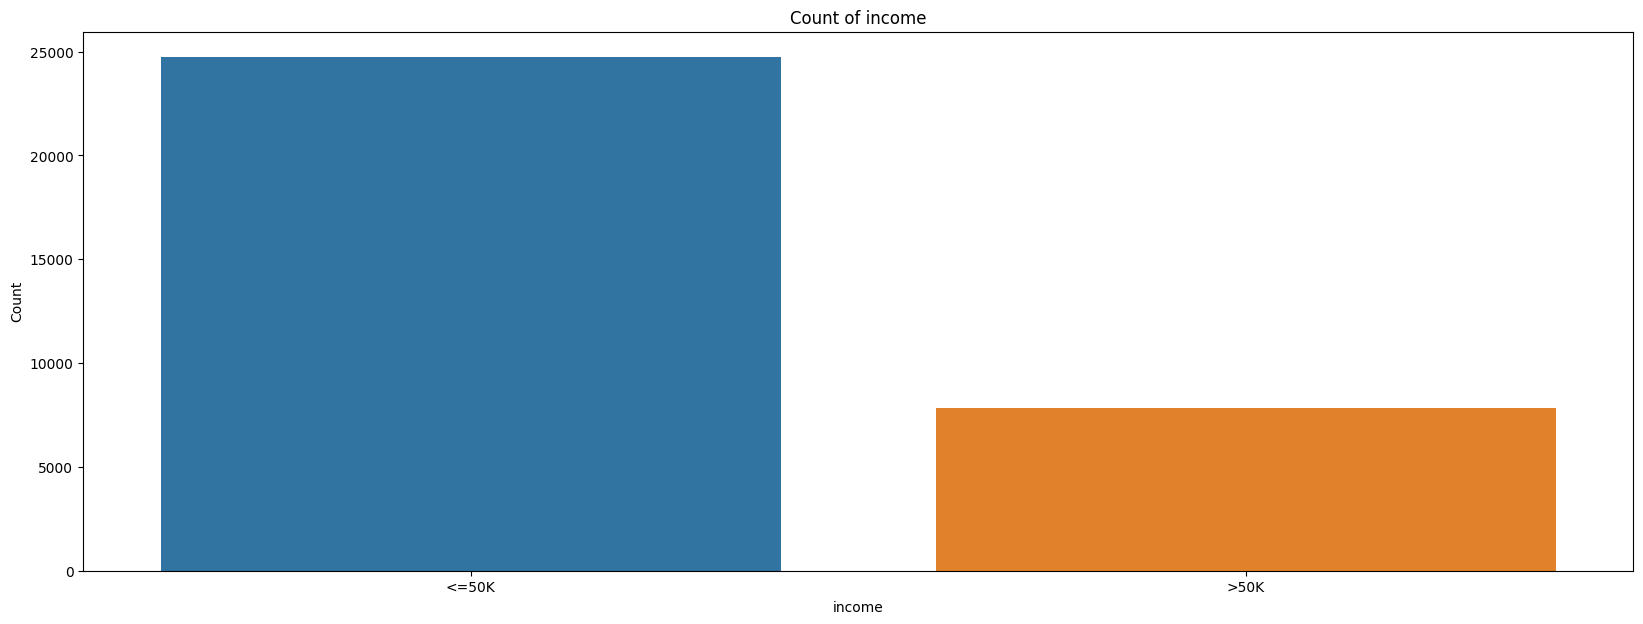

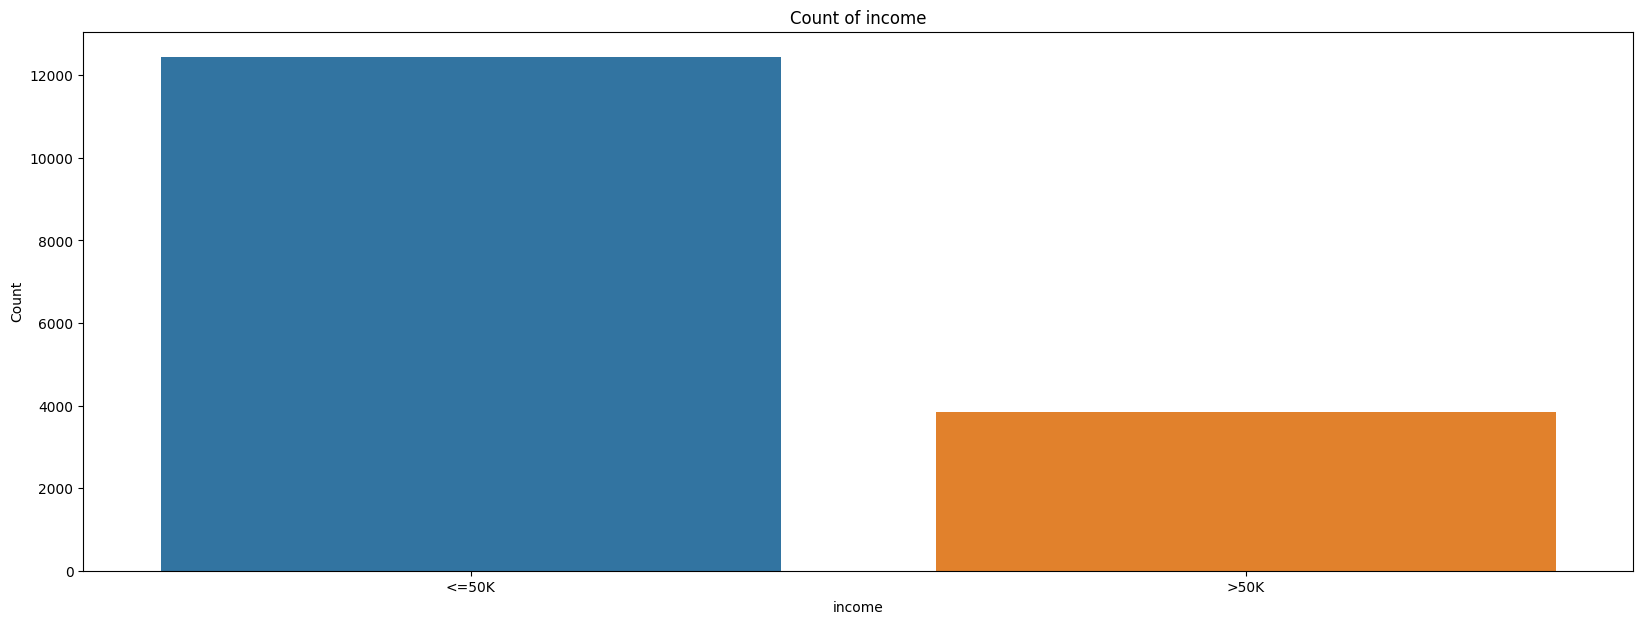

In [9]:
describe_target_dataset(adultsTrain, 'income')
describe_target_dataset(adultsTest, 'income')

##### Age Insights: 
- Similar Distribution between training and testing
- Imbalance of Target Classes

#### Age: Continuous

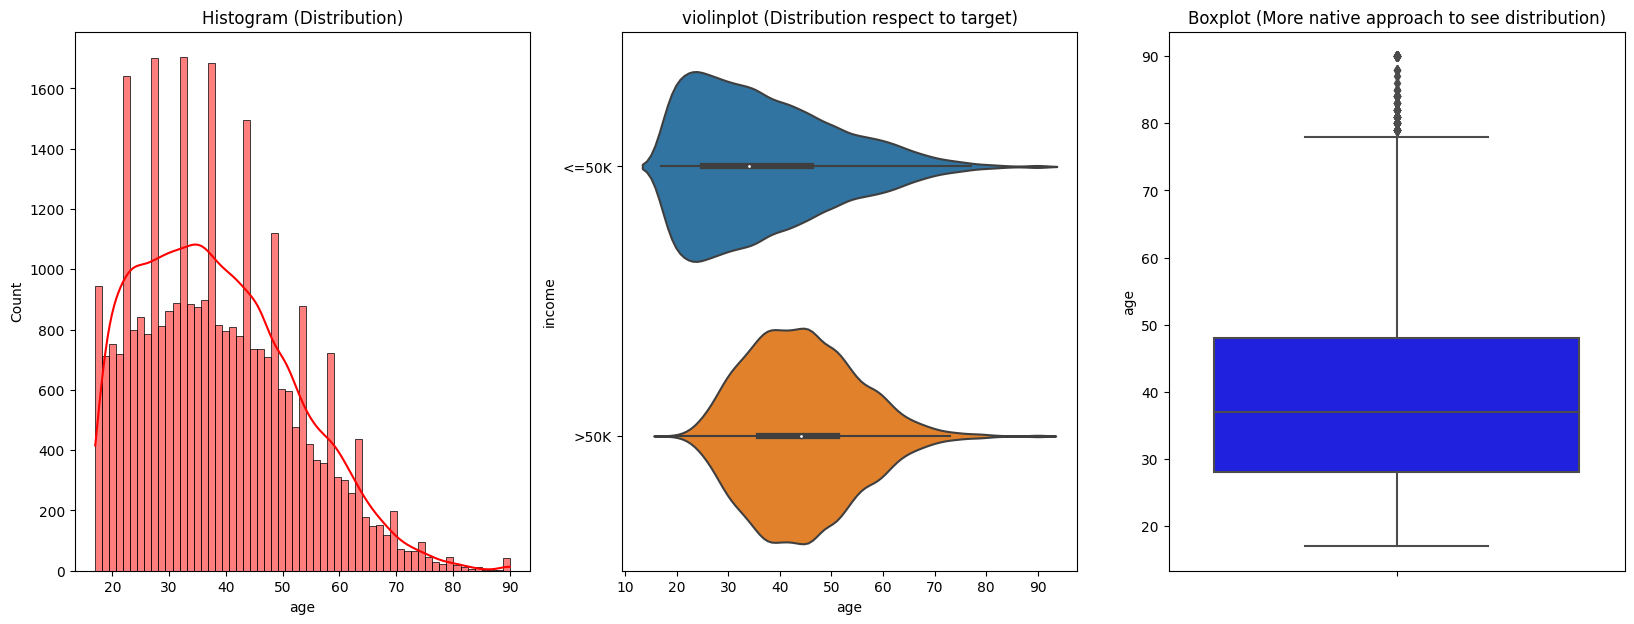

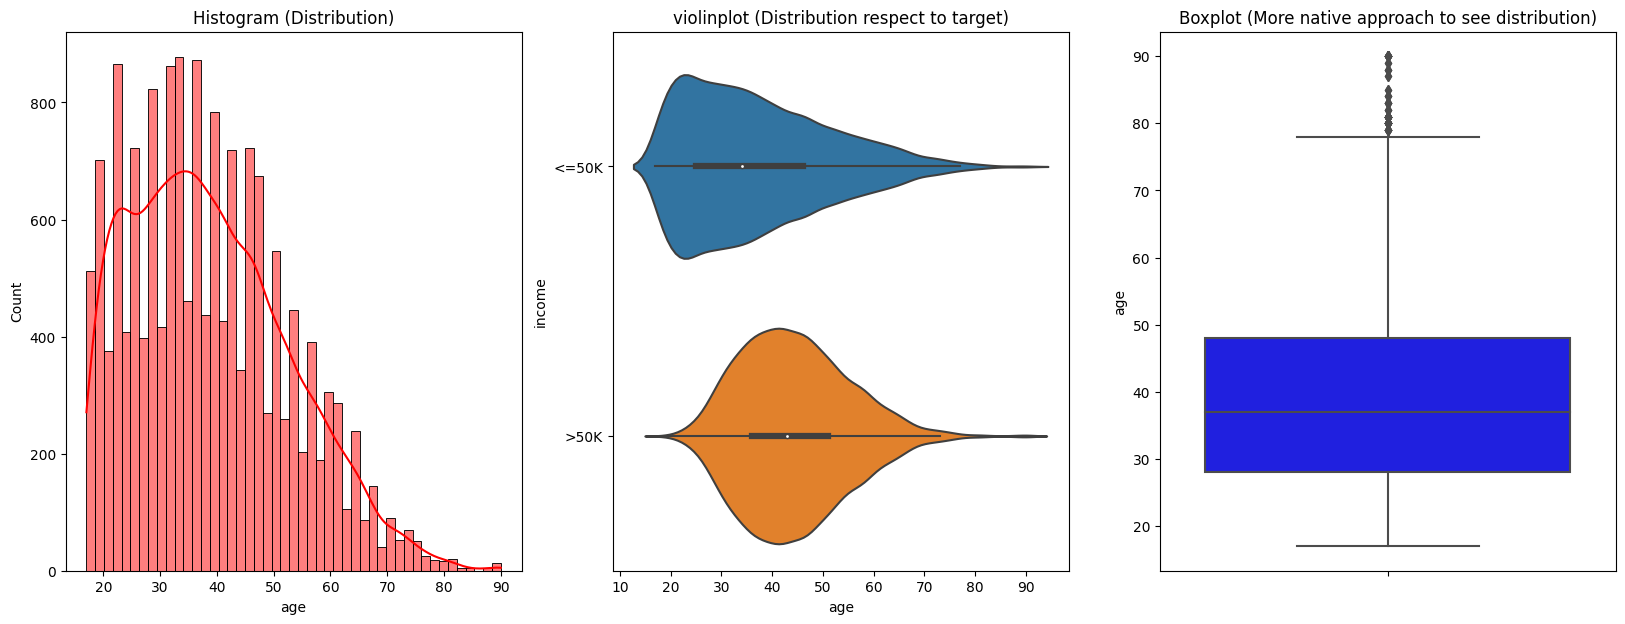

In [10]:
#train dataset
describe_continuous_dataset(adultsTrain, 'age')
#test dataset
describe_continuous_dataset(adultsTest, 'age')

##### Age Insights: 
- Similar Distribution between training and testing
- Meaningful (lower ages tend to have <= 50K)
- There are some outliers on a really old age (but tree is okay with outliers)

#### Workclass : Nominal Categorical

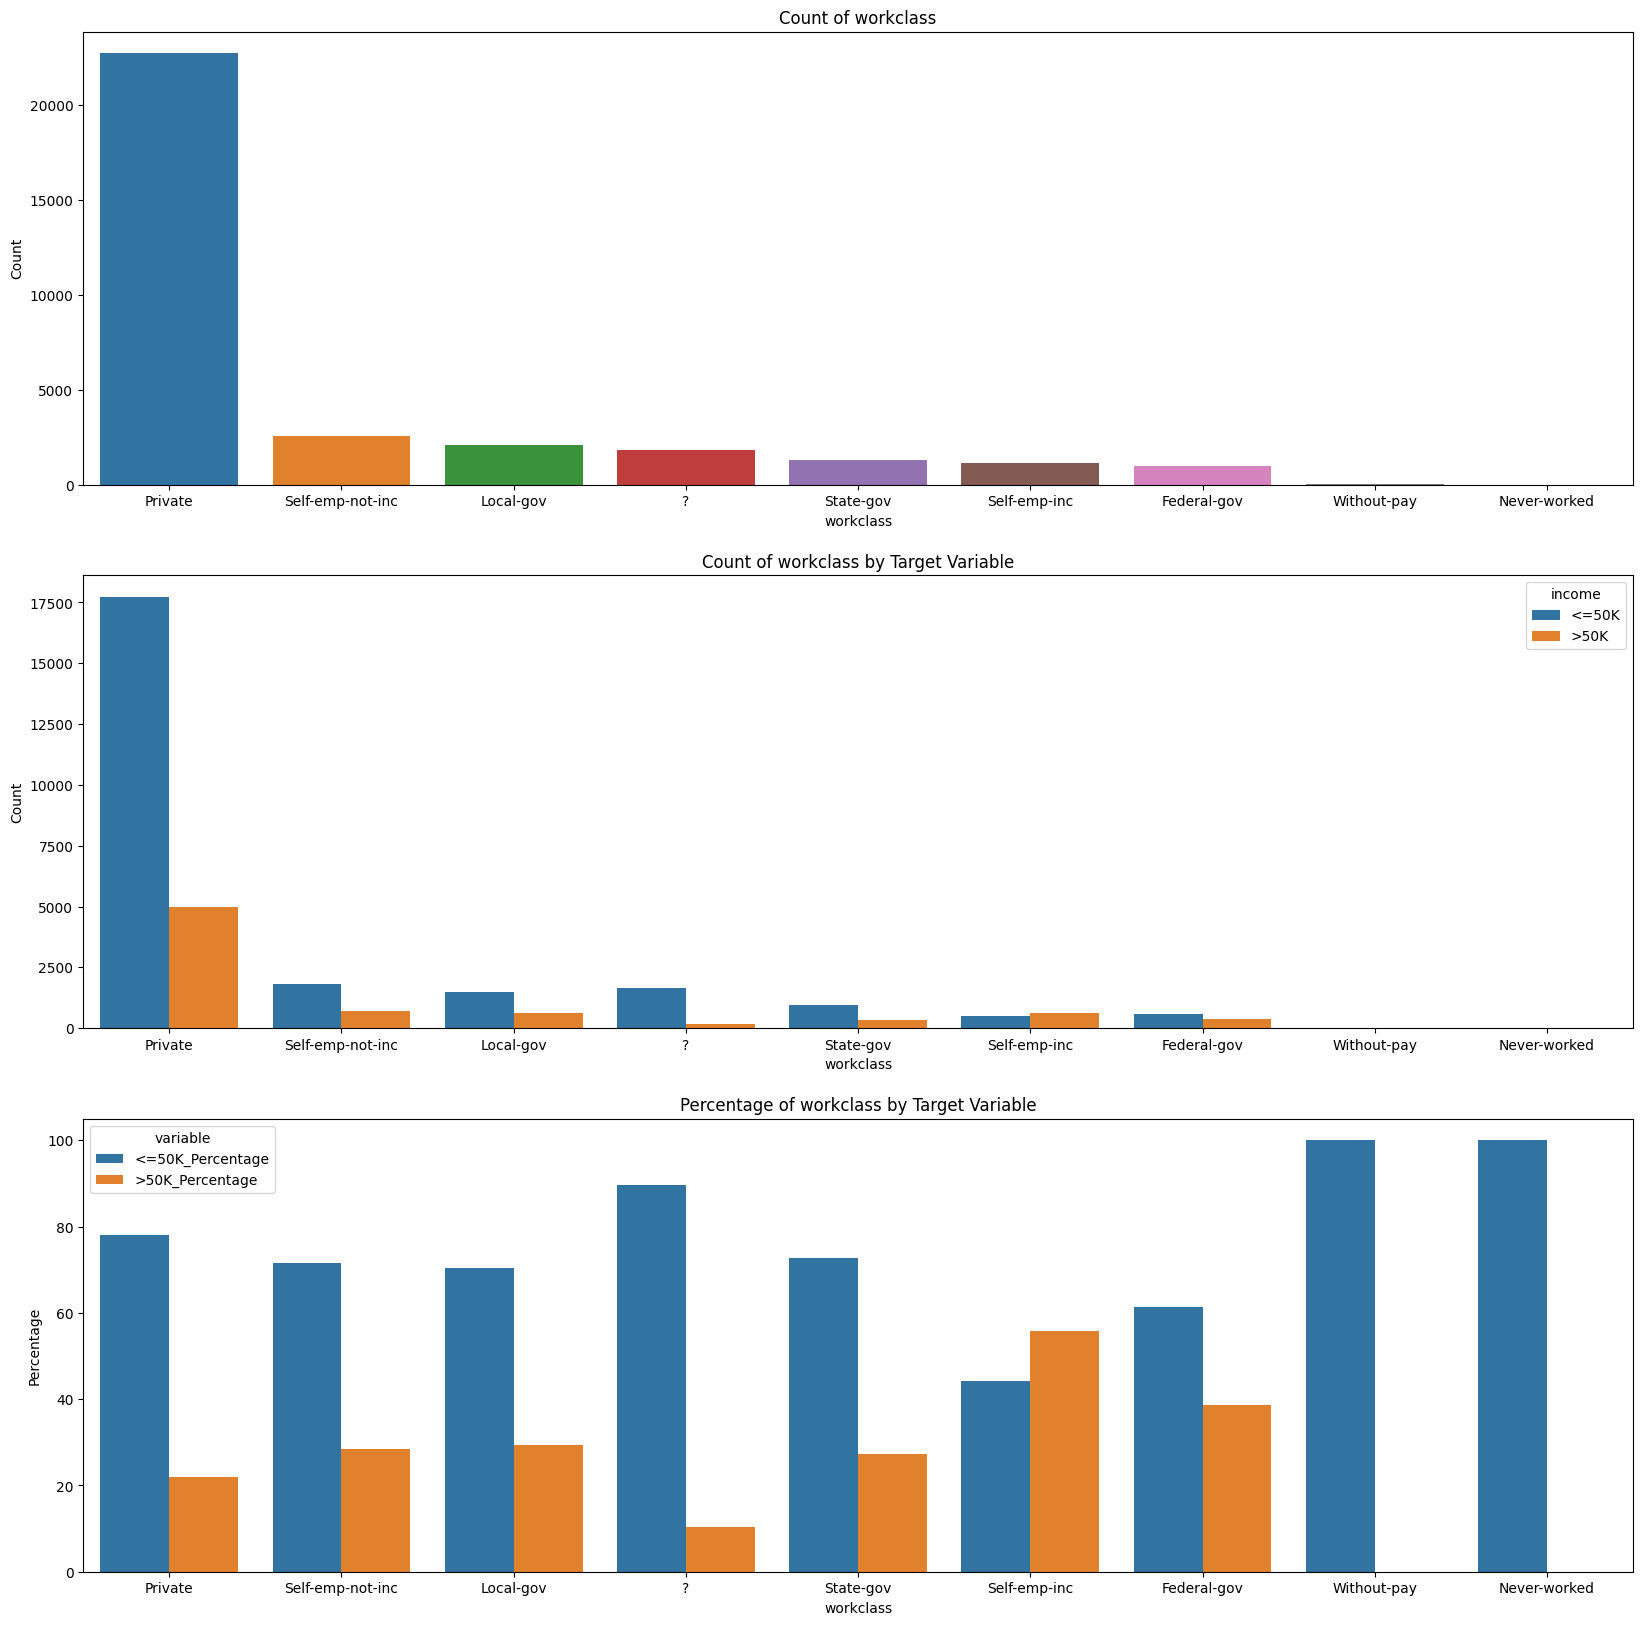

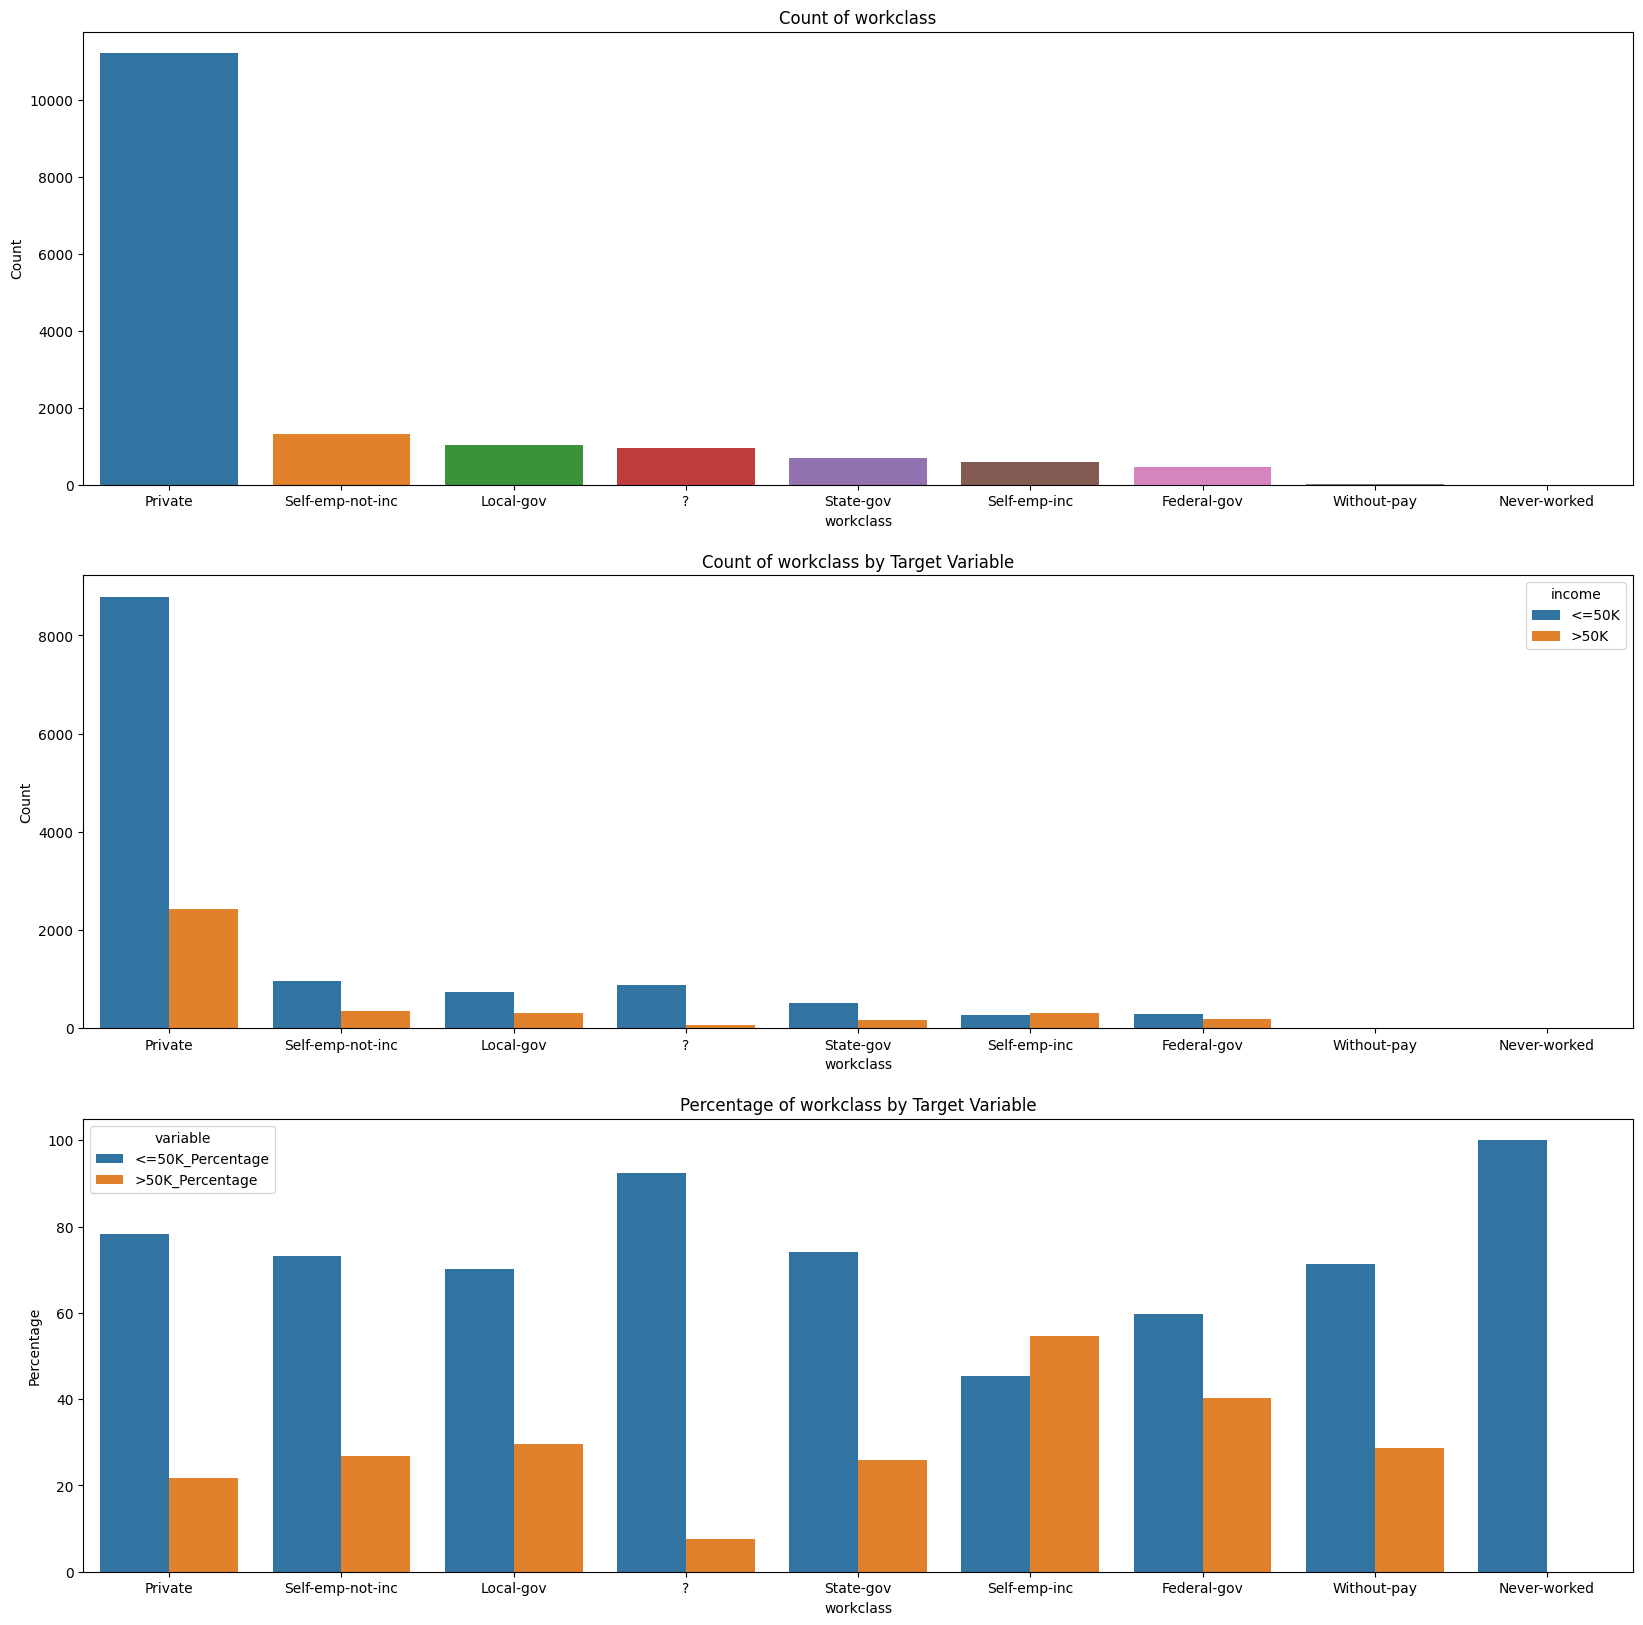

In [11]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'workclass')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'workclass')

##### workclass Insights: 
- Similar Distribution between training and testing
- Meaningful (Self employed has higher rate of having >50K, while Never-worked are most likely to have <= 50K)
- Most of them are private
- There are empty values in train data and test data, and they might have so-so similarity distribution with the mode of this attribute (private)

#### fnlwgt: Continuous

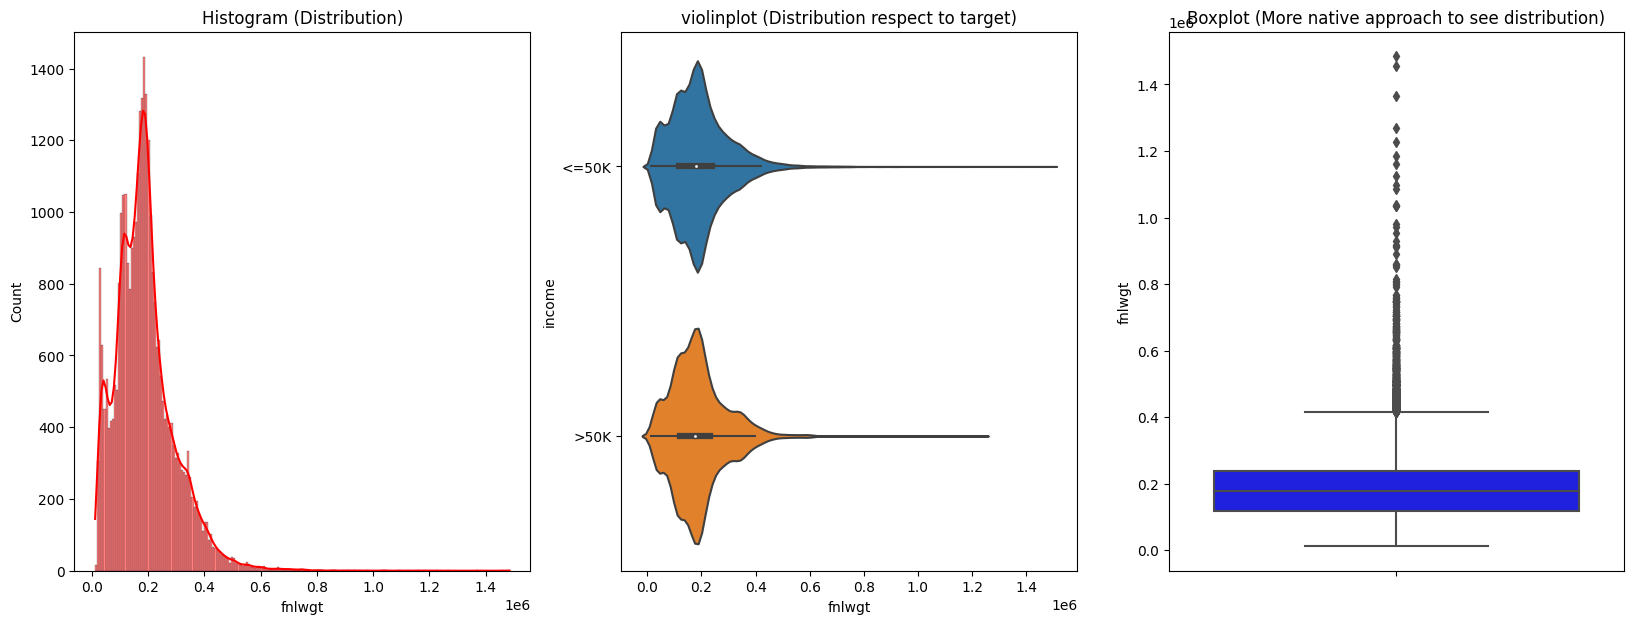

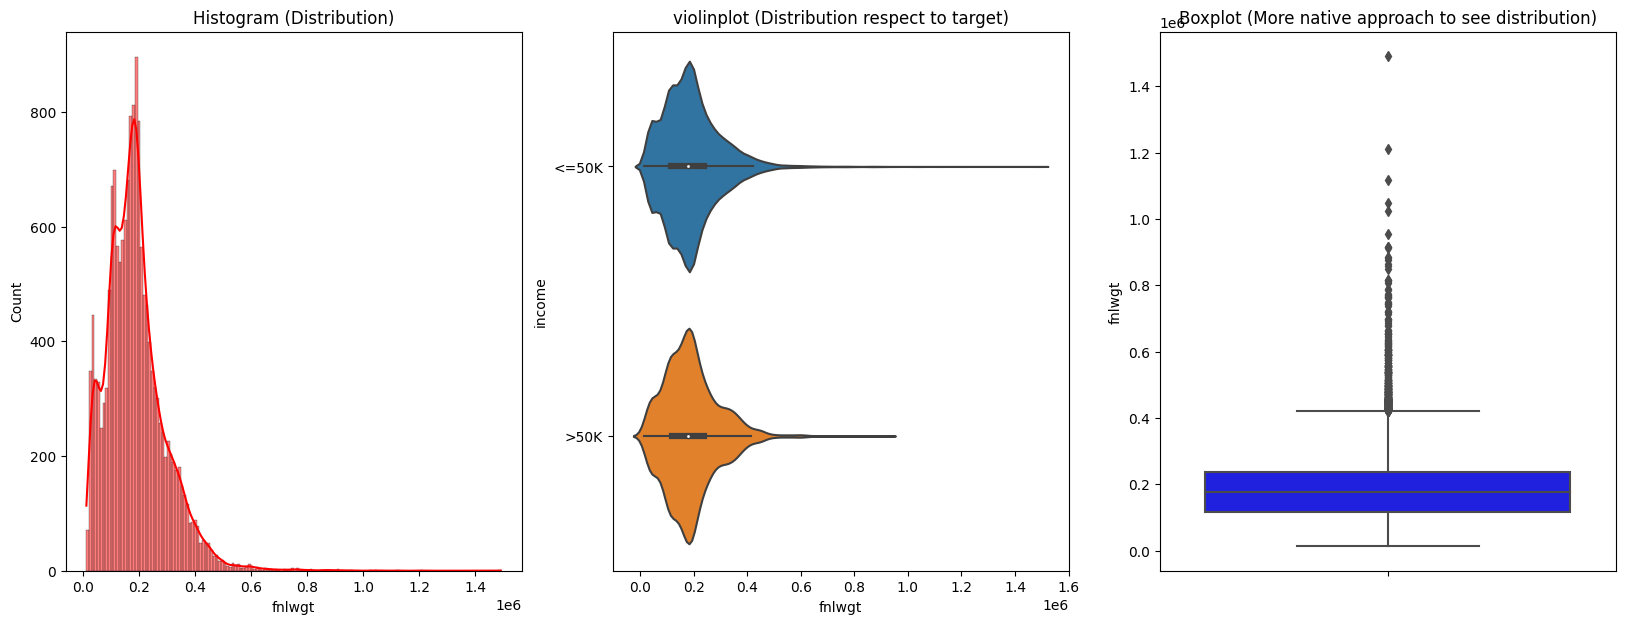

In [12]:
#train dataset
describe_continuous_dataset(adultsTrain, 'fnlwgt')
#test dataset
describe_continuous_dataset(adultsTest, 'fnlwgt')

##### workclass Insights: 
- Similar Distribution between training and testing
- Not that Meaningful (Self employed has higher rate of having >50K, while Never-worked are most likely to have <= 50K)
- Skewed graphic, most of the really high values are <=50K, but we can't say for sure with the majority

#### education: Ordinal Categorical & education-num: Continuous

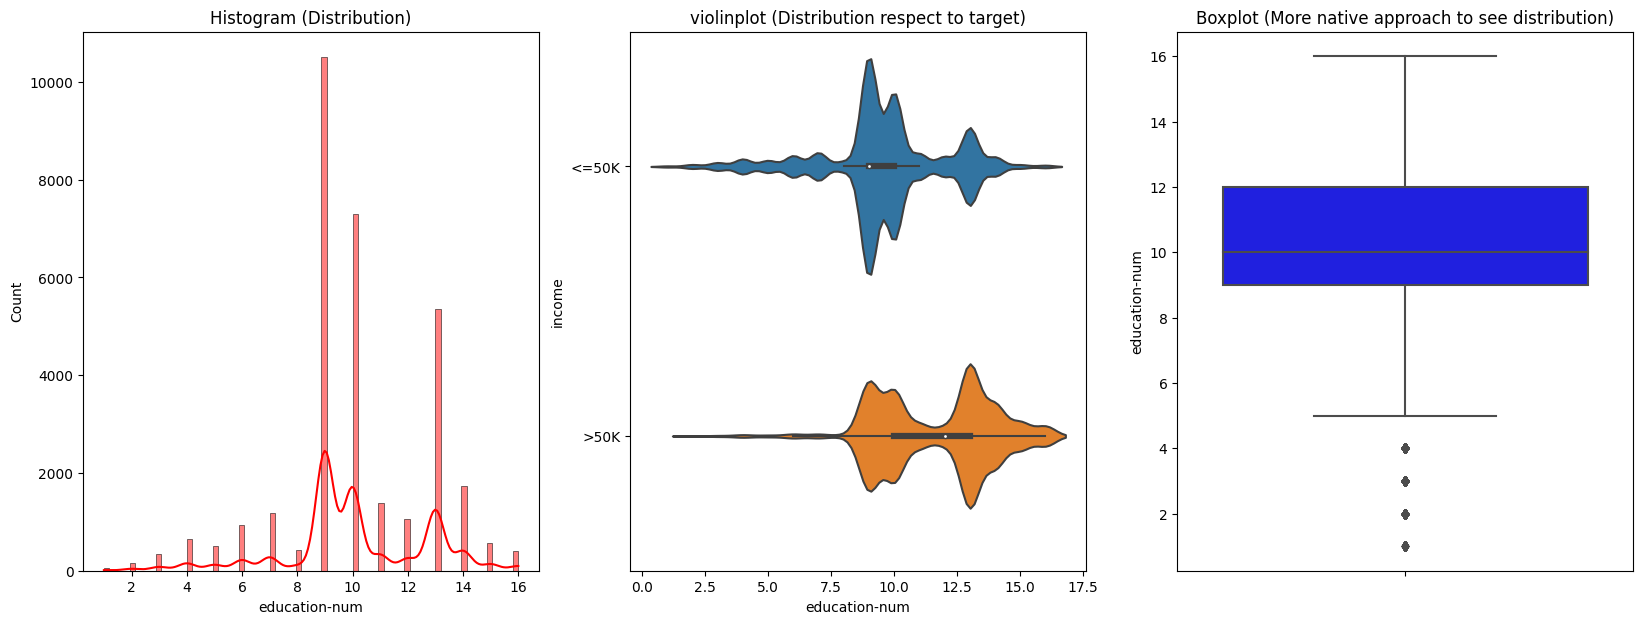

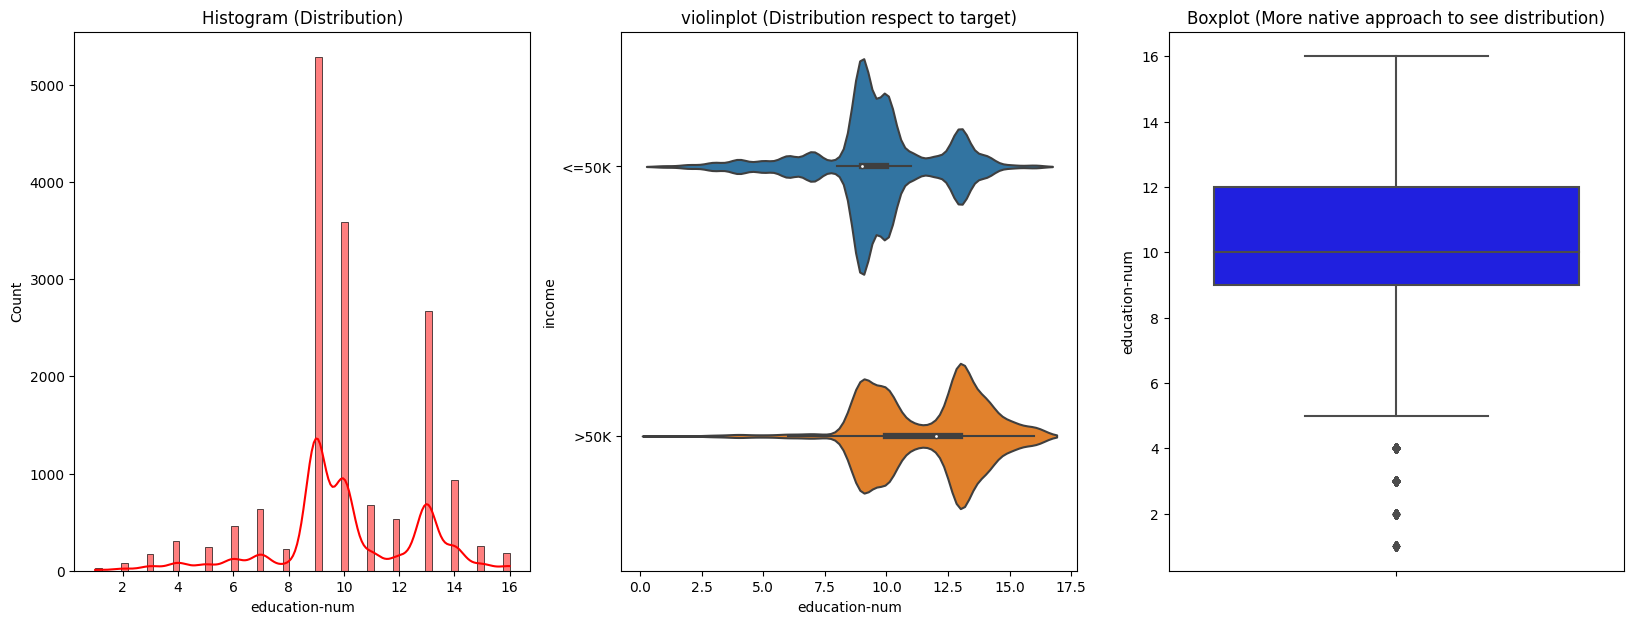

In [13]:
#train dataset
describe_continuous_dataset(adultsTrain, 'education-num')
#test dataset
describe_continuous_dataset(adultsTest, 'education-num')

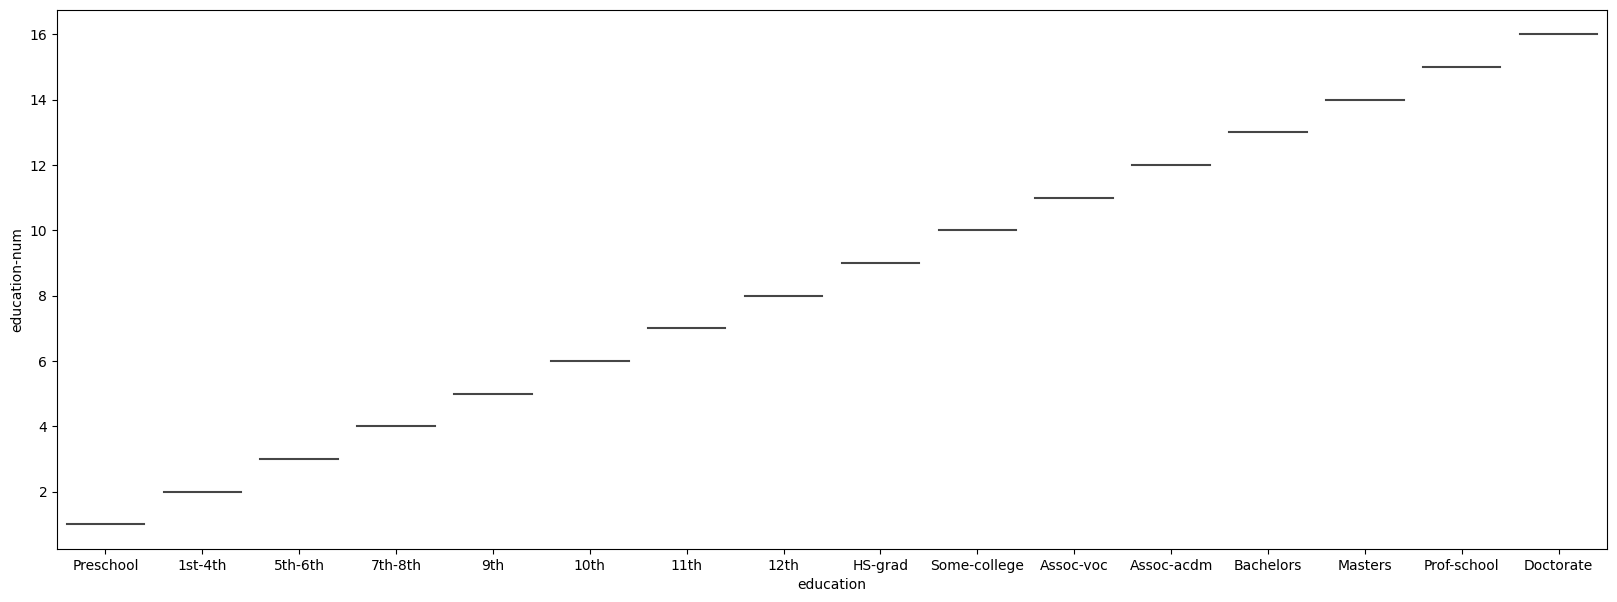

In [14]:
#Correlation of education-num with education
plt.figure(figsize=(20, 7))
education_level_sorting = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school','Doctorate']
sns.violinplot(x='education', y='education-num', data=adultsTrain, order = education_level_sorting)
plt.show()

##### education-num Insights: 
- Similar Distribution between training and testing
- Meaningful (higher education num tend to have <= 50K)
- There are some outliers on a really low education
- Education and education-num are really correlated with each other, we only need to use 1

#### marital-status: Nominal Categorical

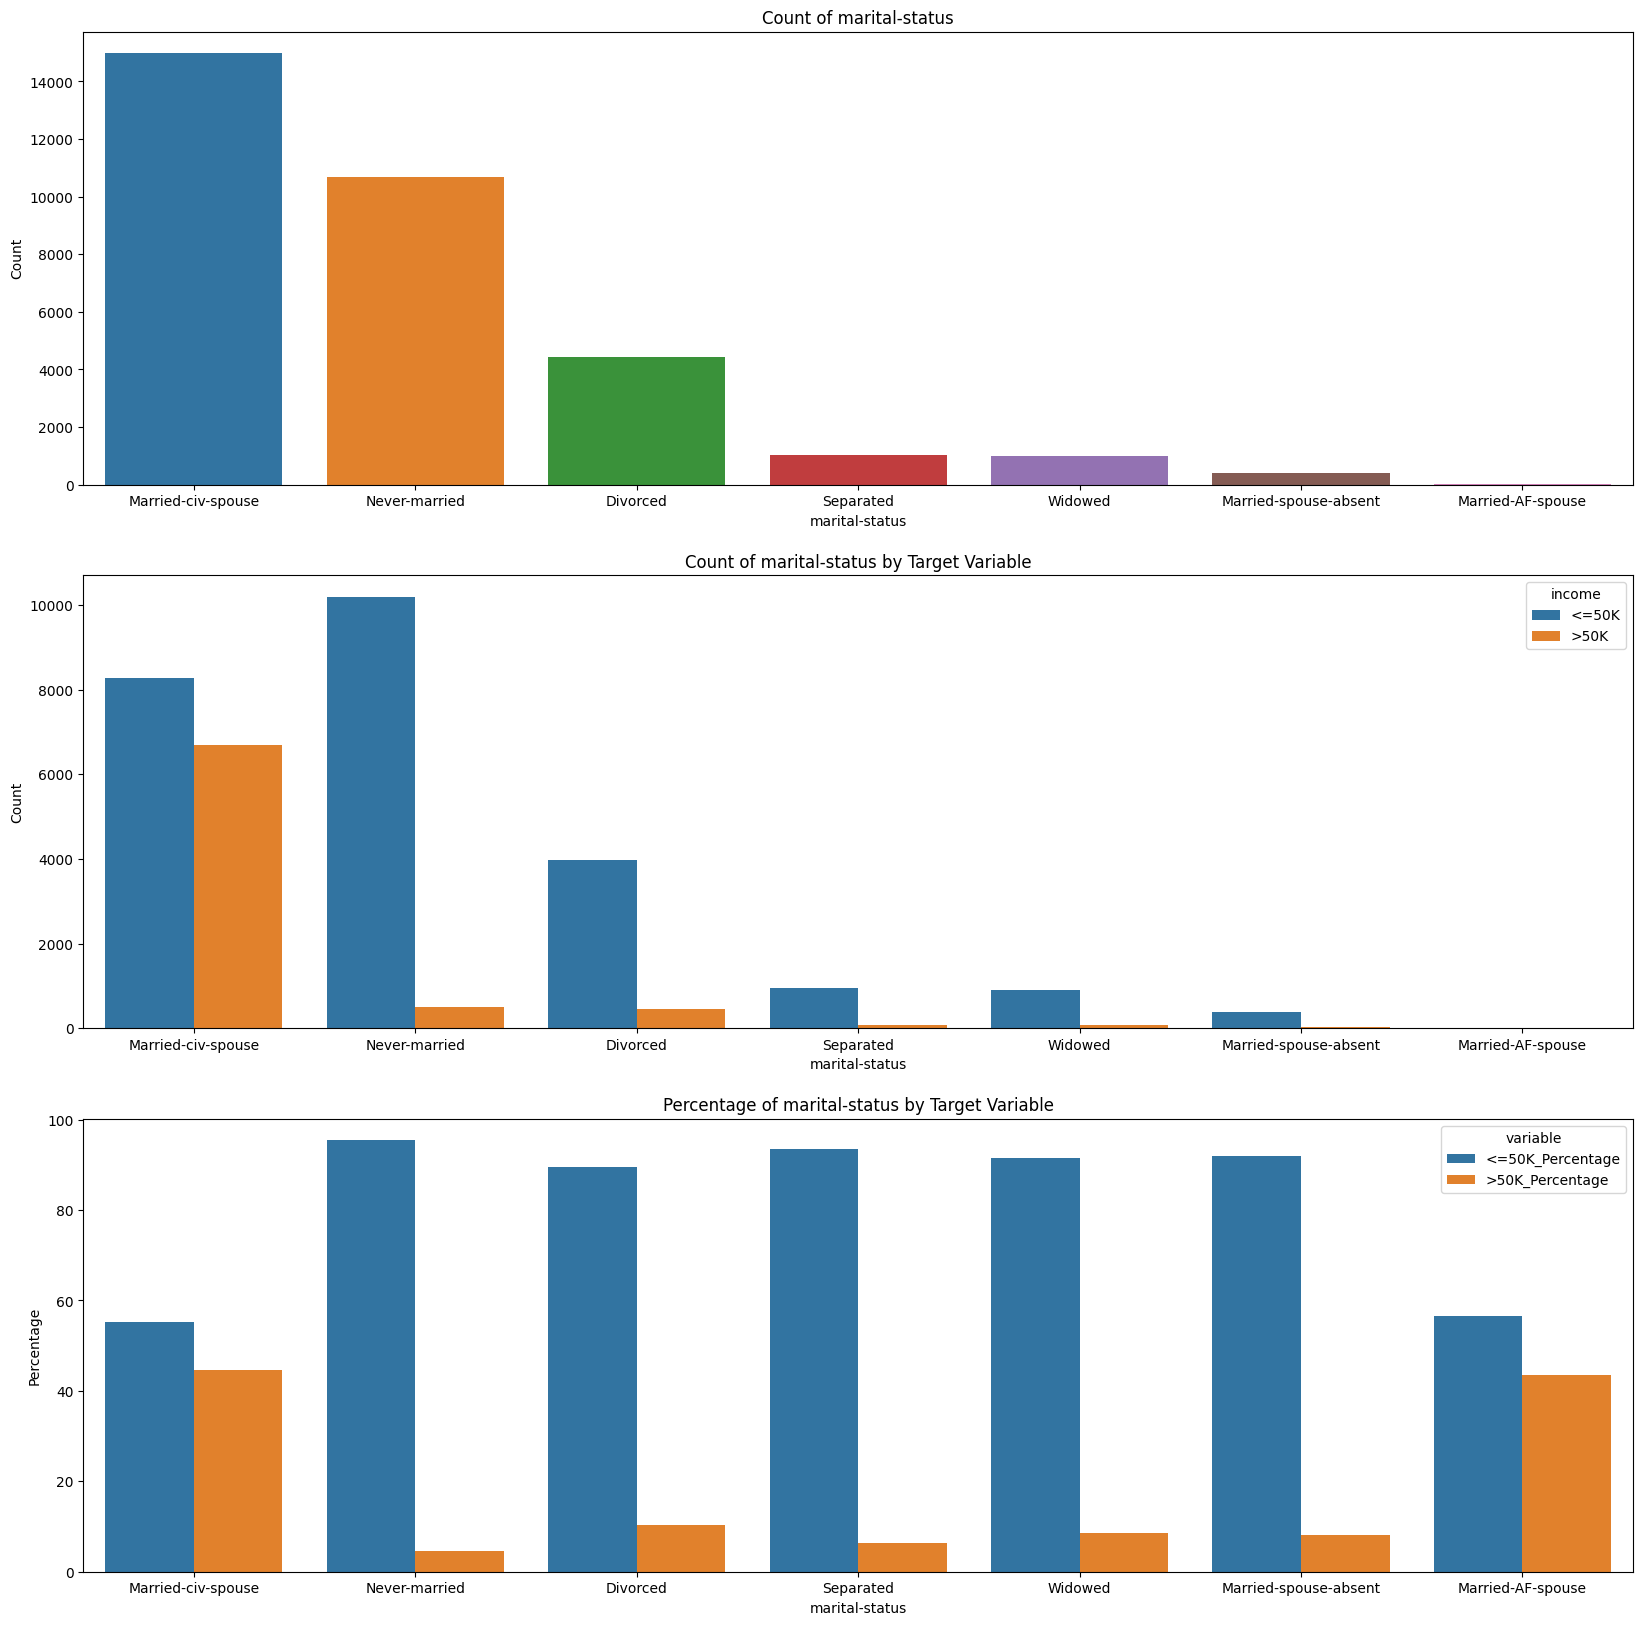

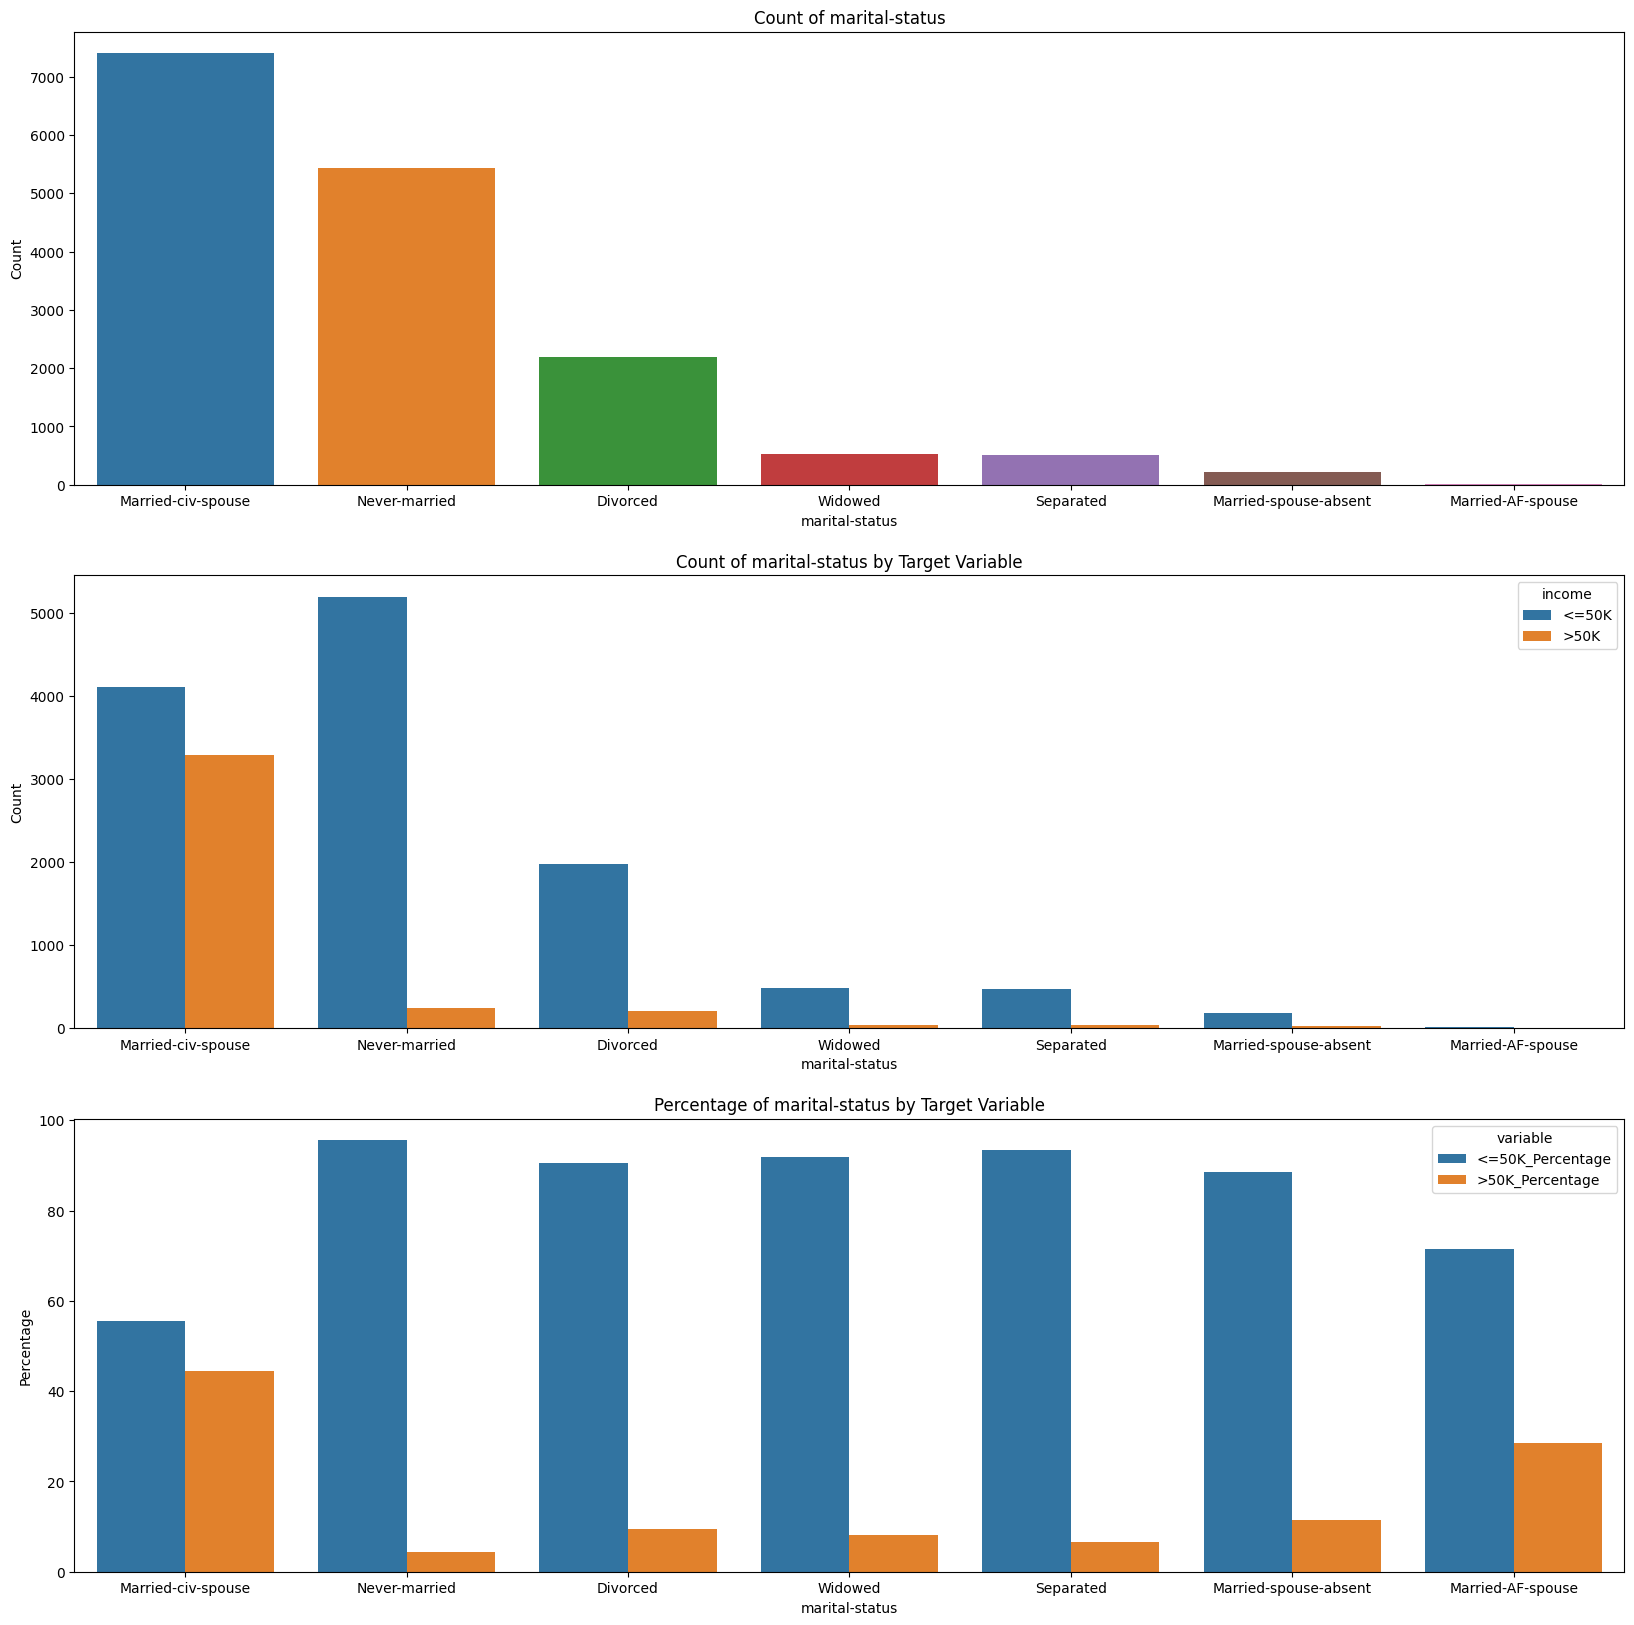

In [15]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'marital-status')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'marital-status')

##### marital-status Insights: 
- Similar Distribution between training and testing
- Meaningful, as Married spouse without absent has more probability of >50K
- Divorced, Widowed, Separated can simply has similar distribution and meaning (along with the distribution), simply means that they are a spouse but currently alone, so it can be grouped

#### occupation: Nominal Categorical

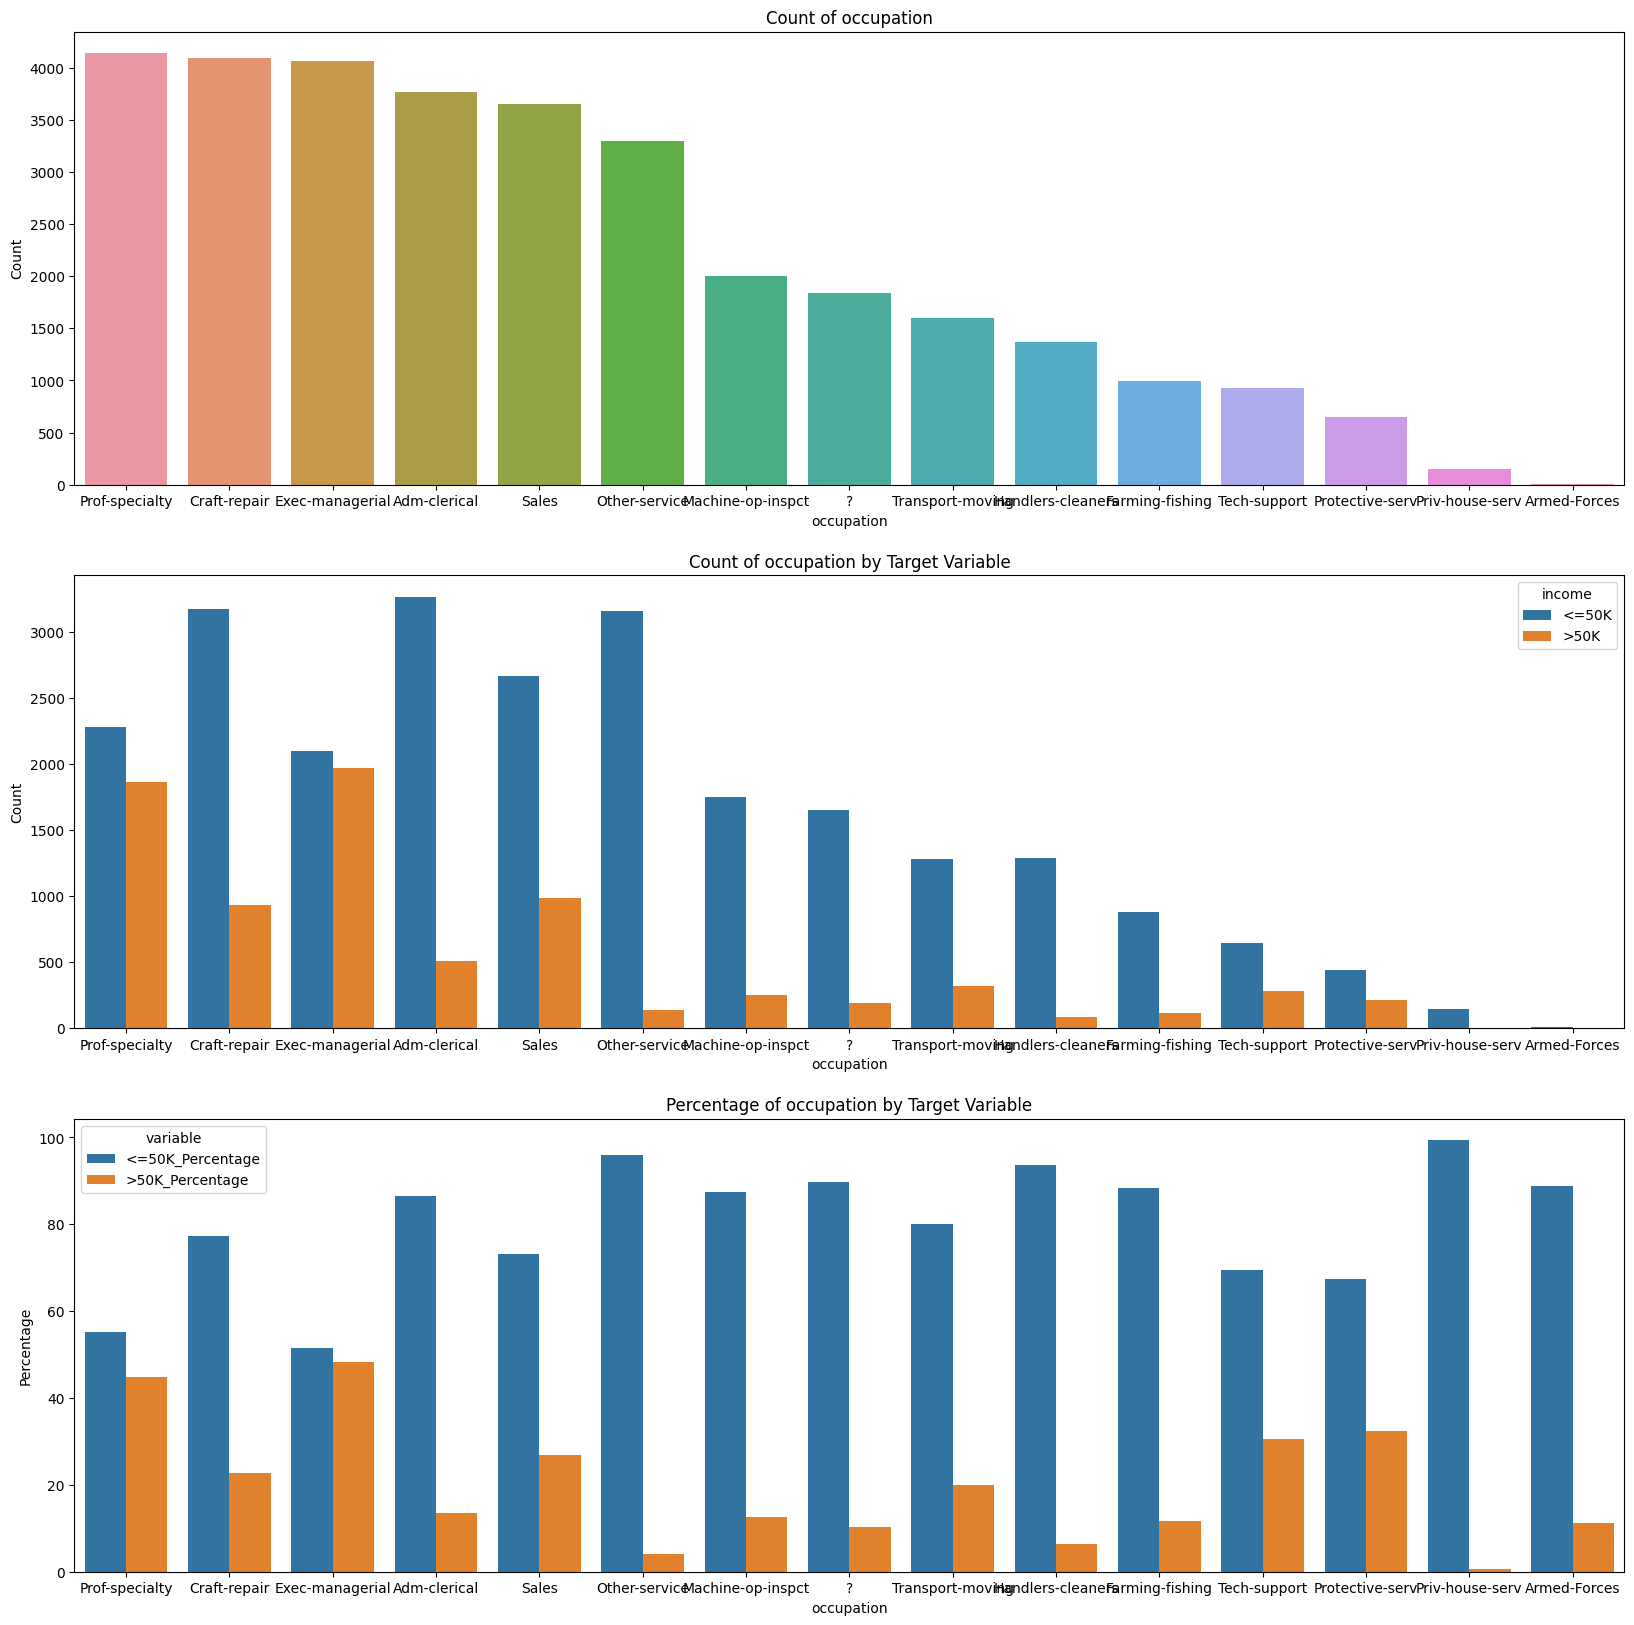

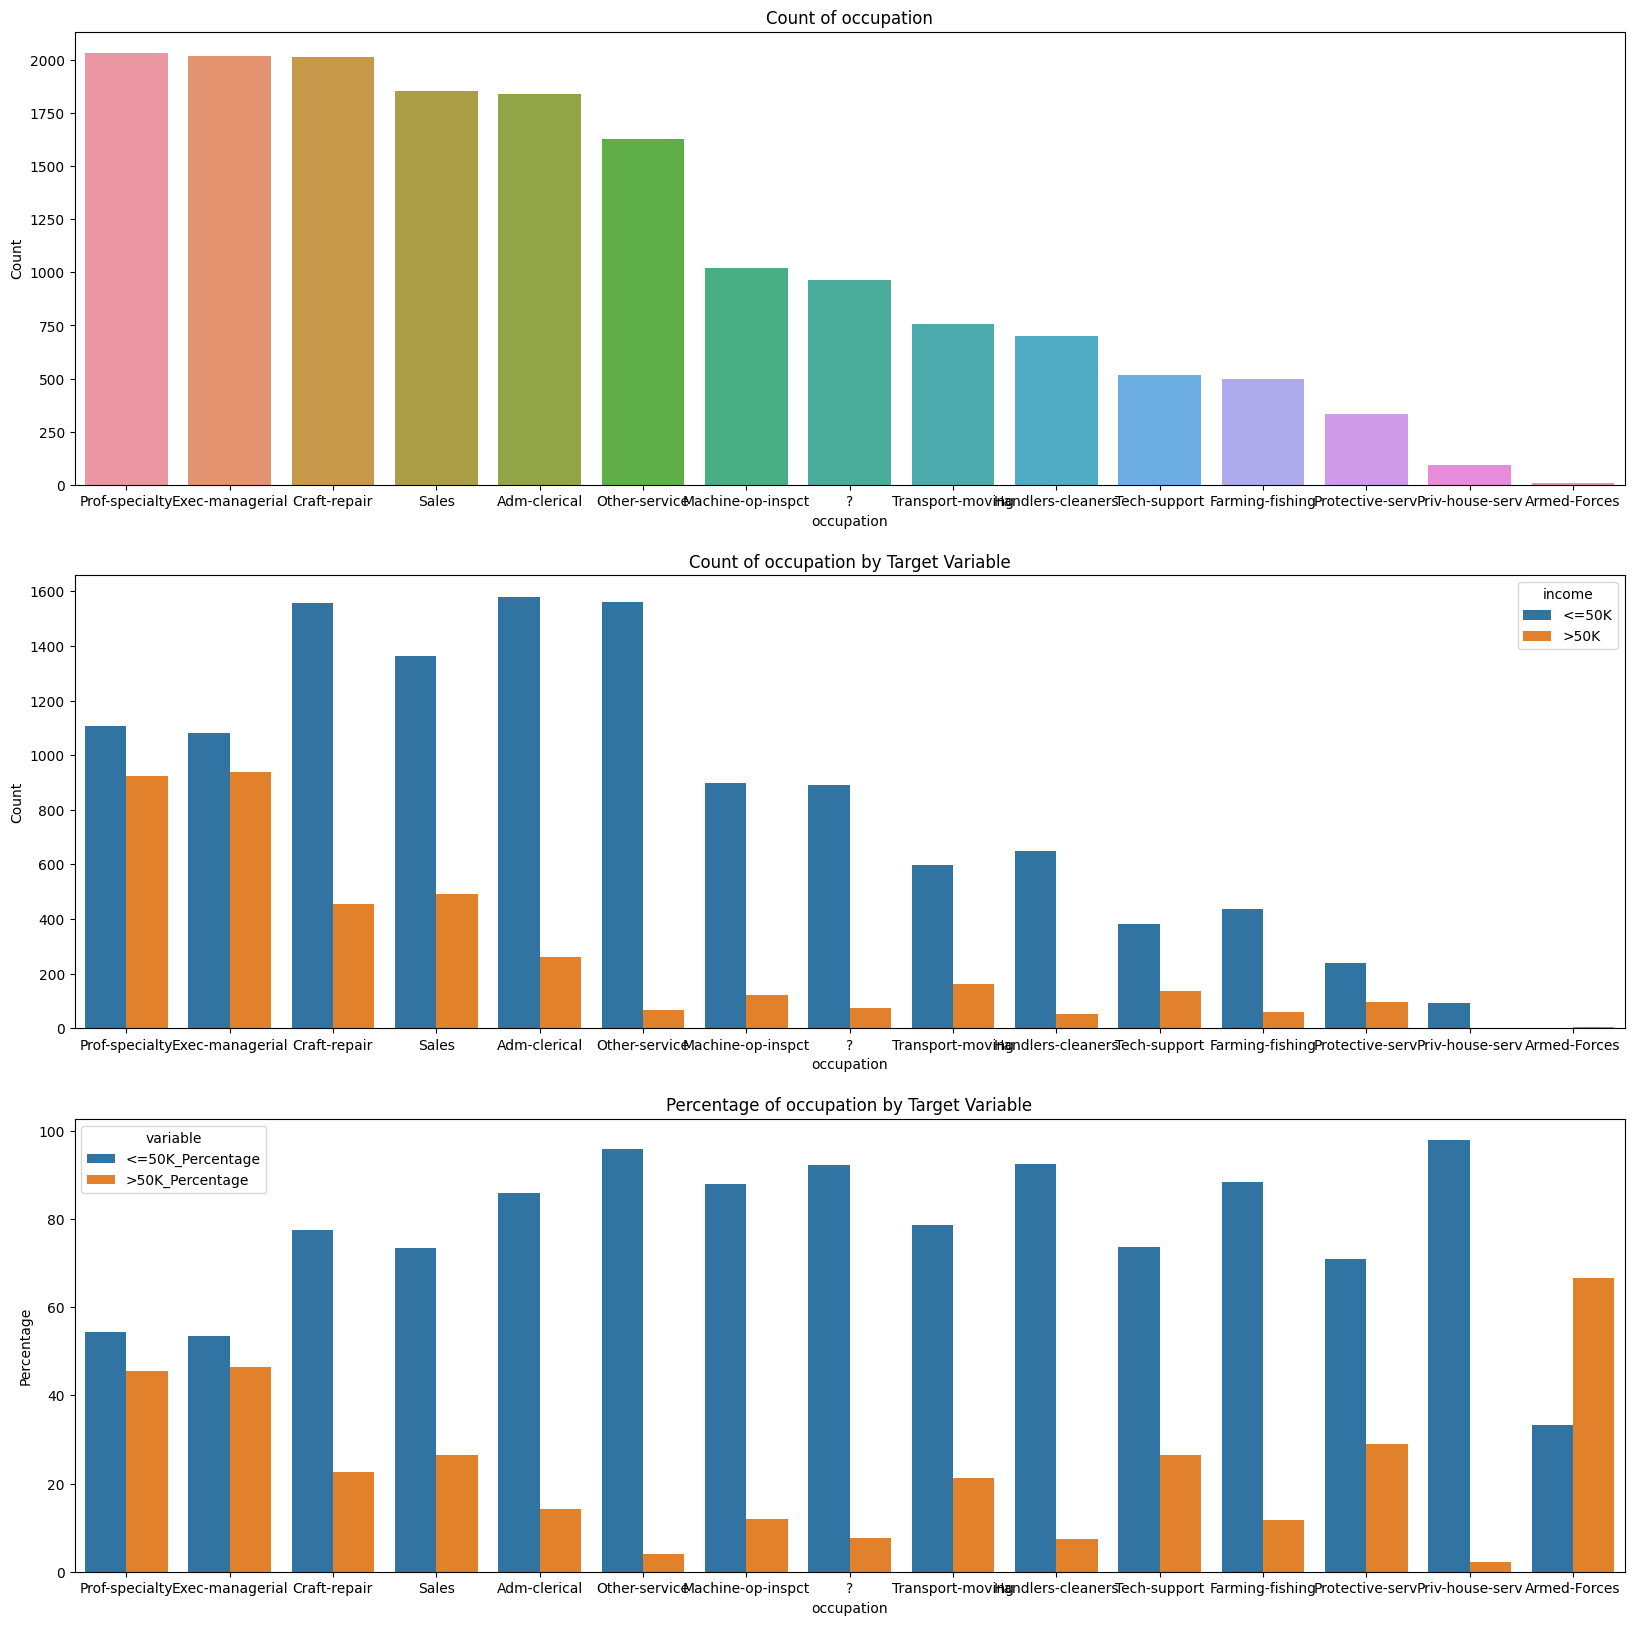

In [16]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'occupation')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'occupation')

##### occupation Insights: 
- Similar Distribution between training and testing
- Meaningful, as some jobs are more high in income than other

#### relationship: Nominal Categorical

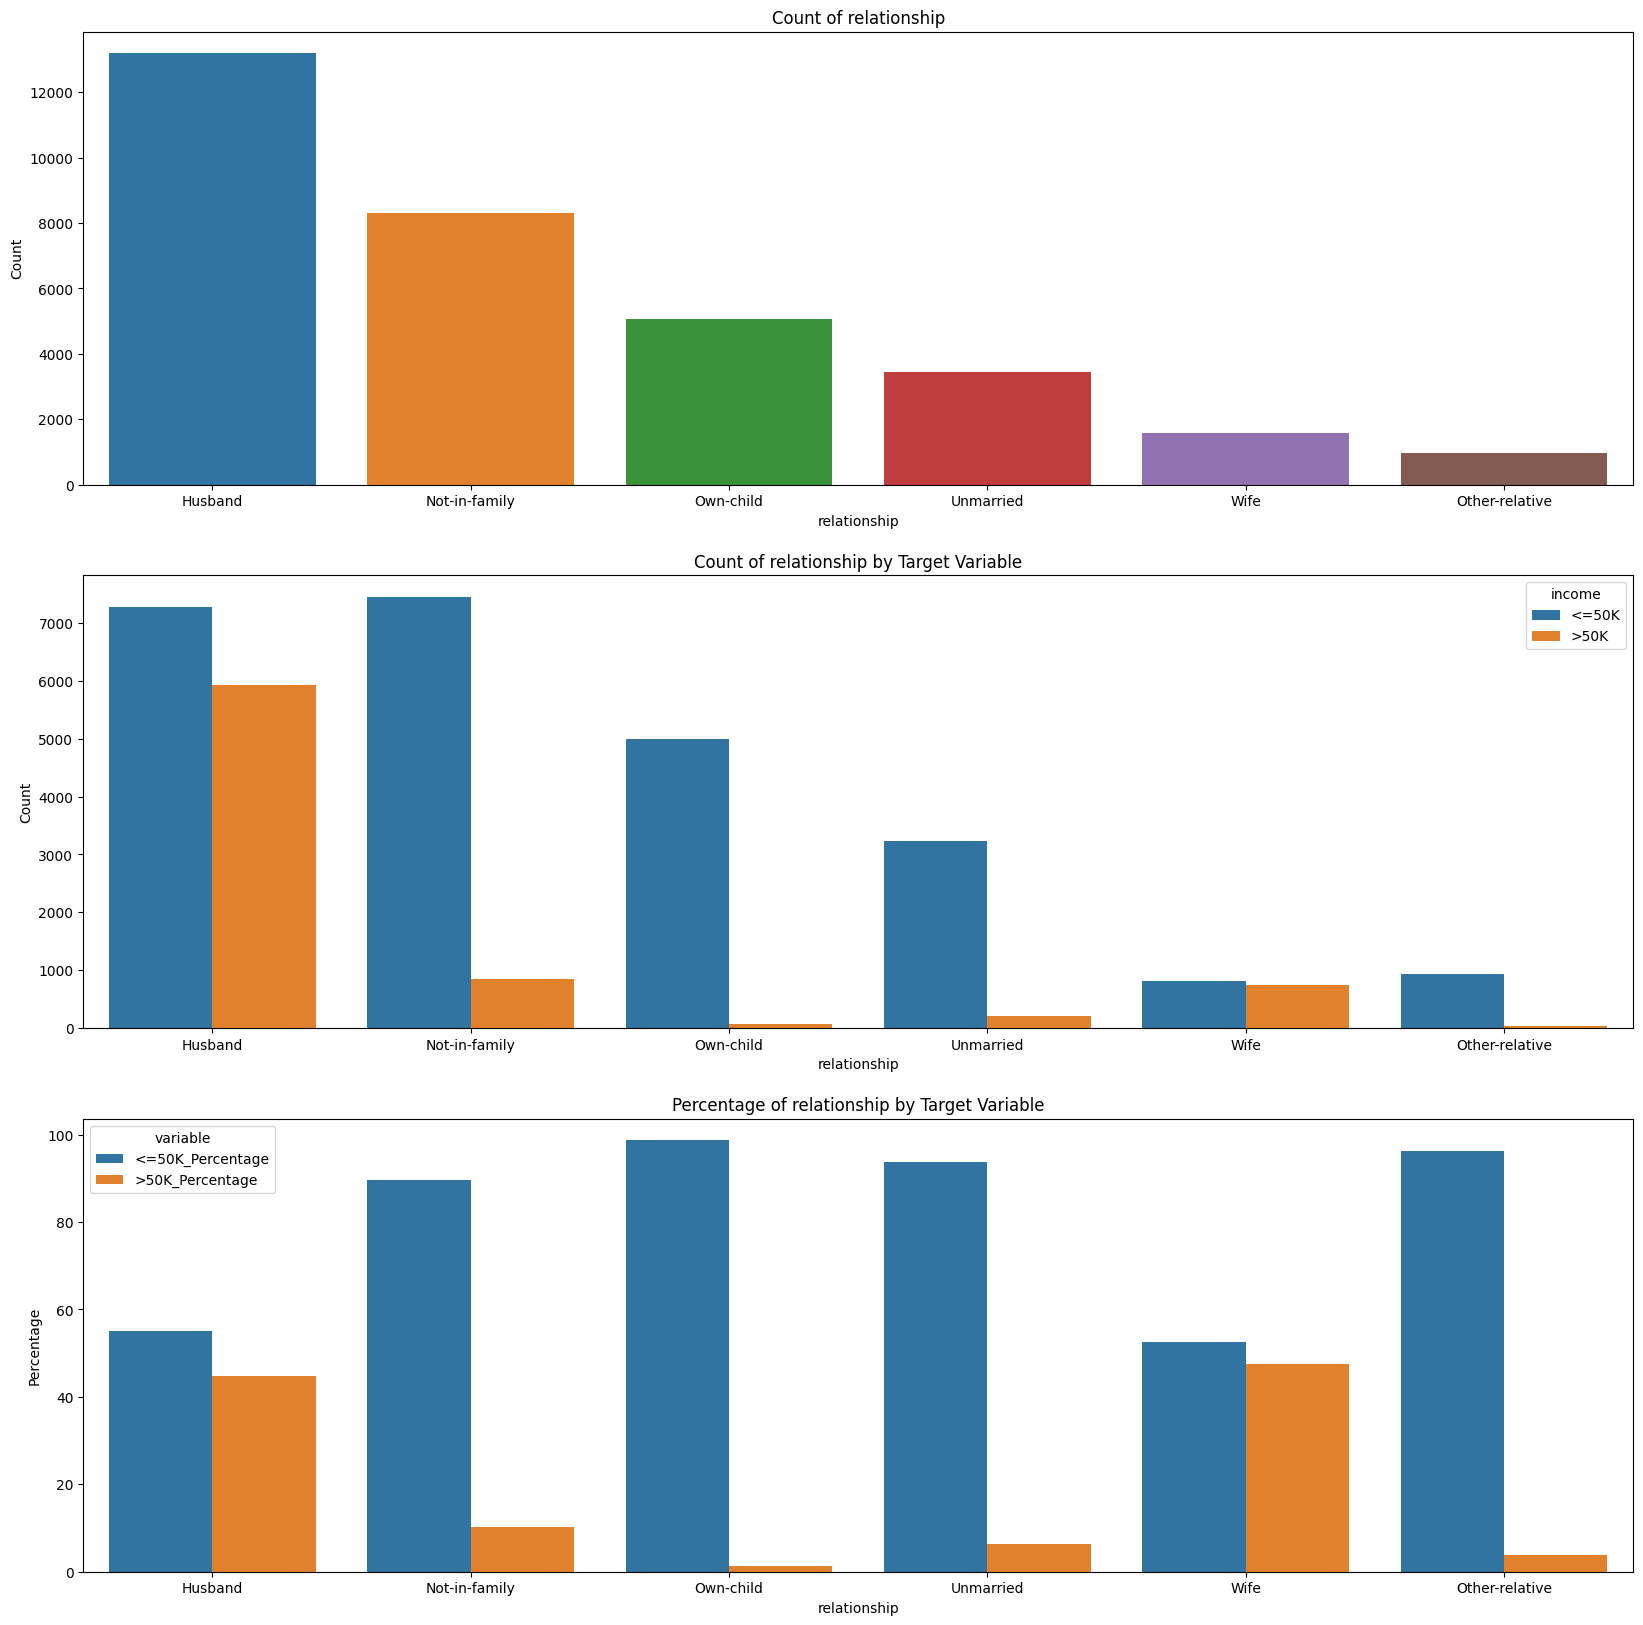

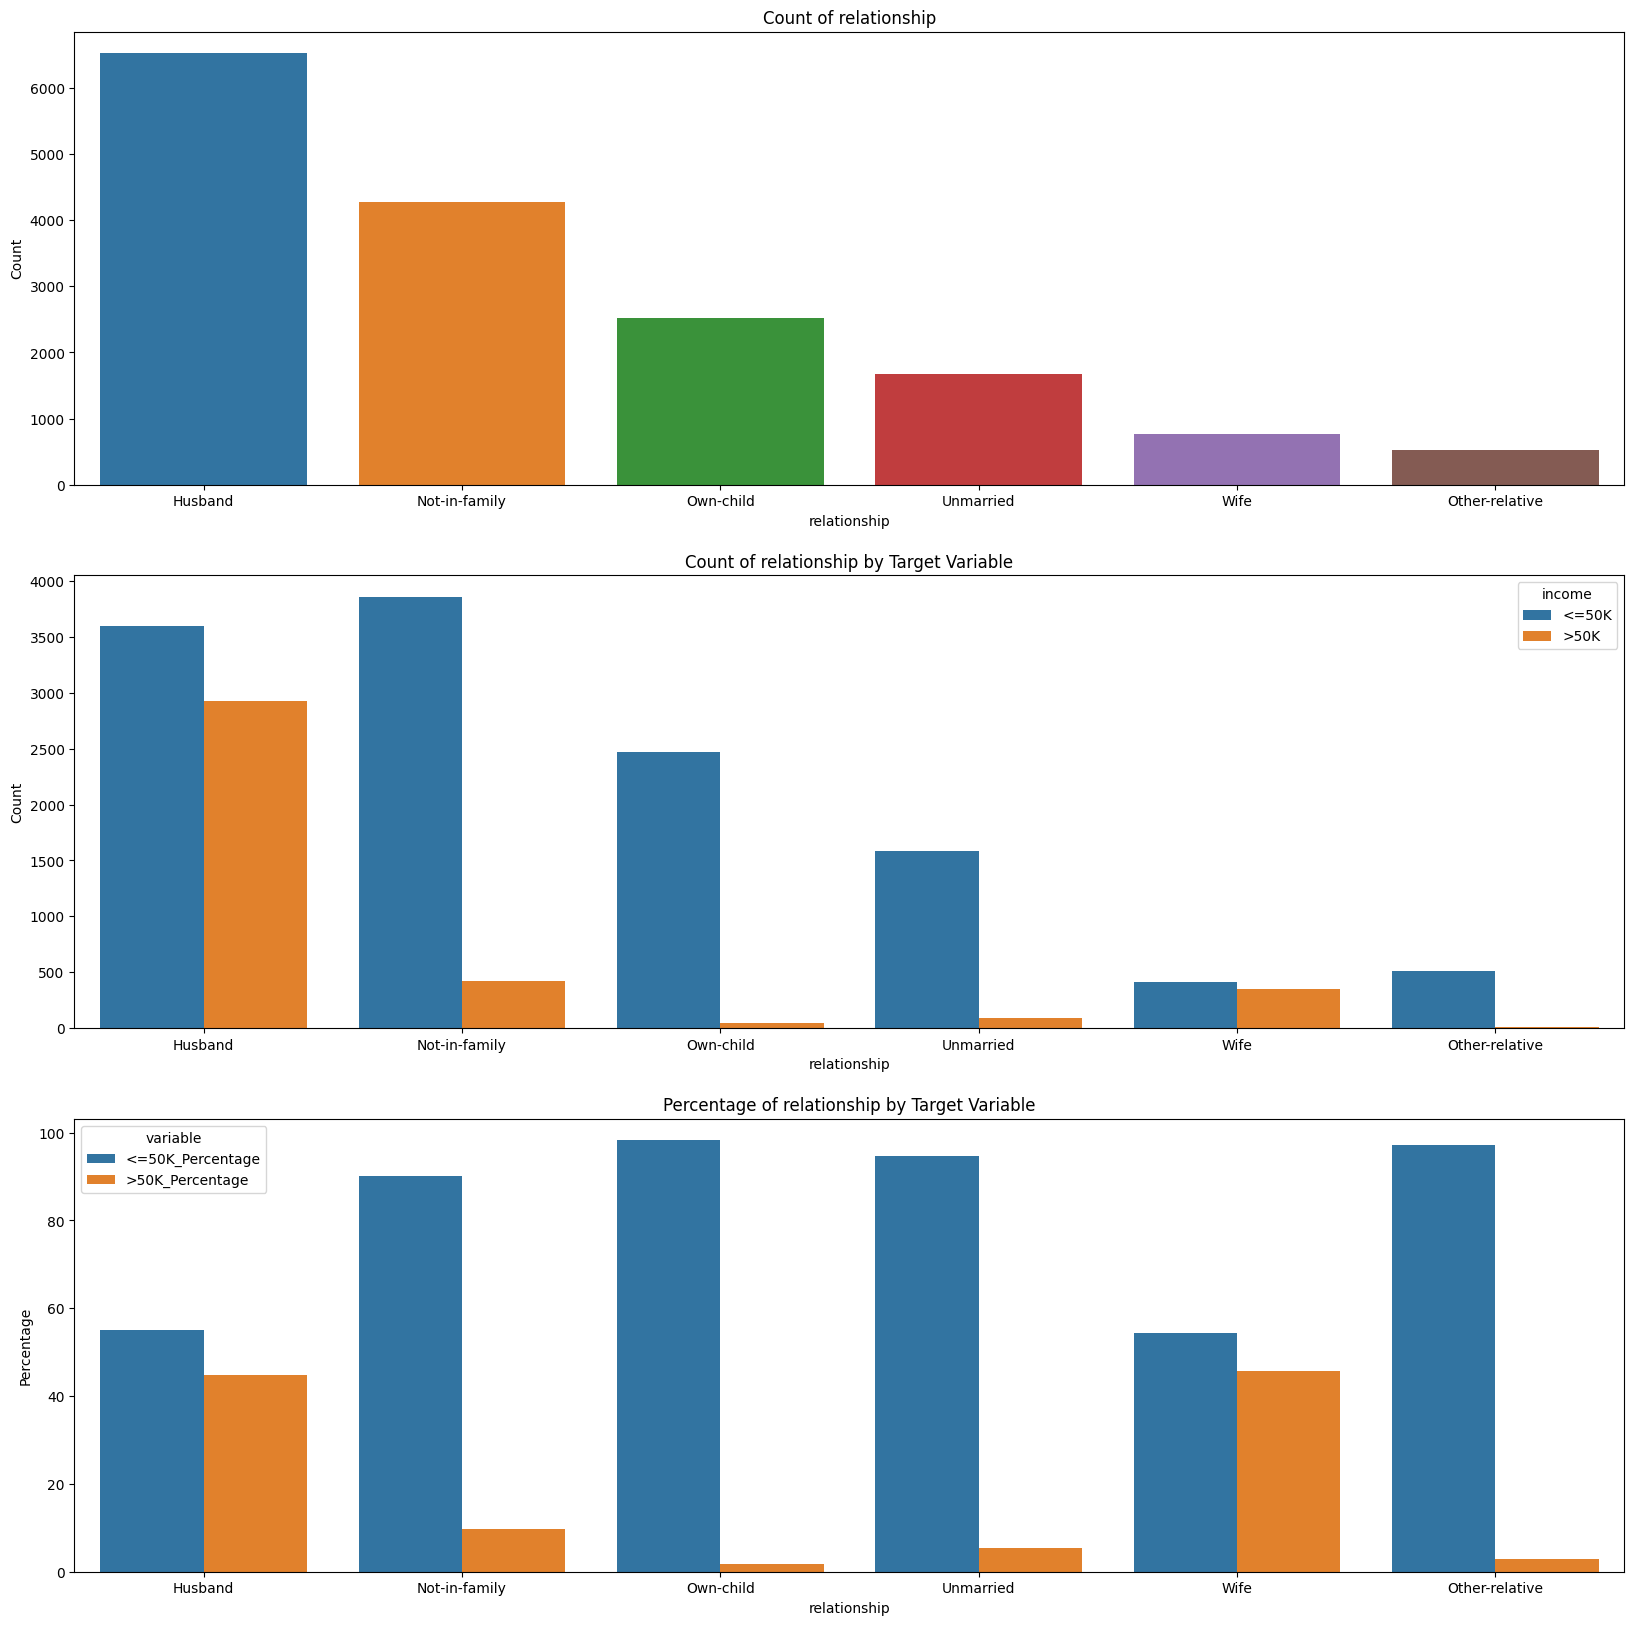

In [17]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'relationship')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'relationship')

In [18]:
# Correlation with marital-status
# Create a contingency table
contingency_table = pd.crosstab(adultsTrain['marital-status'], adultsTrain['relationship'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Compute Cramér's V
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape)-1  # -1 for degrees of freedom
v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-squared value = {chi2}")
print(f"P-value = {p}")
print(f"Cramér's V = {v}")

Chi-squared value = 38765.198041121424
P-value = 0.0
Cramér's V = 0.4879632713422777


##### relationship Insights: 
- Similar Distribution between training and testing
- Show moderate to high correlation with marital-status (Cramer's V is at 0.48, between 0-1, which 1 shows high correlation)

#### race: Nominal Categorical

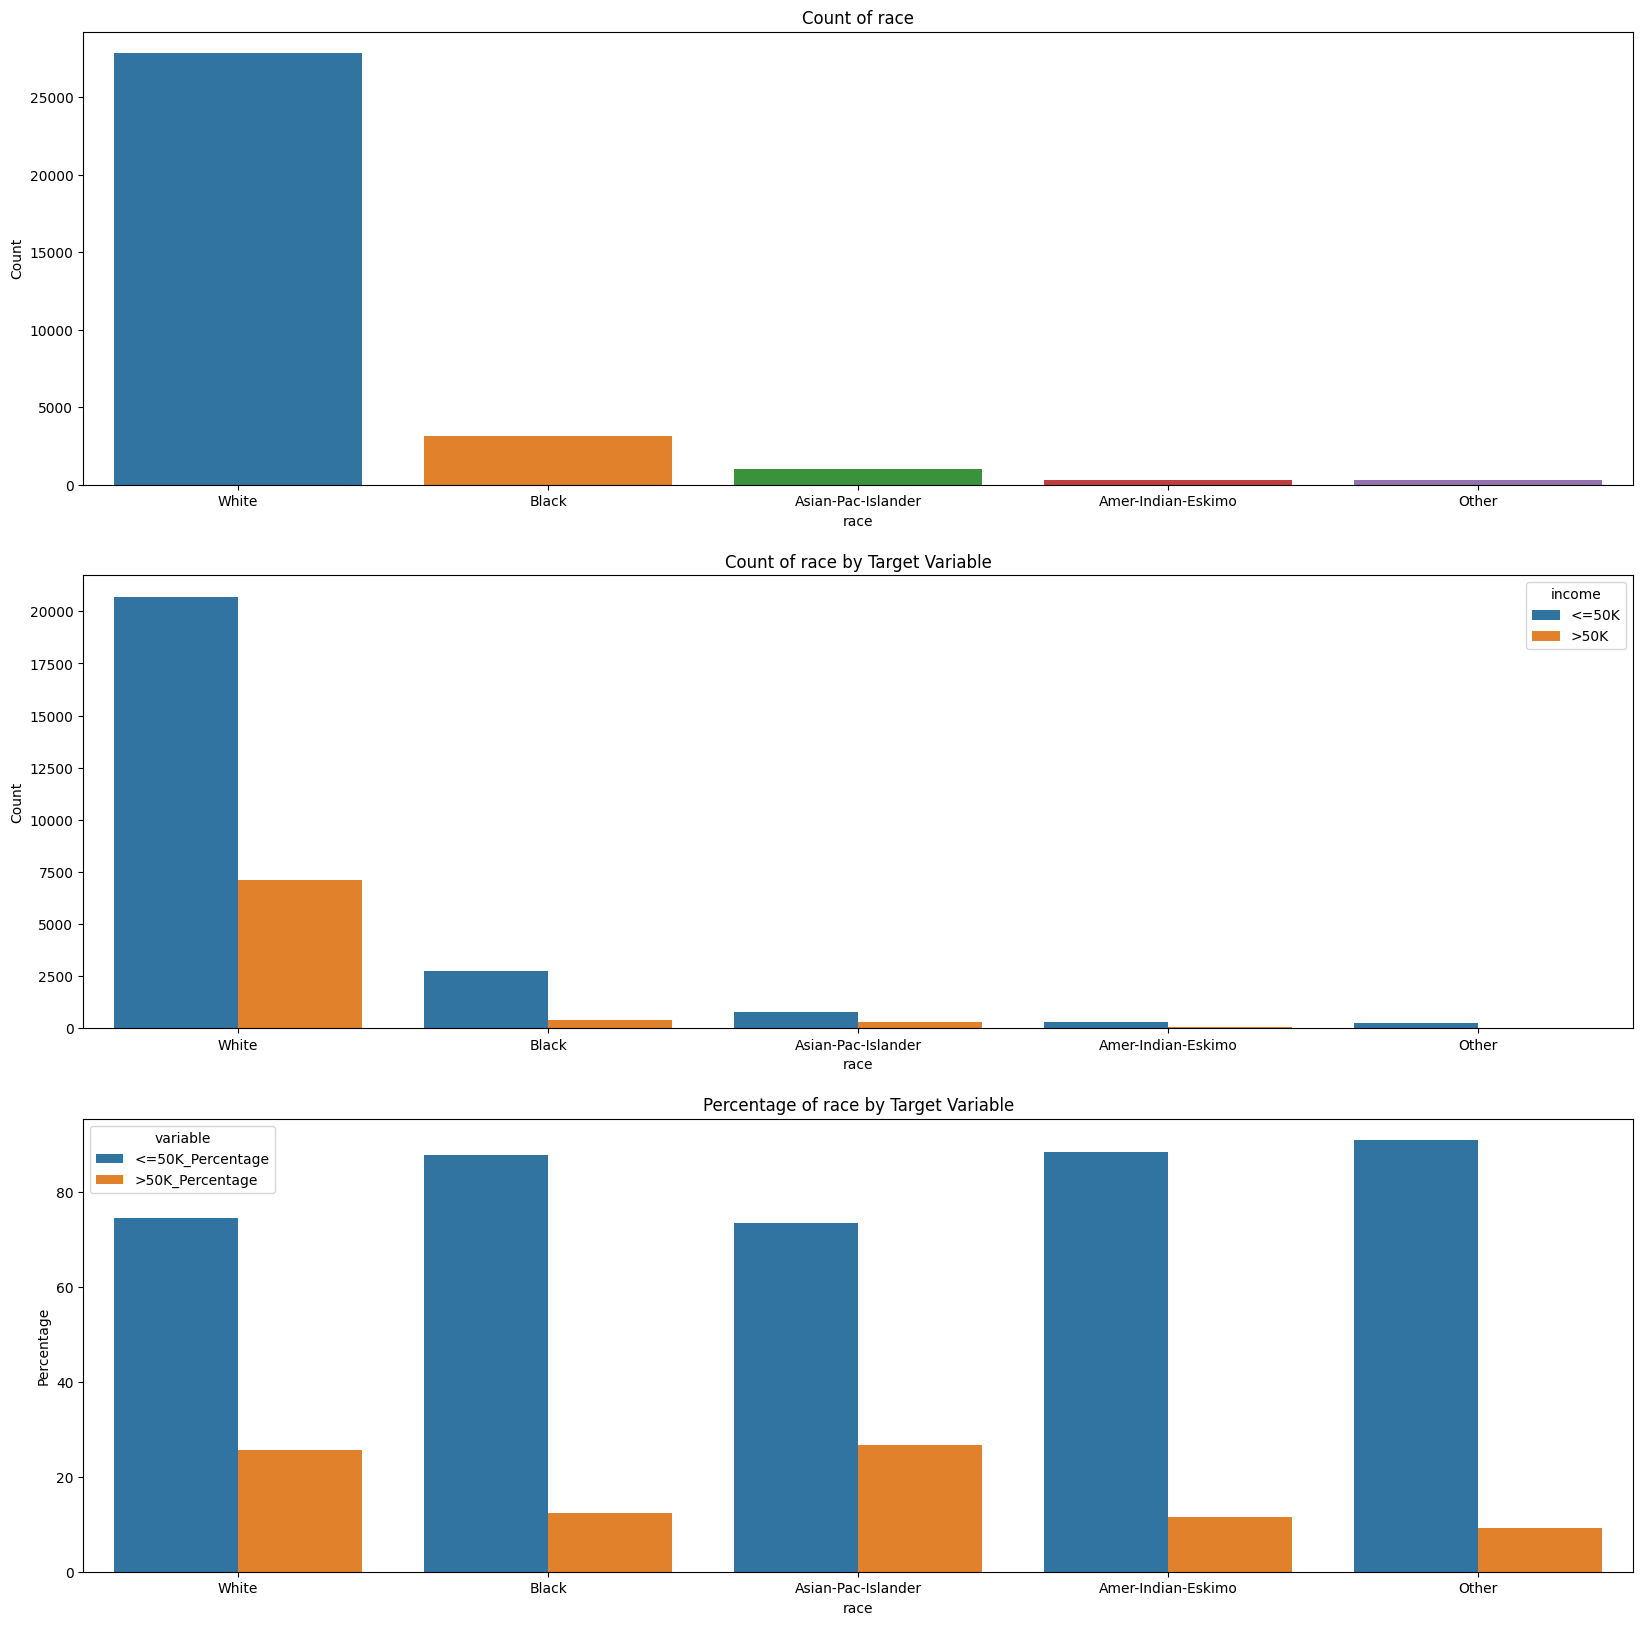

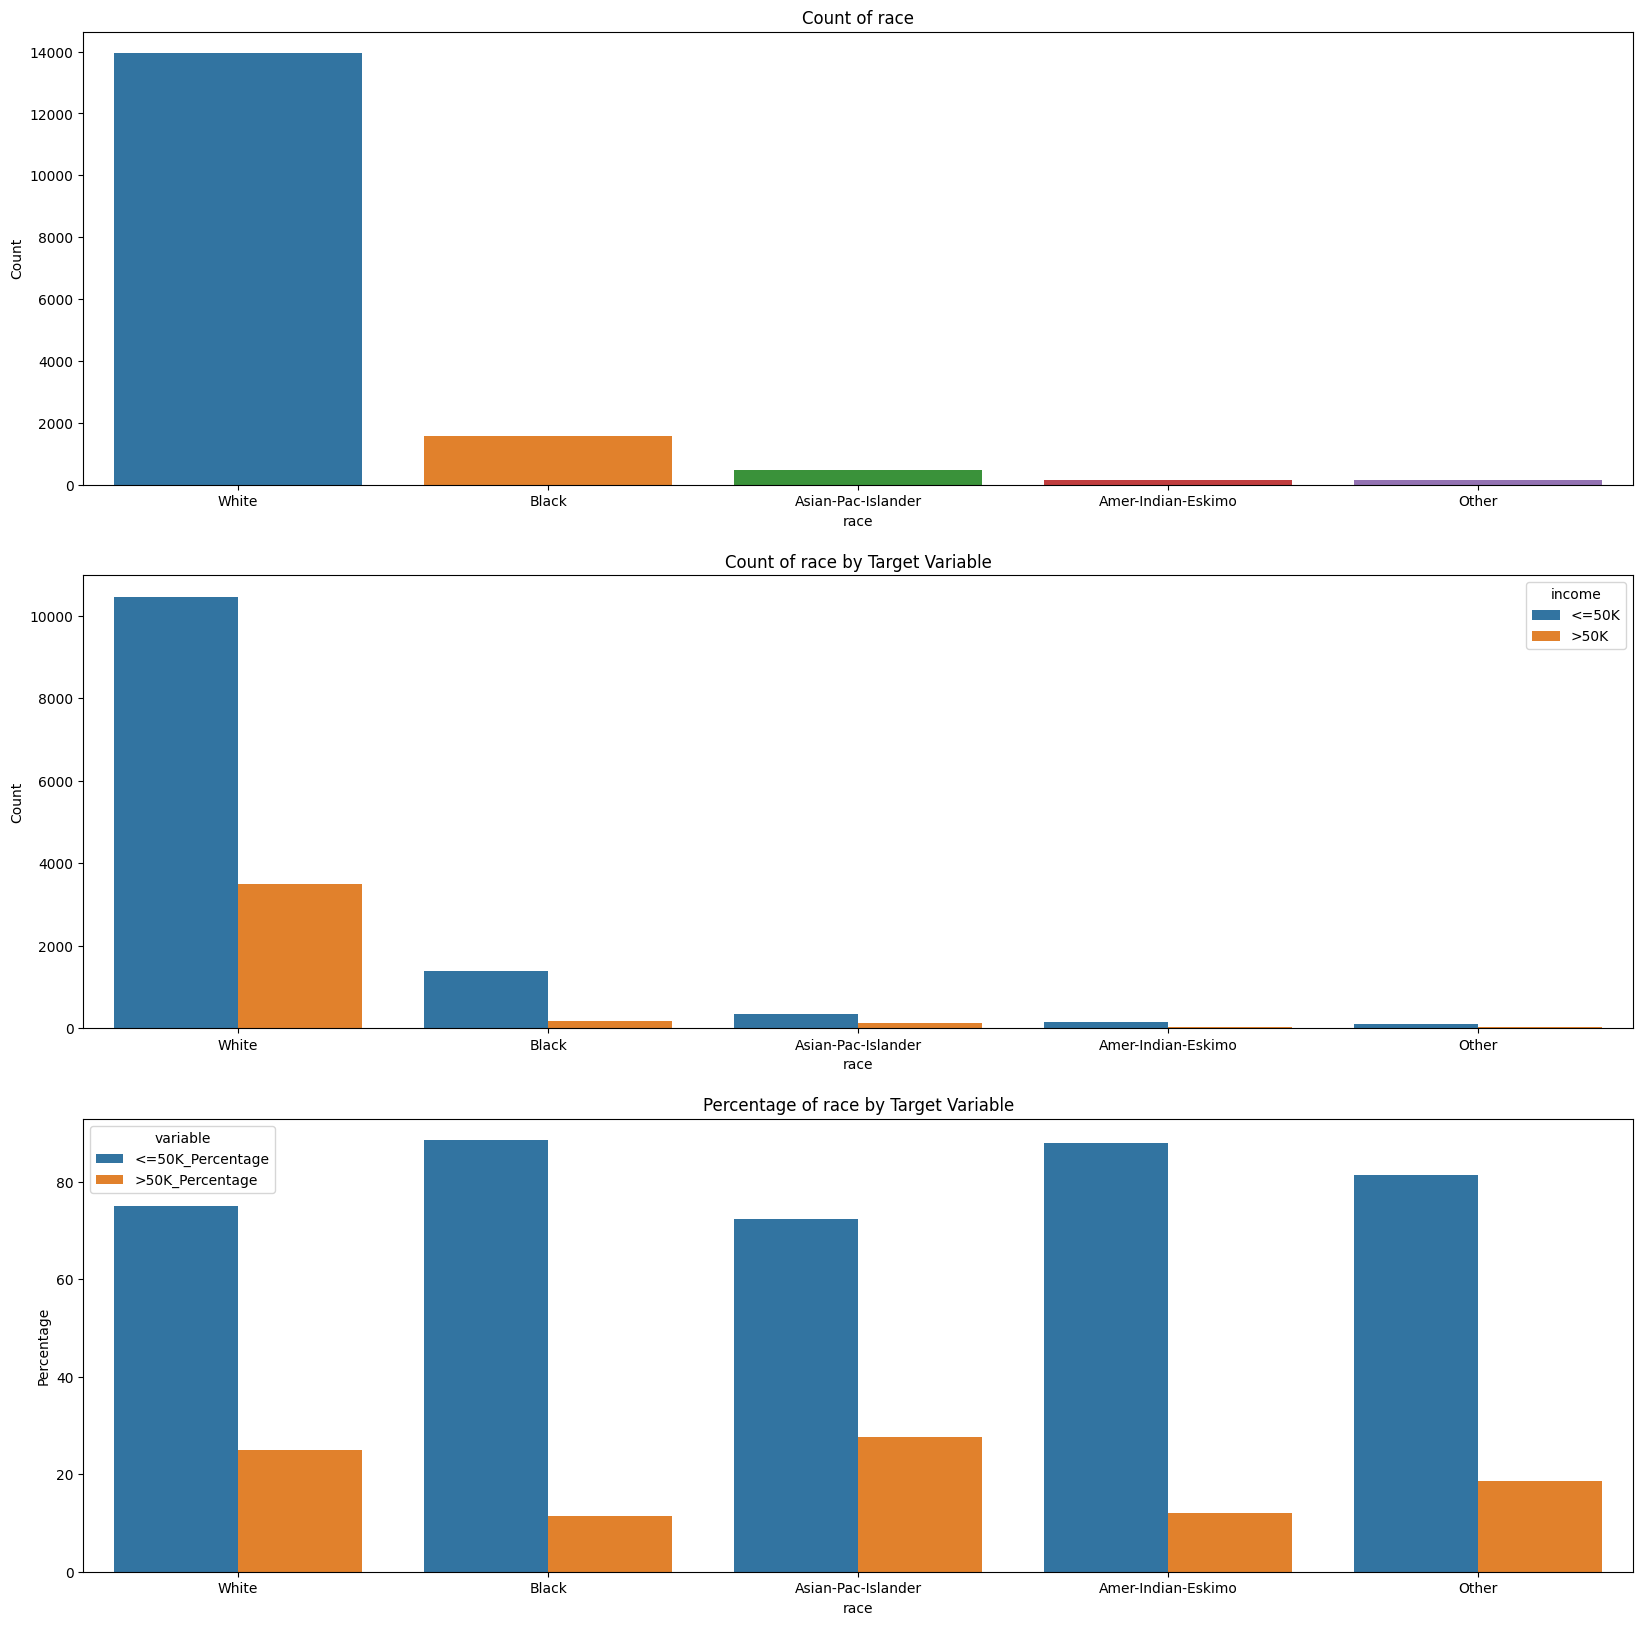

In [19]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'race')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'race')

##### race Insights: 
- Similar Distribution between training and testing
- Not that useful, as we have all races similar distribution between <=50K and >50K

#### sex: Nominal Categorical

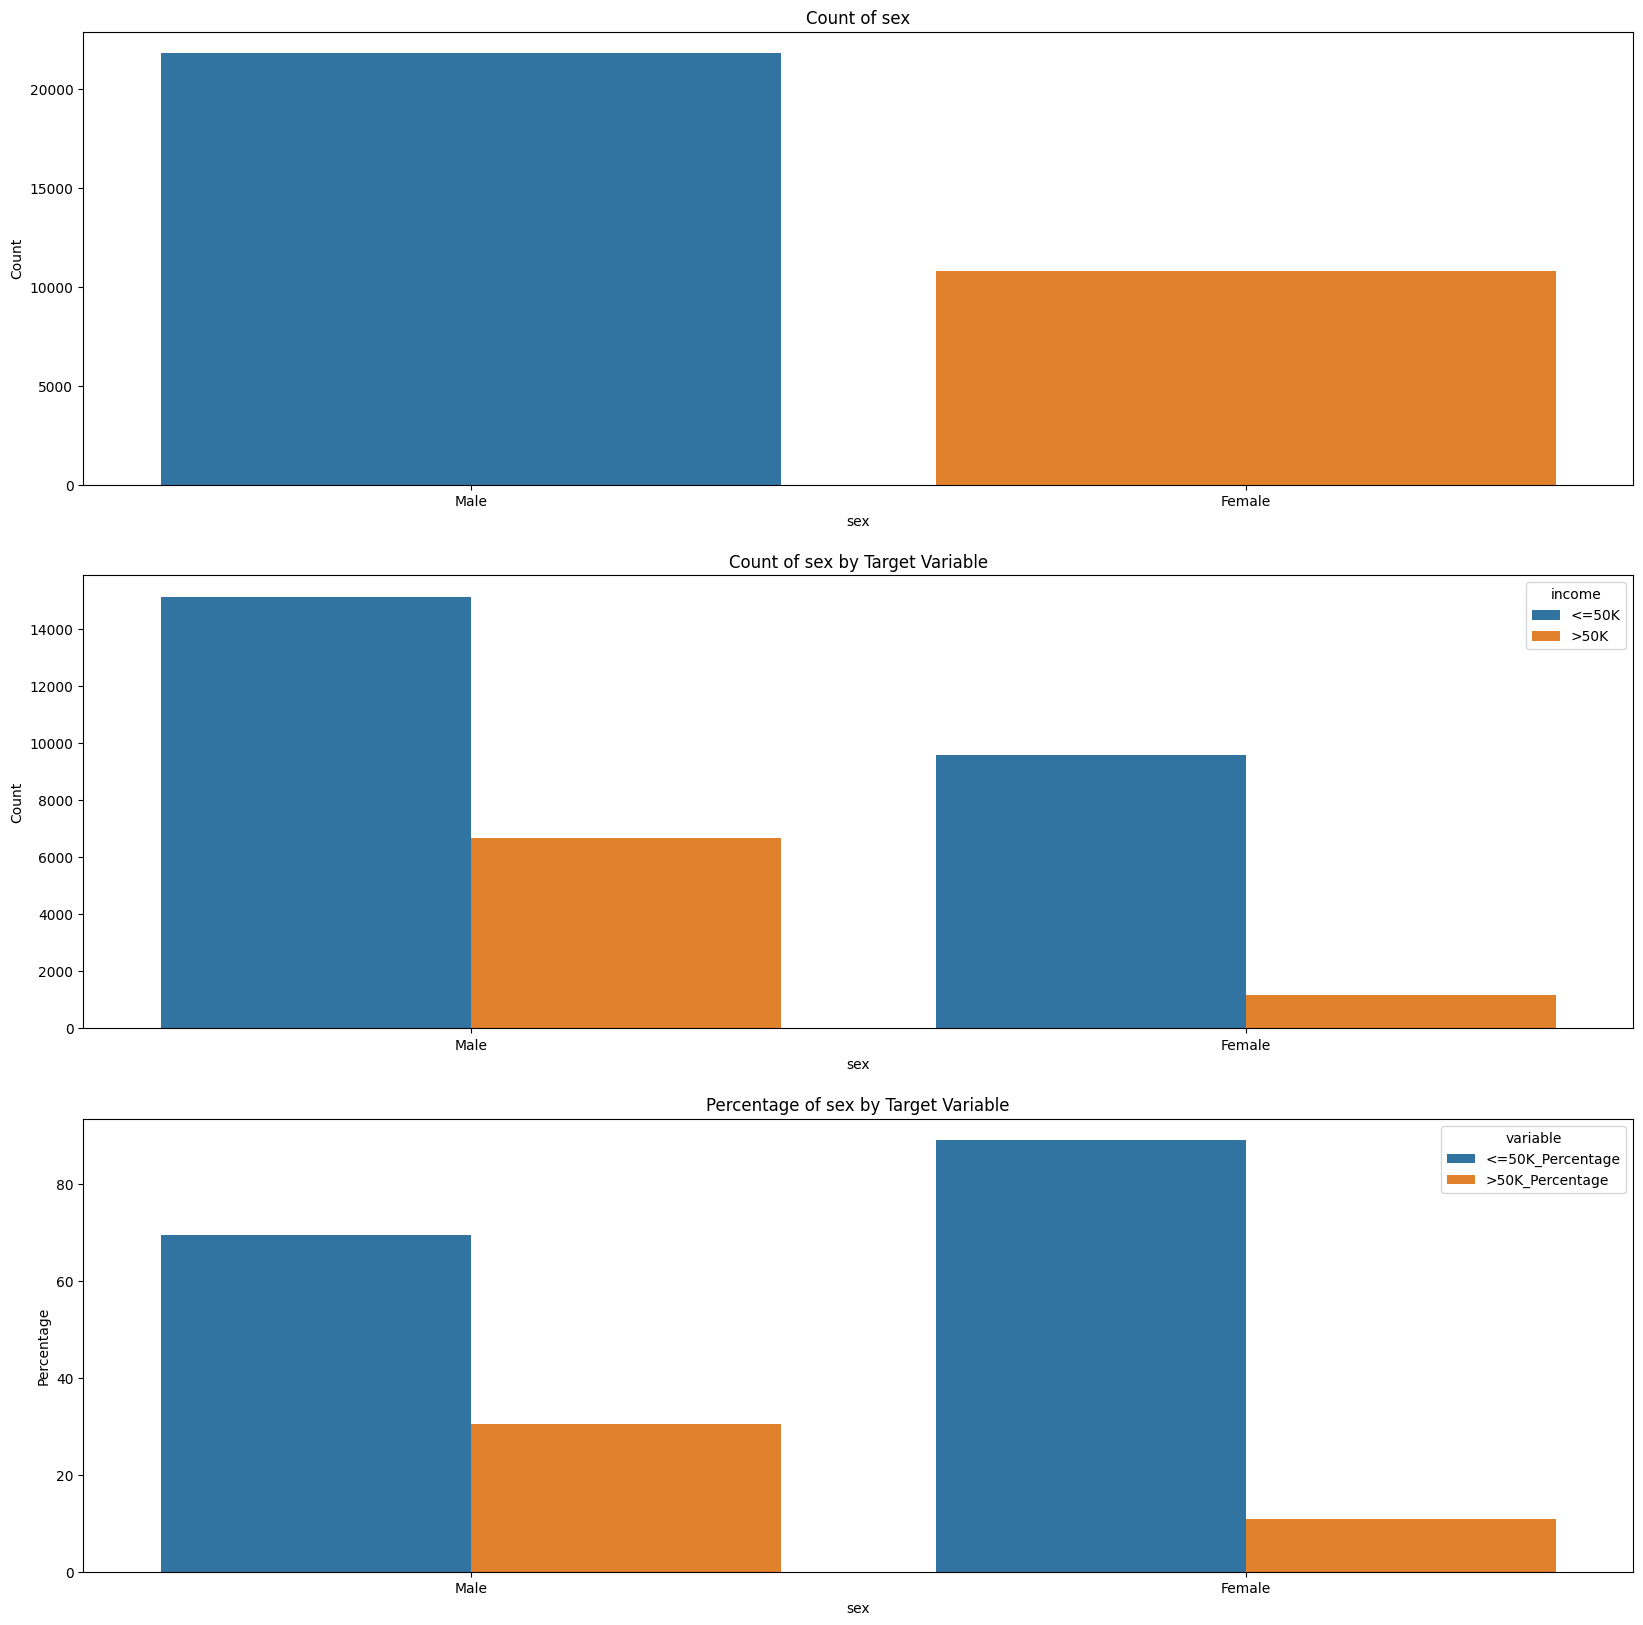

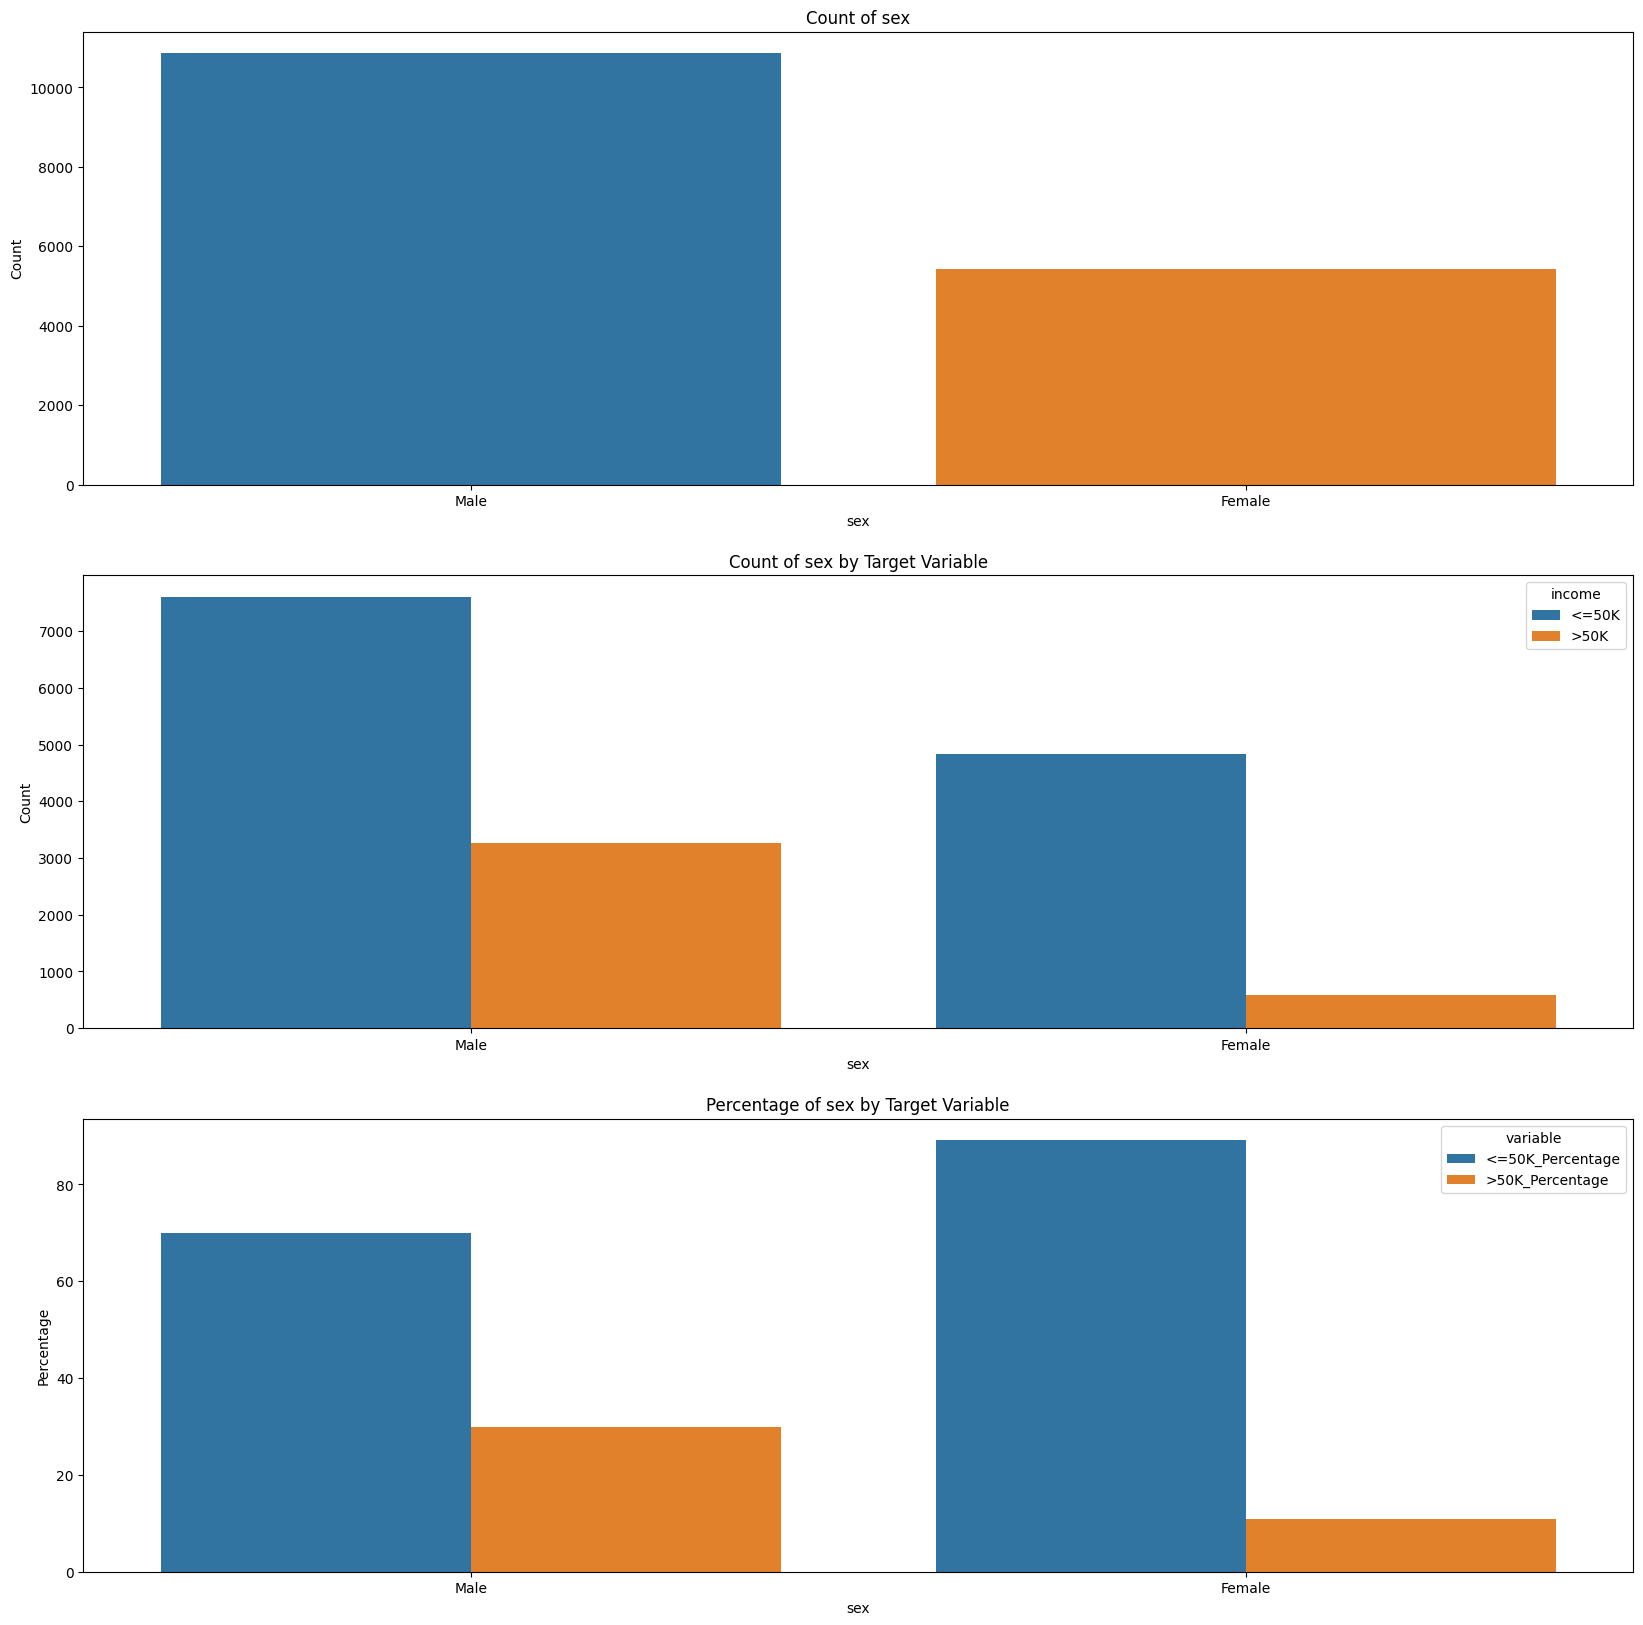

In [20]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'sex')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'sex')

##### Sex Insights: 
- Similar Distribution between training and testing
- Useful, as more men have > 50K

#### capital-gain: Continuous

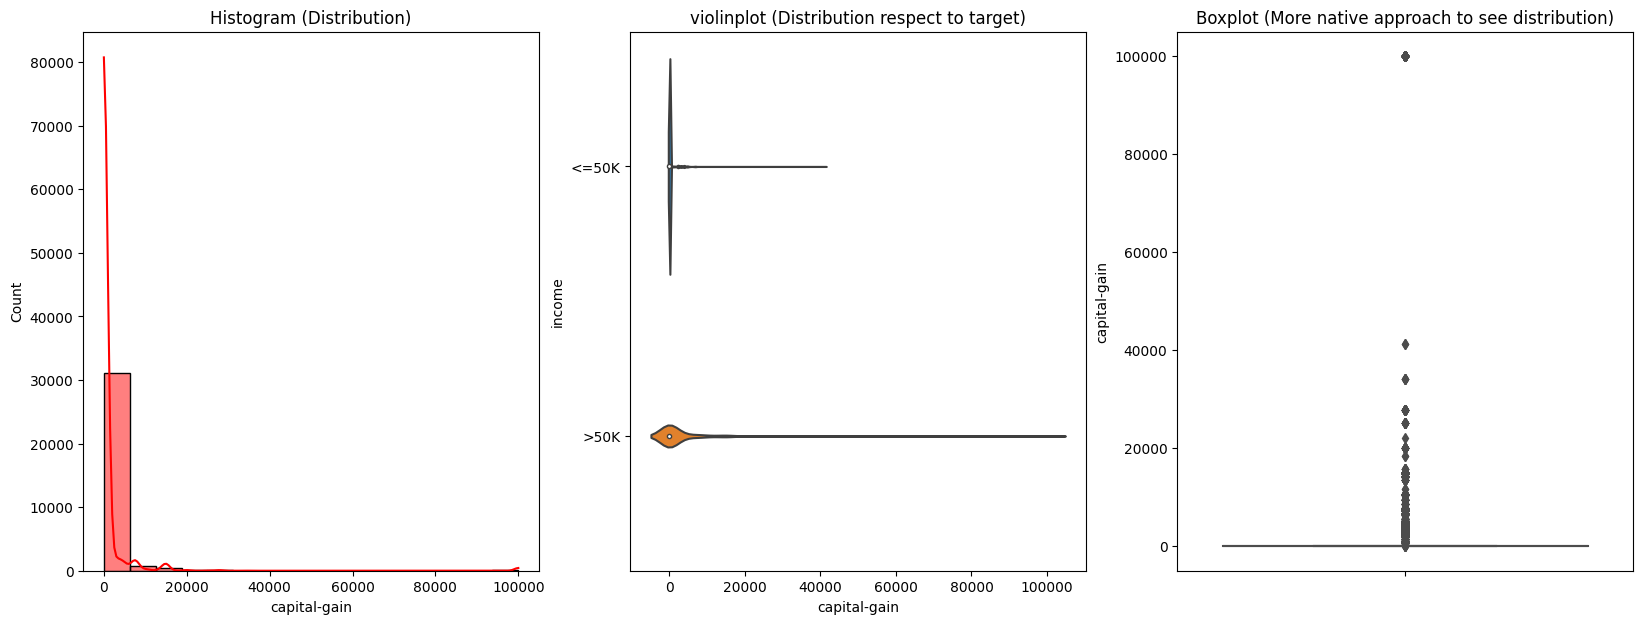

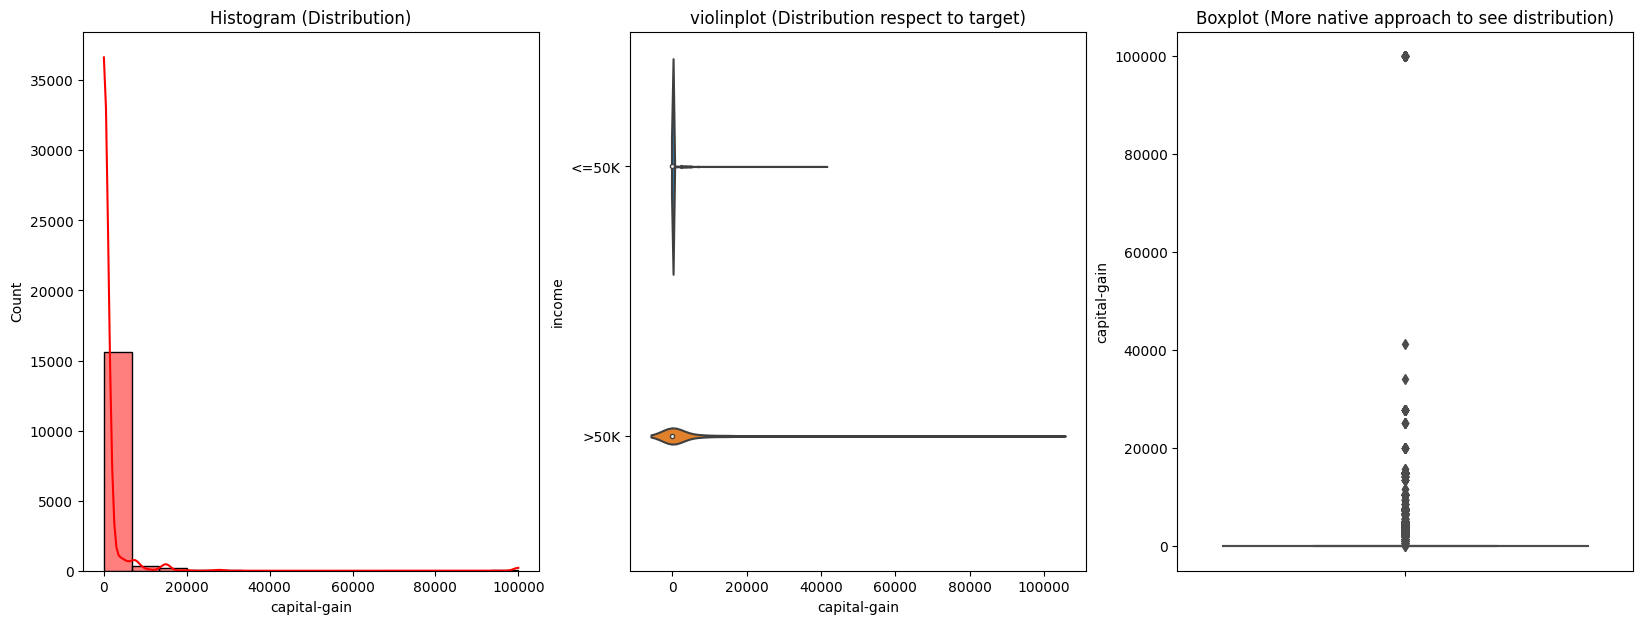

In [21]:
#train dataset
describe_continuous_dataset(adultsTrain, 'capital-gain')
#test dataset
describe_continuous_dataset(adultsTest, 'capital-gain')

##### capital-gain Insights: 
- Similar Distribution between training and testing
- Really does not give meaningful insight, and a lot of outliers

#### capital-loss: Continuous

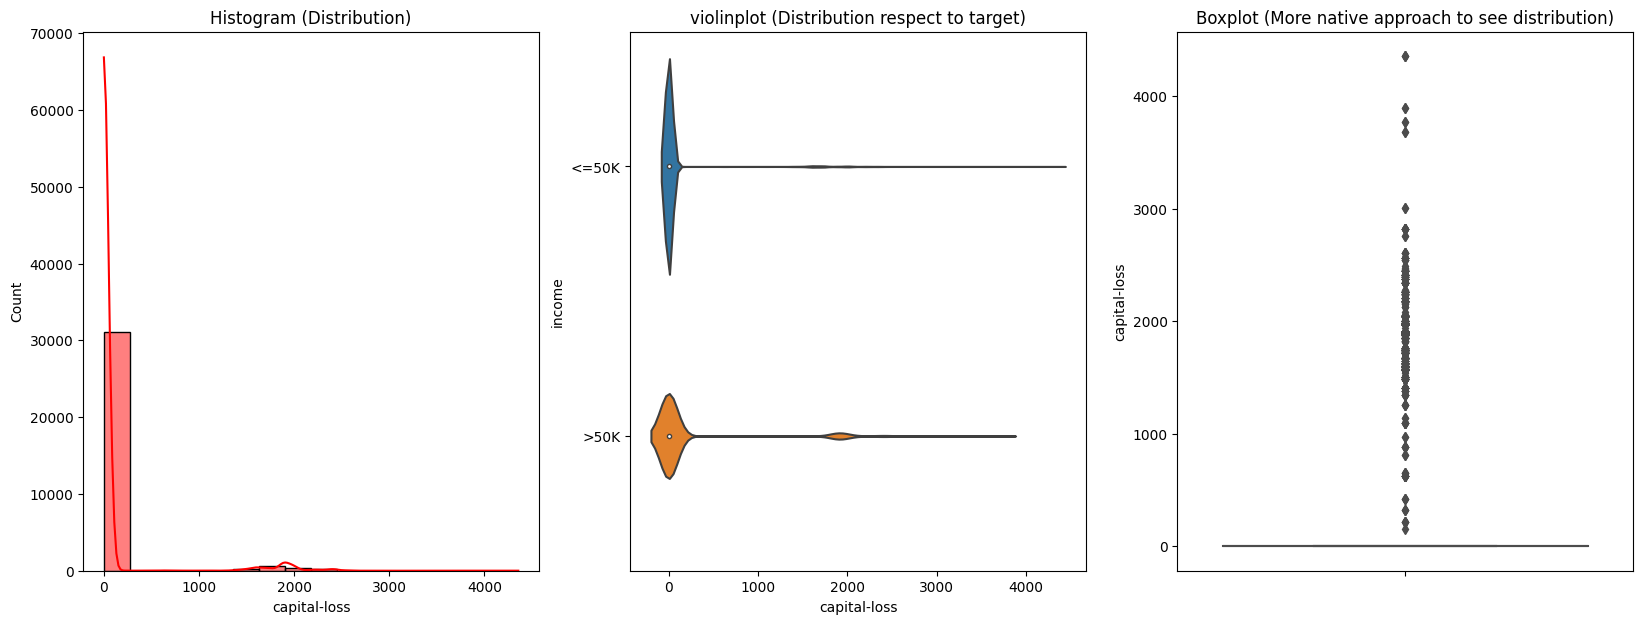

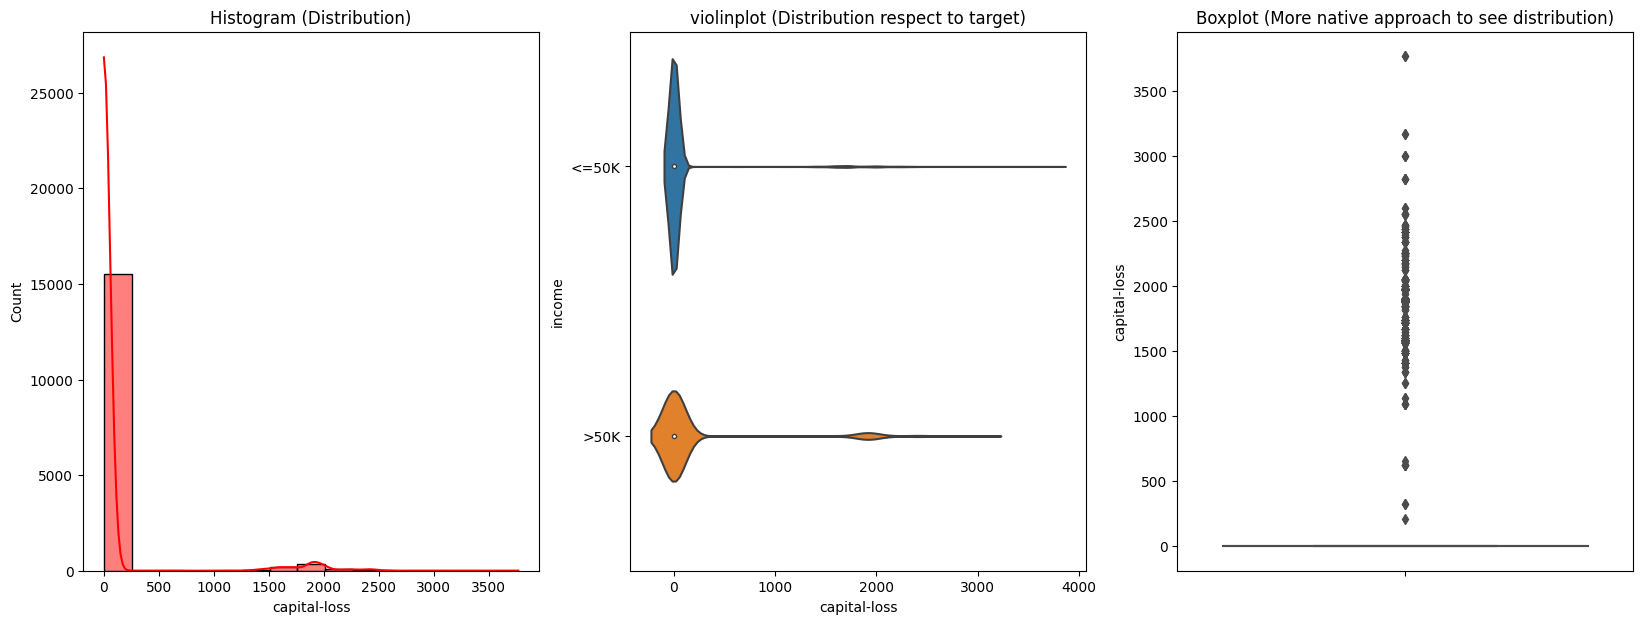

In [22]:
#train dataset
describe_continuous_dataset(adultsTrain, 'capital-loss')
#test dataset
describe_continuous_dataset(adultsTest, 'capital-loss')

##### capital-loss Insights: 
- Similar Distribution between training and testing
- Really does not give meaningful insight, and a lot of outliers

#### hours-per-week: Continuous

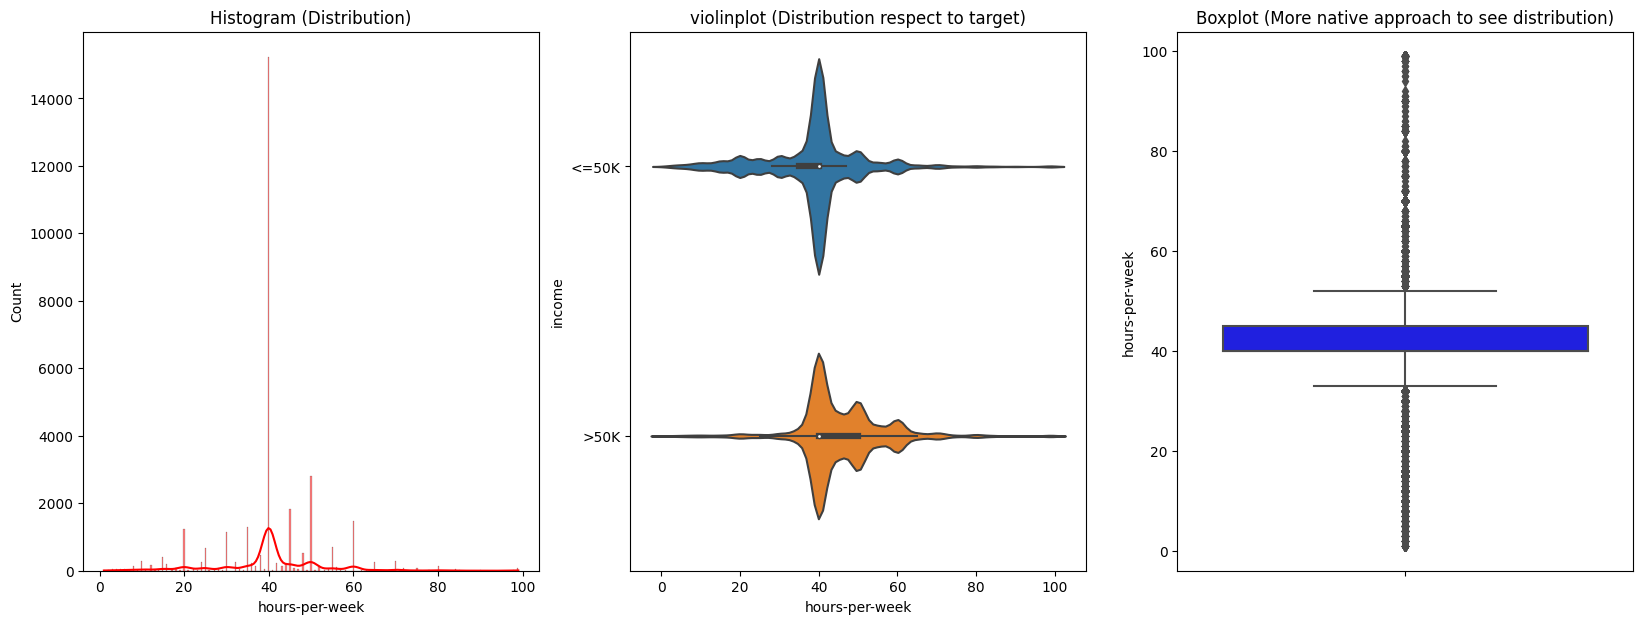

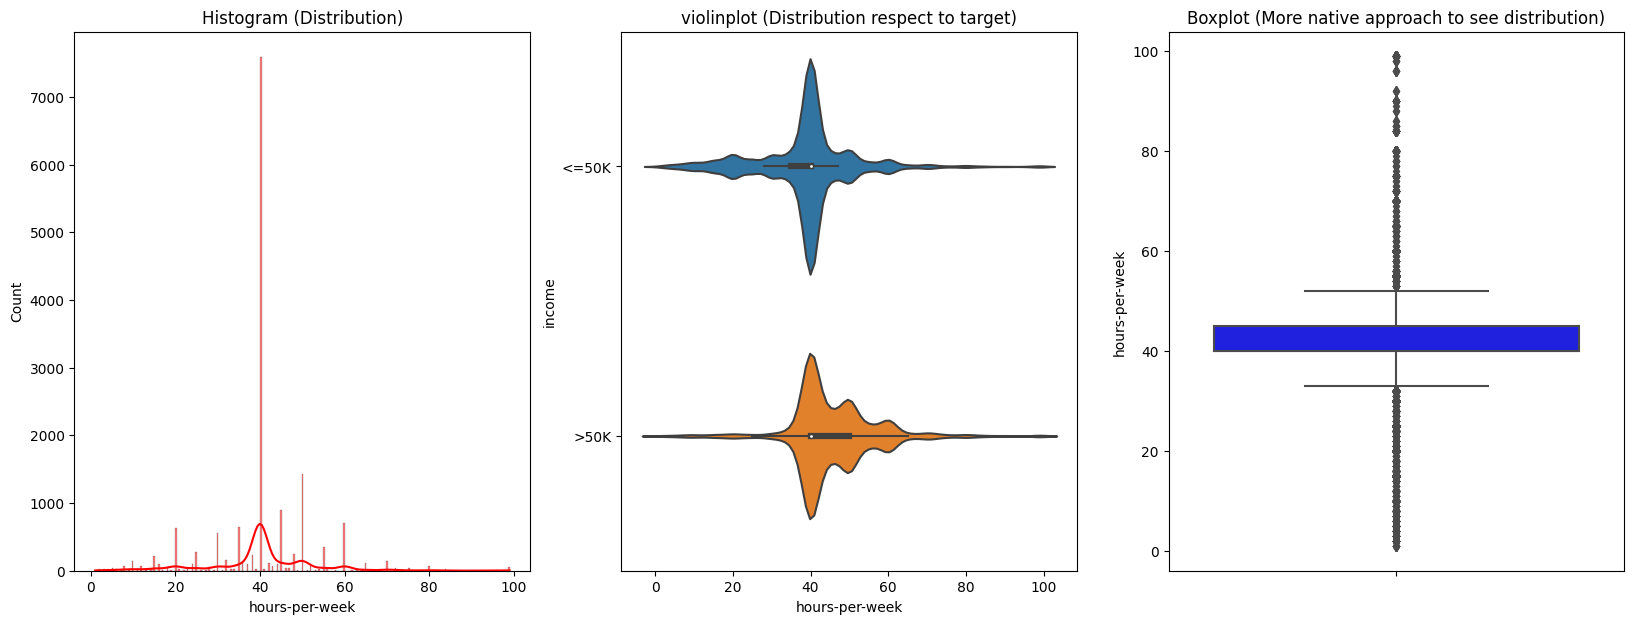

In [23]:
#train dataset
describe_continuous_dataset(adultsTrain, 'hours-per-week')
#test dataset
describe_continuous_dataset(adultsTest, 'hours-per-week')

##### hours-per-week Insights: 
- Similar Distribution between training and testing
- Really does not give meaningful insight, but at least better outliers compared to capital-loss and capital-gain

#### native-country: Nominal Categorical

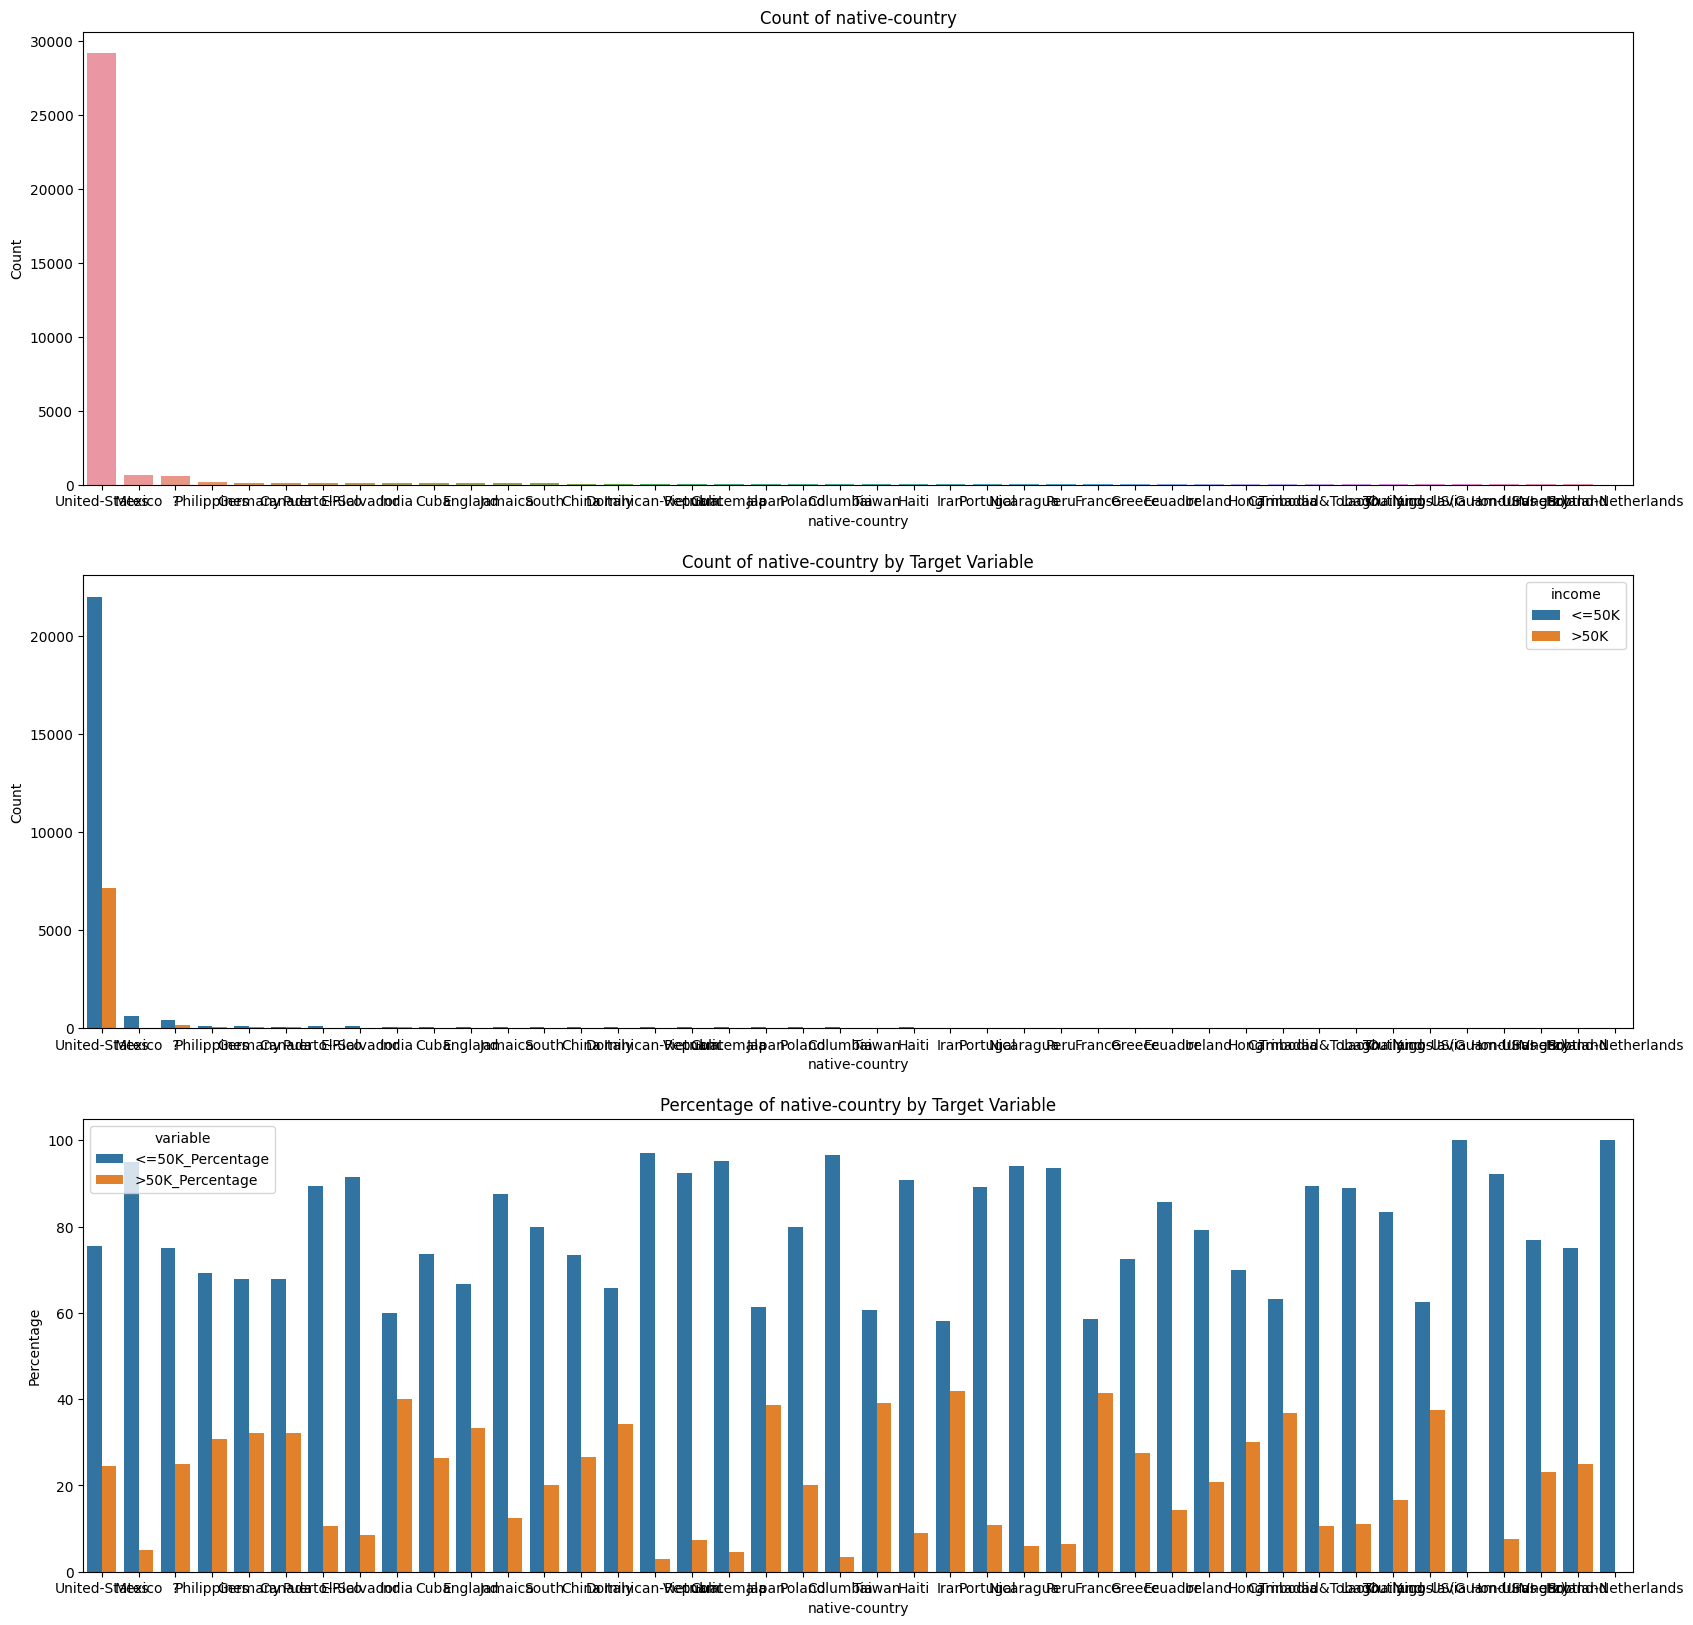

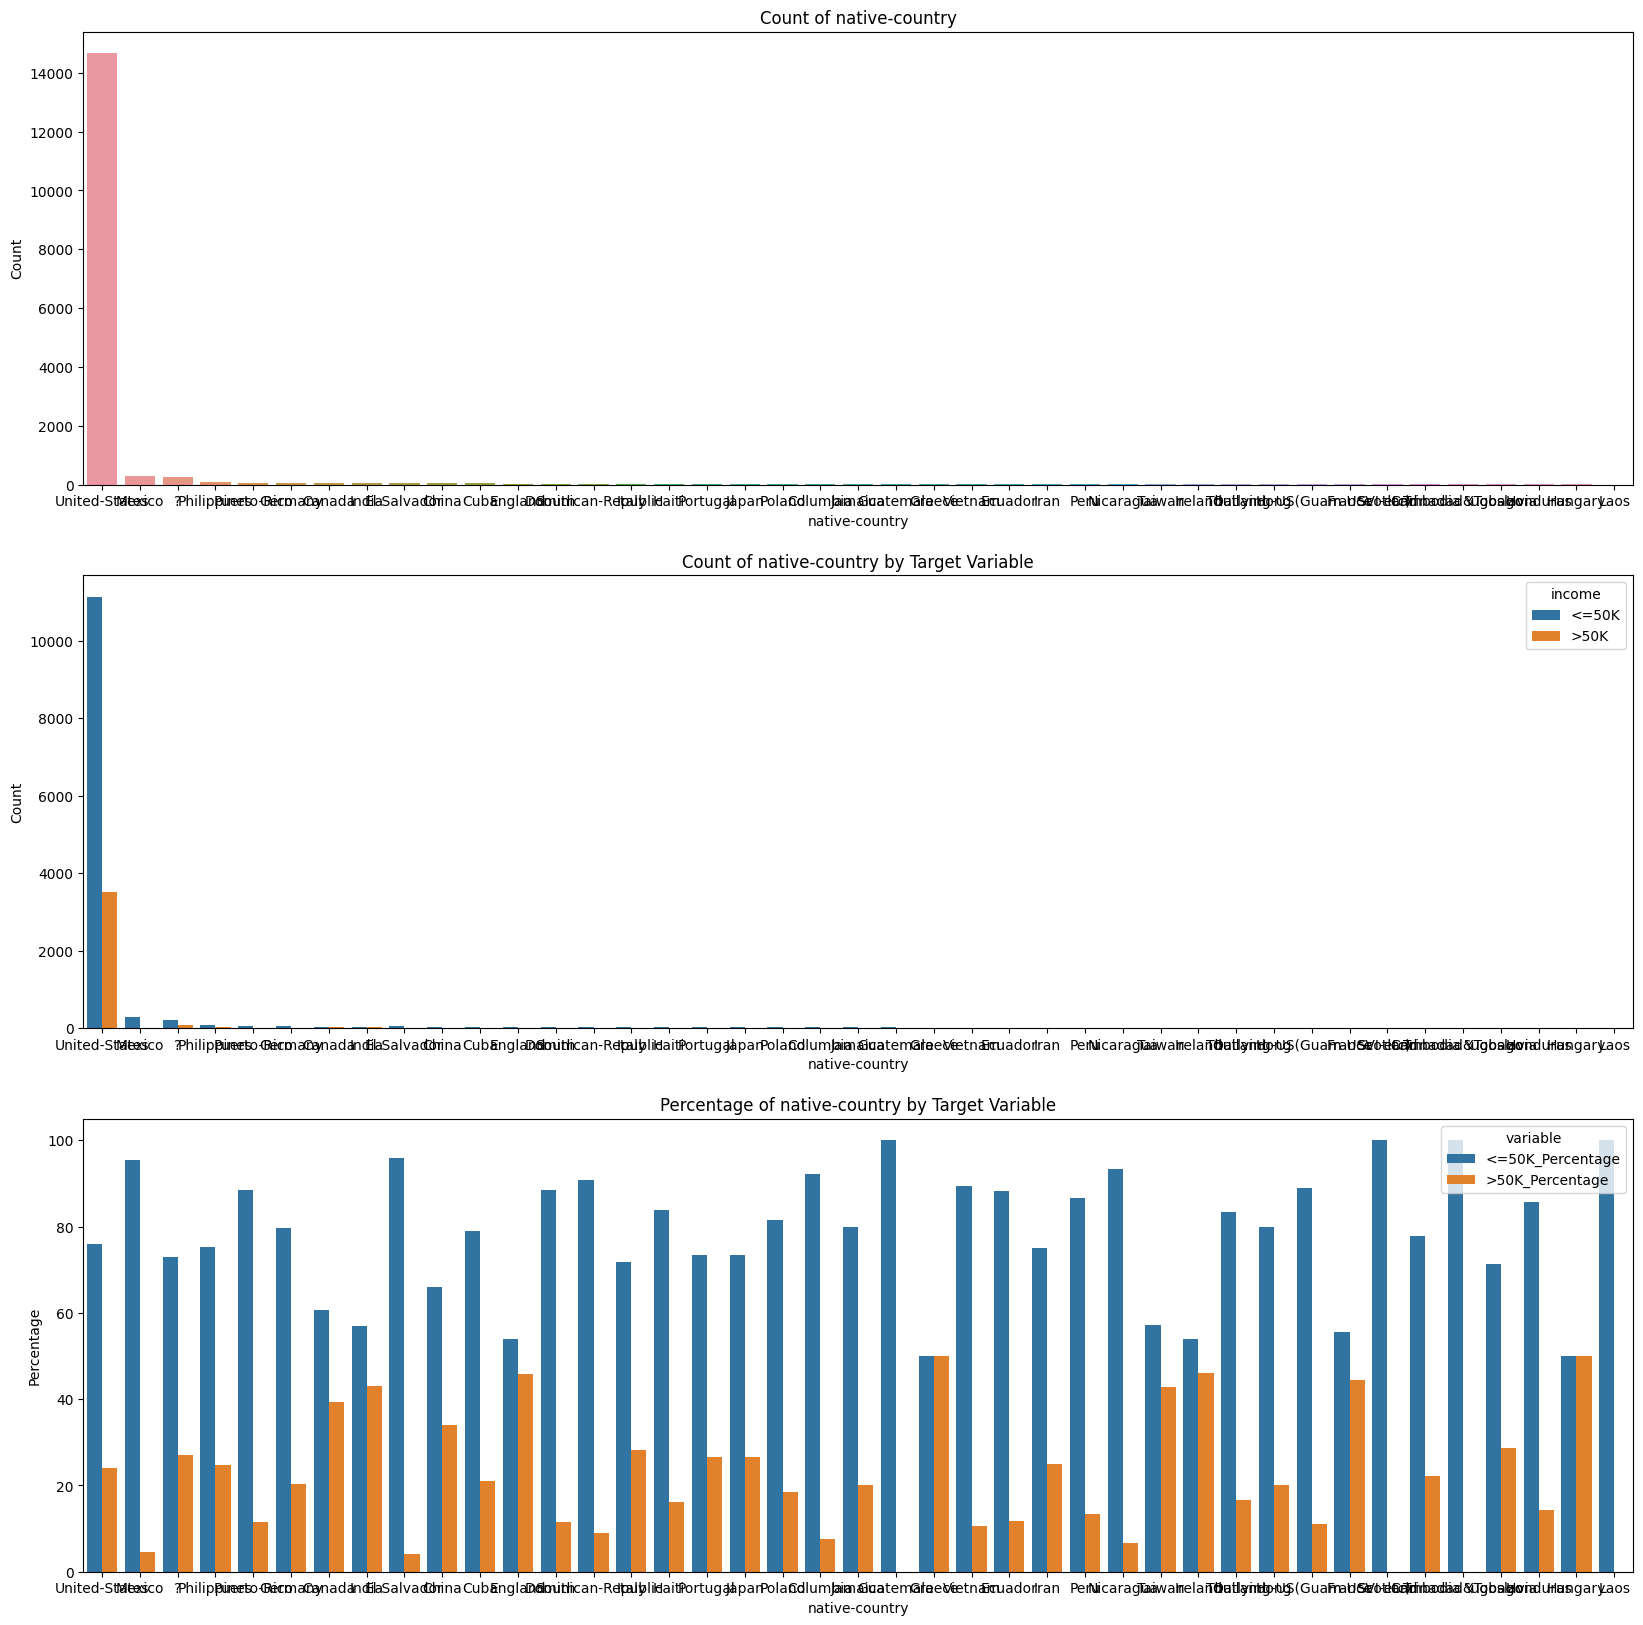

In [24]:
#train dataset
describe_nominal_categorical_dataset(adultsTrain, 'native-country')
#test dataset
describe_nominal_categorical_dataset(adultsTest, 'native-country')

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

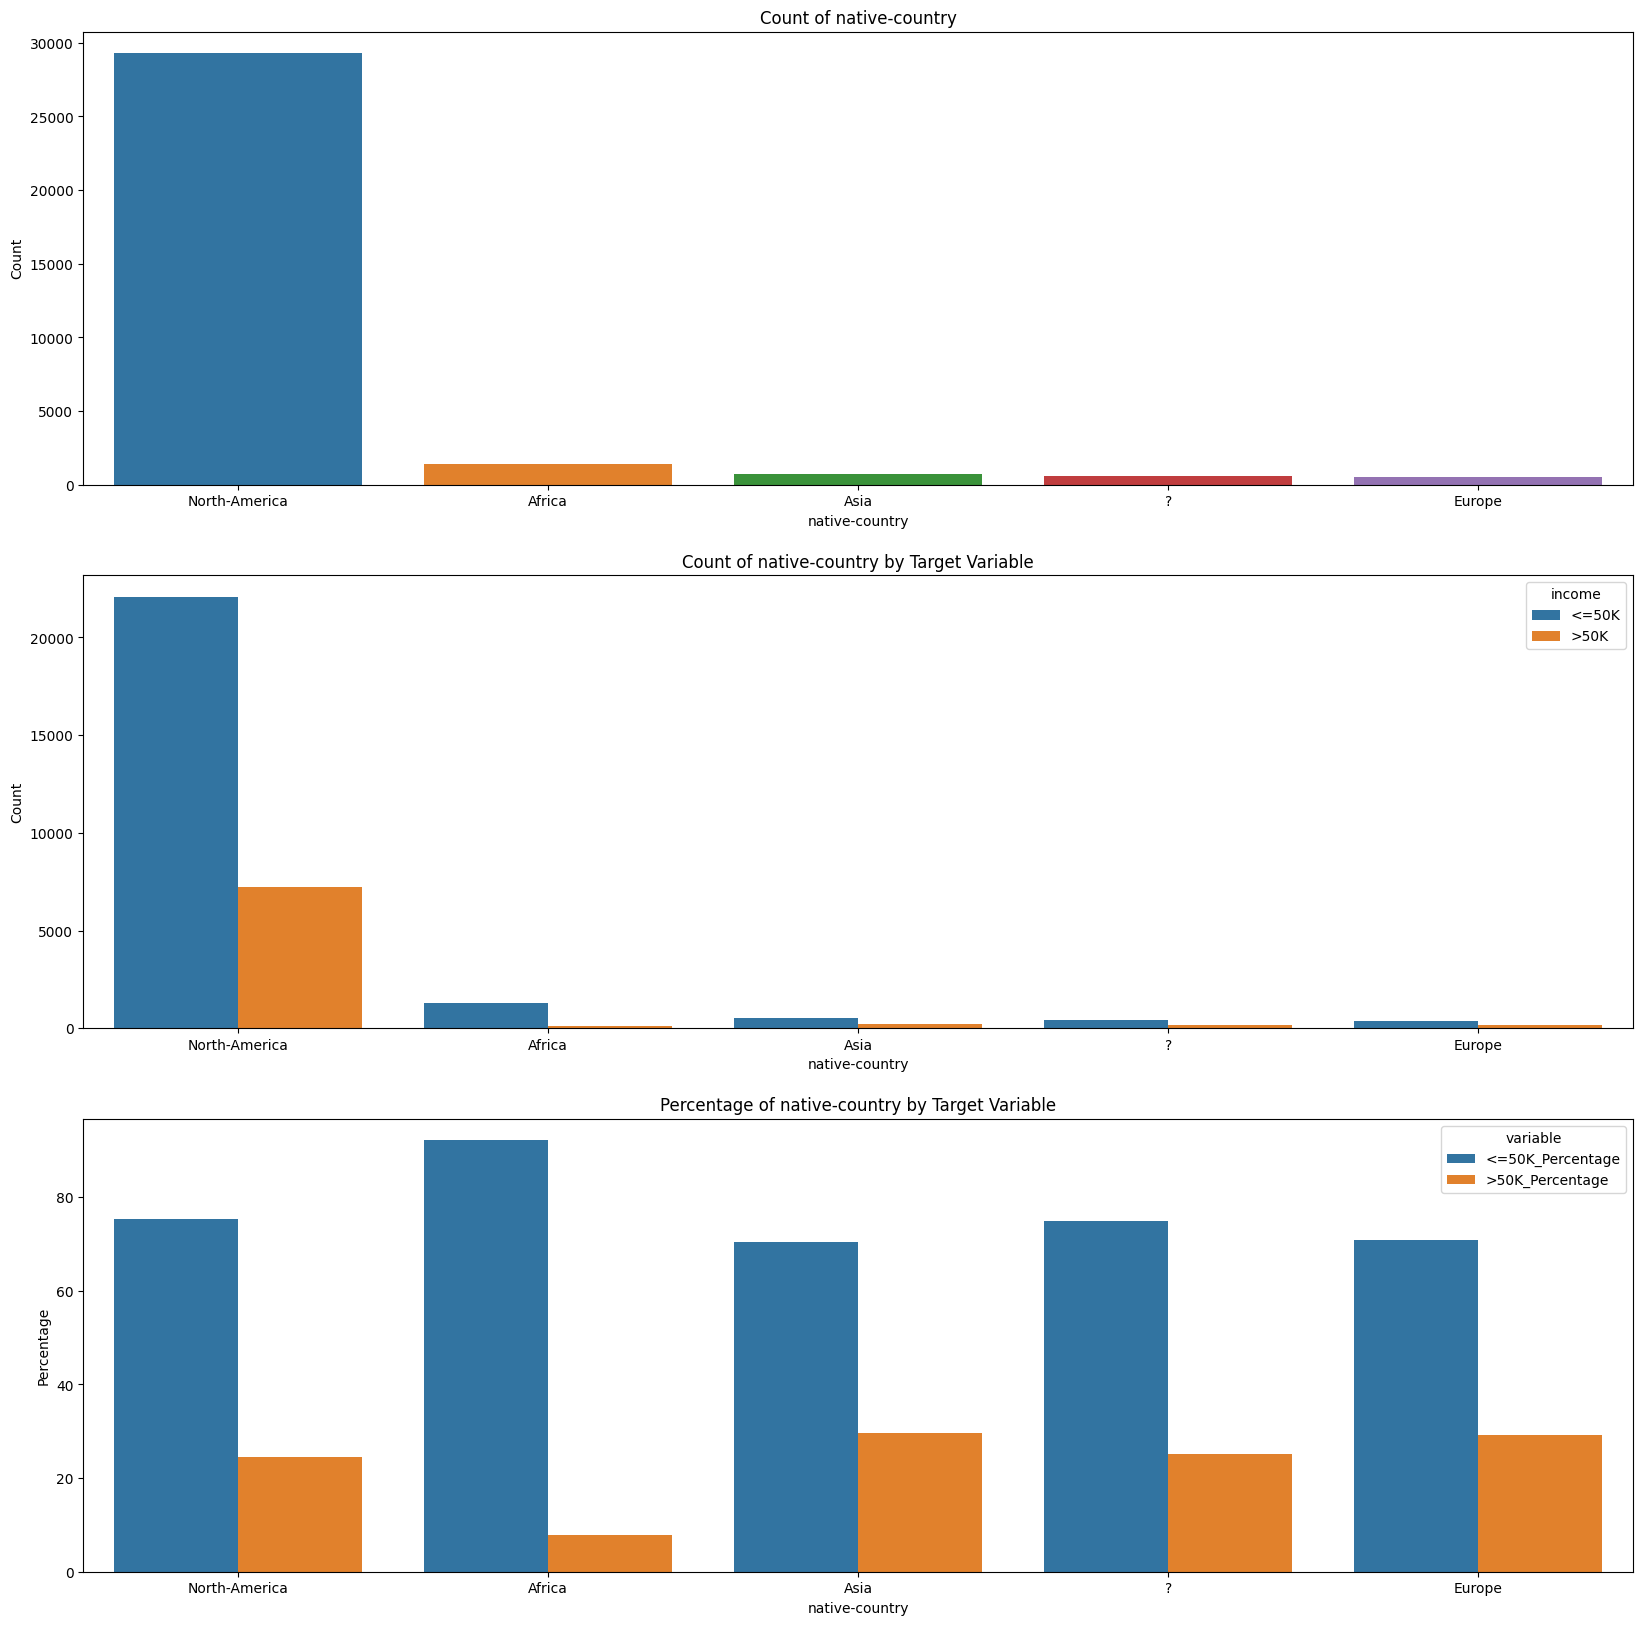

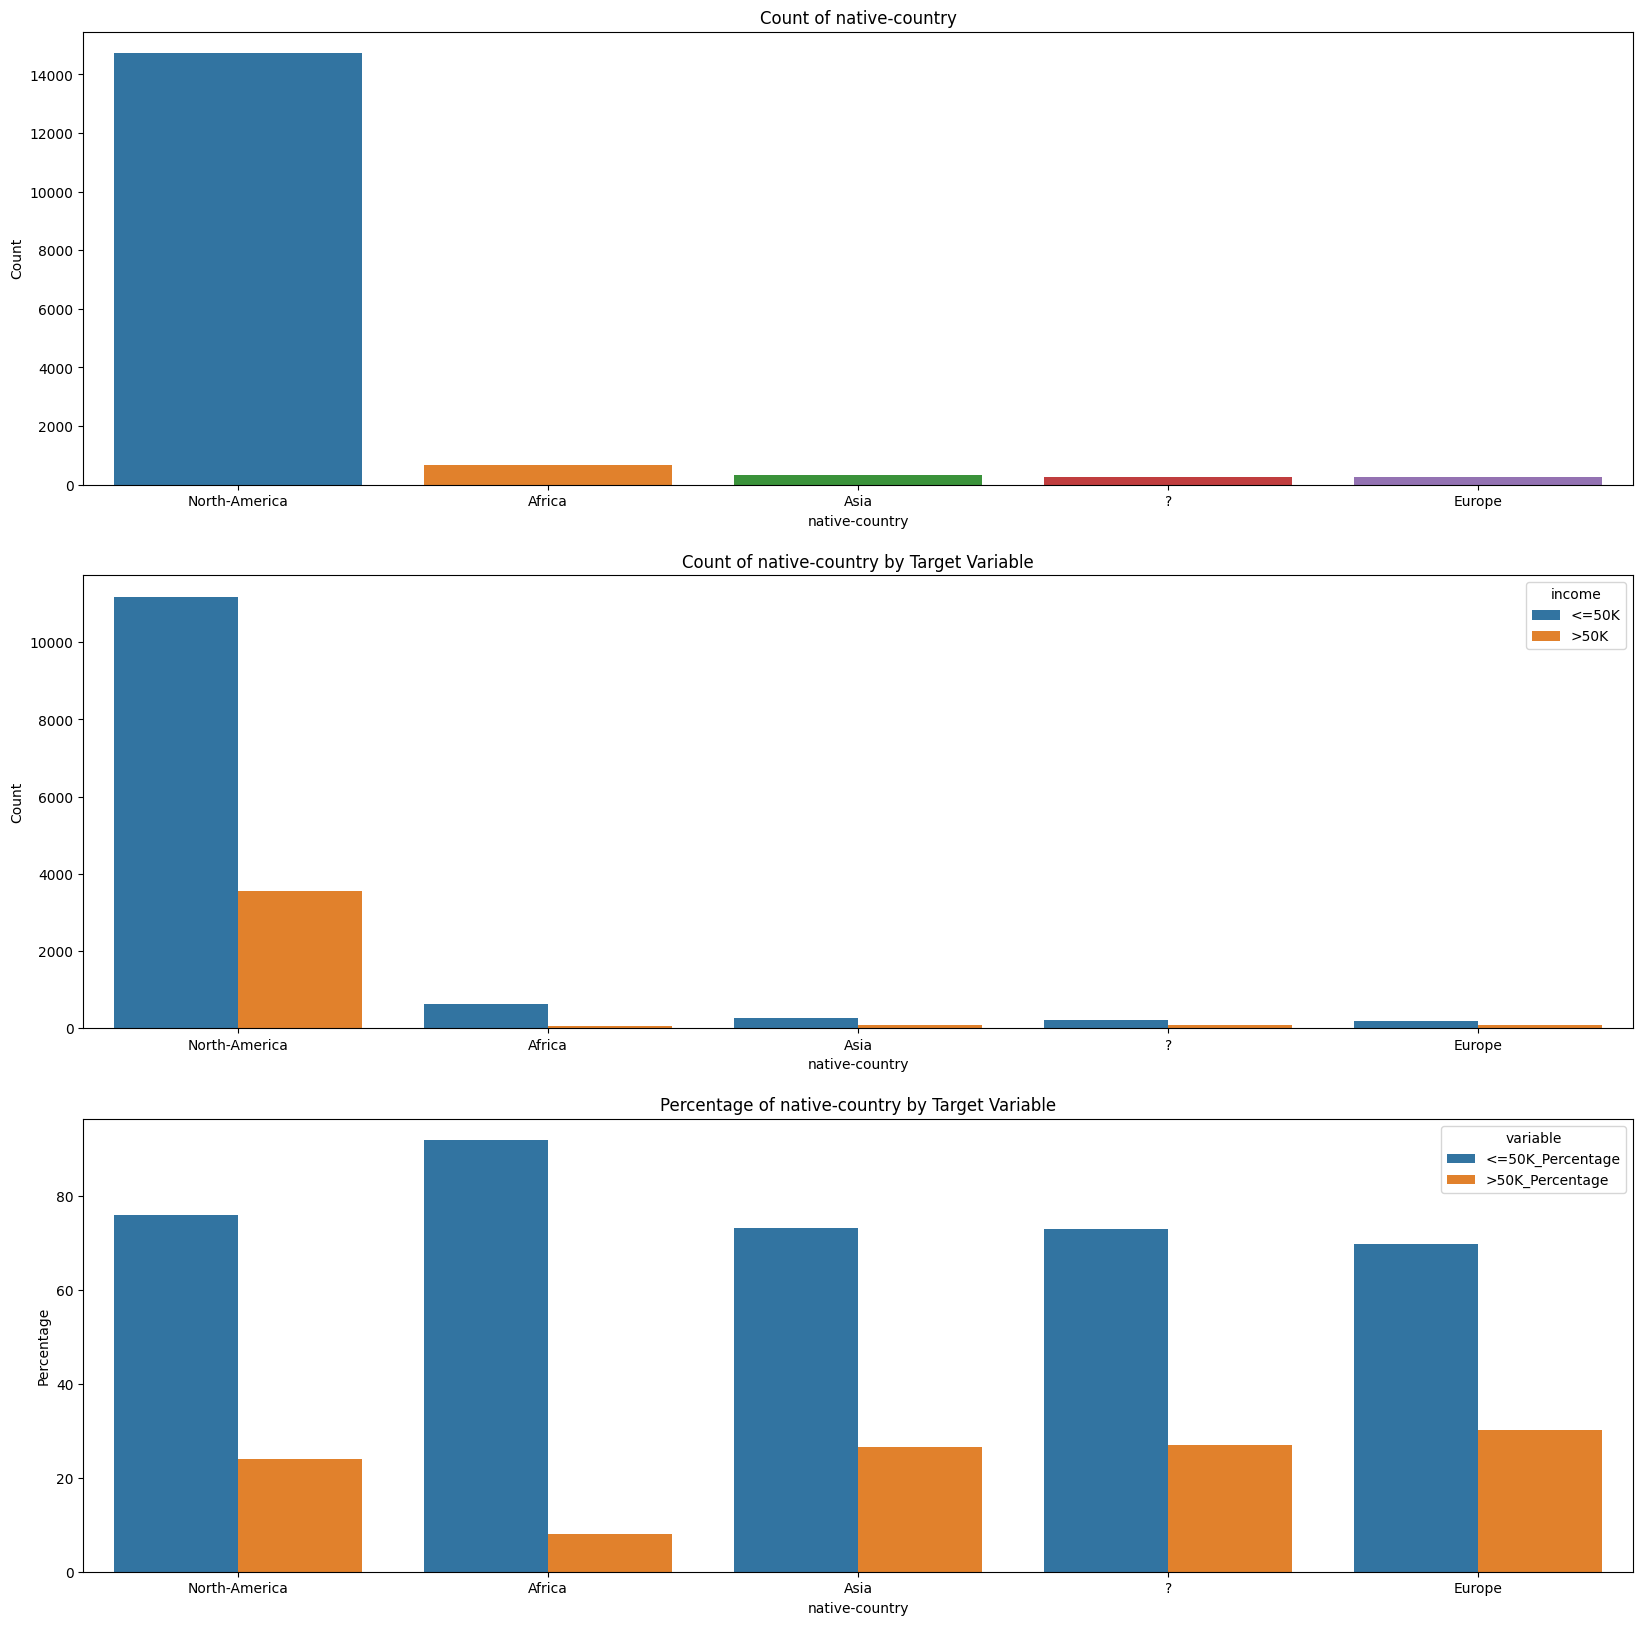

In [25]:
print(adultsTrain['native-country'].value_counts())
countryGrouping = {
    "North-America": ["United-States", "Canada"],
    "Asia": ["China", "India", "Japan", "Iran", "Philippines", "Vietnam", "Taiwan", "Hong", "Thailand", "Cambodia", "Laos", "South"],
    "Europe": ["Germany", "England", "Italy", "Poland", "France", "Greece", "Ireland", "Scotland", "Yugoslavia", "Hungary", "Portugal", "Holand-Netherlands"],
    "Africa":[ "Cuba", "Jamaica", "Mexico", "Puerto-Rico", "Honduras", "Columbia", "Ecuador", "Peru", "Nicaragua", "Dominican-Republic", "El-Salvador", "Guatemala", "Trinadad&Tobago", "Haiti", "Outlying-US(Guam-USVI-etc)"],
    "?": ["?"],
}
#create a new dataframe that converts the nations into the new value
adultsTrain2 = adultsTrain.copy()
adultsTest2 = adultsTest.copy()
for country, group in countryGrouping.items():
    adultsTrain['native-country'] = adultsTrain['native-country'].replace(group, country)
    adultsTest['native-country'] = adultsTest['native-country'].replace(group, country)
#print(adultsTrain2['native-country'].value_counts())
#print(adultsTest2['native-country'].value_counts())
describe_nominal_categorical_dataset(adultsTrain, 'native-country')
describe_nominal_categorical_dataset(adultsTest, 'native-country')

##### native-country Insights: 
- Similar Distribution between training and testing
- While some country such as Mexico, might give meaningful information where most of them <50K, but some are also not that useful

### Conclusion
- There is imbalance in target variable, consider using class_weights
- Highly correlated variables like education and education-num can be selected one, I might select education-num due to sklearn decision tree is better with continuous variable
- Some variables are indeed can give a really meaningful direct information (high importance), some might give a new insight (medium importance), and some not that meaningful (low importance)
    - high importance:  age, workclass (missing value), education-num, marital status (needs to be grouped), occupation (missing value), relationship, sex
    - medium importance: race, hours per week, nation
    - low importance: fnlwgt, capital gain, capital loss

- sklearn does not support missing value imputation that is exclusive to Decision Tree, which are implemented in CART algorithms. So, we use more traditional approach for this
    - Test dataset: Since all of the missing values are nominal categorical, use "Mode" imputation
    - Train dataset: Two trial, using "Mode" and using "Mean"
- Since we are using Decision Tree, our models are more robust to outliers, "duplicate feature", and low importance features
    - but if we already know explicitly that two duplicate feature are of high correlation, just discard it
    - same does with low importance feature

# Dataset Preparation

In [26]:
train_data_all = adultsTrain.copy()
test_data_all = adultsTest.copy()

#impute the empty values using mode
train_data_all['workclass'].replace('?', train_data_all['workclass'].mode()[0], inplace=True)
train_data_all['occupation'].replace('?', train_data_all['occupation'].mode()[0], inplace=True)
train_data_all['native-country'].replace('?', train_data_all['native-country'].mode()[0], inplace=True)
test_data_all['workclass'].replace('?', train_data_all['workclass'].mode()[0], inplace=True)
test_data_all['occupation'].replace('?', train_data_all['occupation'].mode()[0], inplace=True)
test_data_all['native-country'].replace('?', train_data_all['native-country'].mode()[0], inplace=True)

#since we have education similar to that of education-num, we will drop education
train_data_all.drop(['education'], axis=1, inplace=True)
test_data_all.drop(['education'], axis=1, inplace=True)


#handle the strings with label encoders
categorical_variables = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race']
for column in categorical_variables:
    label_encoder = LabelEncoder()
    train_data_all[column] = label_encoder.fit_transform(train_data_all[column])
    test_data_all[column] = label_encoder.transform(test_data_all[column])
    
    label_mapping = {original: encoded for encoded, original in enumerate(label_encoder.classes_)}
    print(f"{column}: ", label_mapping)

# print(train_data_all.isin(['?']).sum().sum()) #no more empty values
# print(test_data_all.isin(['?']).sum().sum()) #no more empty values
# print(train_data_all.head())


workclass:  {'Federal-gov': 0, 'Local-gov': 1, 'Never-worked': 2, 'Private': 3, 'Self-emp-inc': 4, 'Self-emp-not-inc': 5, 'State-gov': 6, 'Without-pay': 7}
marital-status:  {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
occupation:  {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}
relationship:  {'Husband': 0, 'Not-in-family': 1, 'Other-relative': 2, 'Own-child': 3, 'Unmarried': 4, 'Wife': 5}
sex:  {'Female': 0, 'Male': 1}
native-country:  {'Africa': 0, 'Asia': 1, 'Europe': 2, 'North-America': 3}
race:  {'Amer-Indian-Eskimo': 0, 'Asian-Pac-Islander': 1, 'Black': 2, 'Other': 3, 'White': 4}


In [27]:
#another dataset with discarded columns
discard_columns = ['education', 'fnlwgt', 'capital-gain', 'capital-loss']
train_data_discard = adultsTrain.copy().drop(discard_columns, axis=1)
test_data_discard = adultsTest.copy().drop(discard_columns, axis=1)

#impute also the empty values
train_data_discard['workclass'].replace('?', train_data_discard['workclass'].mode()[0], inplace=True)
train_data_discard['occupation'].replace('?', train_data_discard['occupation'].mode()[0], inplace=True)
train_data_discard['native-country'].replace('?', train_data_discard['native-country'].mode()[0], inplace=True)
test_data_discard['workclass'].replace('?', train_data_discard['workclass'].mode()[0], inplace=True)
test_data_discard['occupation'].replace('?', train_data_discard['occupation'].mode()[0], inplace=True)
test_data_discard['native-country'].replace('?', train_data_discard['native-country'].mode()[0], inplace=True)

#in marital-status, combine Divorced, Widowed, Separated, Married-spouse-absent
train_data_discard['marital-status'].replace('Divorced', 'Separated', inplace=True)
train_data_discard['marital-status'].replace('Widowed', 'Separated', inplace=True)
train_data_discard['marital-status'].replace('Married-spouse-absent', 'Separated', inplace=True)
test_data_discard['marital-status'].replace('Divorced', 'Separated', inplace=True)
test_data_discard['marital-status'].replace('Widowed', 'Separated', inplace=True)
test_data_discard['marital-status'].replace('Married-spouse-absent', 'Separated', inplace=True)

#handle the strings with label encoders
label_encoder = LabelEncoder()
categorical_variables = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race']
for column in categorical_variables:
    train_data_discard[column] = label_encoder.fit_transform(train_data_discard[column])
    test_data_discard[column] = label_encoder.transform(test_data_discard[column])

print(train_data_discard.isin(['?']).sum().sum()) #no more empty values
print(test_data_discard.isin(['?']).sum().sum()) #no more empty values
print(train_data_discard.head())

0
0
   age  workclass  education-num  marital-status  occupation  relationship  \
0   39          6             13               2           0             1   
1   50          5             13               1           3             0   
2   38          3              9               3           5             1   
3   53          3              7               1           5             0   
4   28          3             13               1           9             5   

   race  sex  hours-per-week  native-country income  
0     4    1              40               3  <=50K  
1     4    1              13               3  <=50K  
2     4    1              40               3  <=50K  
3     2    1              40               3  <=50K  
4     2    0              40               0  <=50K  


In [28]:
#try to use one hot encoder
def encode_test_with_same_train_columns(df, train_columns, encoded_columns):
    """One-hot encode dataframe with specified columns."""
    df_encoded = pd.get_dummies(df, columns=encoded_columns, prefix_sep='_', drop_first=False)
    
    # Add missing columns with default value of 0
    missing_cols = set(train_columns) - set(df_encoded.columns)
    for col in missing_cols:
        df_encoded[col] = 0
    
    # Ensure the column order matches
    df_encoded = df_encoded[train_columns]
    
    return df_encoded

def compress_onehots_with_pca(train_df, test_df, n_components, columns:list):
    pca = PCA(n_components=n_components)
    encoded_columns = [i for i in train_df.columns if any(i.startswith(prefix) for prefix in columns)]
    pca.fit(train_df[encoded_columns])

    #preprocess by scaling the columns by PCA, because it is affected by scale
    scaler = StandardScaler()
    train_transformed = pd.DataFrame(scaler.fit_transform(train_df[encoded_columns]), columns=encoded_columns)
    test_transformed = pd.DataFrame(scaler.transform(test_df[encoded_columns]), columns=encoded_columns)

    # Transform encoded columns using PCA
    train_pca = pca.transform(train_transformed)
    print("result: ")
    print(train_pca)
    test_pca = pca.transform(test_transformed)

    for i in range(n_components):
        col_name = f'PCA_{i+1}'
        train_df[col_name] = train_pca[:, i]
        test_df[col_name] = test_pca[:, i]

    # Drop original one-hot encoded columns
    train_df.drop(columns=encoded_columns, inplace=True)
    test_df.drop(columns=encoded_columns, inplace=True)

    return train_df, test_df

#additionally discard the column with too much cardinality (nation)
# discard_columns_onehot = ['native-country', #too much cardinality
#                           'race', #not much correlation with income
#                           ]
discard_columns_onehot = []
train_data_onehot_discard = adultsTrain.copy().drop(['education']+discard_columns_onehot, axis=1)
test_data_onehot_discard = adultsTest.drop(['education']+discard_columns_onehot, axis=1)
train_data_discard_pca = adultsTrain.copy().drop(['education'], axis=1)
test_data_discard_pca = adultsTest.copy().drop(['education'], axis=1)

#impute also the empty values
train_data_onehot_discard['workclass'].replace('?', train_data_onehot_discard['workclass'].mode()[0], inplace=True)
train_data_onehot_discard['occupation'].replace('?', train_data_onehot_discard['occupation'].mode()[0], inplace=True)
test_data_onehot_discard['workclass'].replace('?', train_data_onehot_discard['workclass'].mode()[0], inplace=True)
test_data_onehot_discard['occupation'].replace('?', train_data_onehot_discard['occupation'].mode()[0], inplace=True)
train_data_discard_pca['workclass'].replace('?', train_data_discard_pca['workclass'].mode()[0], inplace=True)
train_data_discard_pca['occupation'].replace('?', train_data_discard_pca['occupation'].mode()[0], inplace=True)
train_data_discard_pca['native-country'].replace('?', train_data_discard_pca['native-country'].mode()[0], inplace=True)
test_data_discard_pca['workclass'].replace('?', train_data_discard_pca['workclass'].mode()[0], inplace=True)
test_data_discard_pca['occupation'].replace('?', train_data_discard_pca['occupation'].mode()[0], inplace=True)
test_data_discard_pca['native-country'].replace('?', train_data_discard_pca['native-country'].mode()[0], inplace=True)

#in marital-status, combine Divorced, Widowed, Separated, Married-spouse-absent
train_data_onehot_discard['marital-status'].replace('Divorced', 'Separated', inplace=True)
train_data_onehot_discard['marital-status'].replace('Widowed', 'Separated', inplace=True)
train_data_onehot_discard['marital-status'].replace('Married-spouse-absent', 'Separated', inplace=True)
test_data_onehot_discard['marital-status'].replace('Divorced', 'Separated', inplace=True)
test_data_onehot_discard['marital-status'].replace('Widowed', 'Separated', inplace=True)
test_data_onehot_discard['marital-status'].replace('Married-spouse-absent', 'Separated', inplace=True)
train_data_discard_pca['marital-status'].replace('Divorced', 'Separated', inplace=True)
train_data_discard_pca['marital-status'].replace('Widowed', 'Separated', inplace=True)
train_data_discard_pca['marital-status'].replace('Married-spouse-absent', 'Separated', inplace=True)
test_data_discard_pca['marital-status'].replace('Divorced', 'Separated', inplace=True)
test_data_discard_pca['marital-status'].replace('Widowed', 'Separated', inplace=True)
test_data_discard_pca['marital-status'].replace('Married-spouse-absent', 'Separated', inplace=True)

#one hot encoding on categorical columns
train_data_onehot_encoded = pd.get_dummies(train_data_onehot_discard, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'sex','native-country', 'race'], prefix_sep='_', drop_first=False)
test_data_onehot_encoded = encode_test_with_same_train_columns(test_data_onehot_discard, train_data_onehot_encoded.columns, ['workclass', 'marital-status', 'occupation', 'relationship', 'sex','native-country', 'race'])



#one hot encoding on all categorical columns, but compressed with PCA
train_data_onehot_pca = pd.get_dummies(train_data_discard_pca, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race'], prefix_sep='_', drop_first=False)
test_data_onehot_pca = encode_test_with_same_train_columns(test_data_discard_pca, train_data_onehot_pca.columns, ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race'])
train_data_onehot_pca, test_data_onehot_pca = compress_onehots_with_pca(train_data_onehot_pca, test_data_onehot_pca, 15, ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race'])

result: 
[[ 1.32331454 -1.18738942  1.6742596  ... -0.28762761  0.18652594
  -0.79263193]
 [-2.33592643  0.92540978  0.7705784  ...  0.26537657 -2.26436323
  -0.37379339]
 [ 1.10873025 -0.14951522  2.68561672 ...  0.89703049  0.0540097
   0.80072794]
 ...
 [ 2.83750274  2.94126976 -0.02669967 ... -1.36025765 -0.29909303
  -0.72622574]
 [ 1.32240468 -2.15813706 -1.1509273  ...  1.03270773 -0.19035778
  -0.66333743]
 [ 0.40263105  2.89739749 -1.12756836 ...  1.08615392  0.65448426
   0.5419352 ]]


In [29]:
#Removing Unknown test value
train_data_discard_empty = adultsTrain.copy().drop(['education']+discard_columns_onehot, axis=1)
test_data_discard_empty = adultsTest.drop(['education']+discard_columns_onehot, axis=1)
train_data_discard_empty = adultsTrain.copy().drop(['education'], axis=1)
test_data_discard_empty = adultsTest.copy().drop(['education'], axis=1)


#Remove Datapoints with empty "?" values
train_data_discard_empty = train_data_discard_empty[train_data_discard_empty['workclass'] != '?']
train_data_discard_empty = train_data_discard_empty[train_data_discard_empty['occupation'] != '?']
train_data_discard_empty = train_data_discard_empty[train_data_discard_empty['native-country'] != '?']
test_data_discard_empty = test_data_discard_empty[test_data_discard_empty['workclass'] != '?']
test_data_discard_empty = test_data_discard_empty[test_data_discard_empty['occupation'] != '?']
test_data_discard_empty = test_data_discard_empty[test_data_discard_empty['native-country'] != '?']

#reset index
train_data_discard_empty.reset_index(drop=True, inplace=True)
test_data_discard_empty.reset_index(drop=True, inplace=True)

#one hot encoding + PCA on categorical columns
train_data_discard_empty_onehot = train_data_discard_empty.copy()
test_data_discard_empty_onehot = test_data_discard_empty.copy()
train_data_discard_empty_onehot = pd.get_dummies(train_data_discard_empty_onehot, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race'], prefix_sep='_', drop_first=False)
test_data_discard_empty_onehot = encode_test_with_same_train_columns(test_data_discard_empty_onehot, train_data_discard_empty_onehot.columns, ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race'])
train_data_discard_empty_onehot, test_data_discard_empty_onehot = compress_onehots_with_pca(train_data_discard_empty_onehot, test_data_discard_empty_onehot, 15, ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race'])
#print remaining data amount
print(len(train_data_discard_empty_onehot))
print(len(test_data_discard_empty_onehot))
#use label encoding on the not onehot encoded
#handle the strings with label encoders
label_encoder = LabelEncoder()
categorical_variables = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country', 'race']
for column in categorical_variables:
    train_data_discard_empty[column] = label_encoder.fit_transform(train_data_discard_empty[column])
    test_data_discard_empty[column] = label_encoder.transform(test_data_discard_empty[column])

result: 
[[ 1.50482706 -1.08304224  2.73544229 ... -0.44430079 -0.42863551
  -0.66782092]
 [-2.25323348  0.97931408  2.03956473 ...  0.07214532  1.99780353
  -0.69059354]
 [ 1.09684951 -0.73214478  1.58808943 ...  1.33830219  0.1522693
   0.57661071]
 ...
 [ 2.63047489  2.73157292 -0.68074566 ... -2.53124956  0.08954979
  -0.57040473]
 [ 1.50769524 -1.80249326 -0.98338726 ...  0.83209258  0.05211336
  -0.63064496]
 [ 0.50215702  3.41222091  0.95678486 ...  1.1013737  -0.54947014
   0.63487378]]
30162
15060


# Model Creation

In [30]:
def scoringCalculations(dtree, Xdata, Ydata, model_name, context, n_splits=10):
    # since class is imbalanced, we use macro average
    y_pred = dtree.predict(Xdata)
    stratified_kfold = StratifiedKFold(n_splits=n_splits)
    print("====================================")
    if(context == "train"):
        cross_val_score_list = cross_val_score(dtree, Xdata, Ydata, cv=stratified_kfold, scoring='balanced_accuracy')
        print(f"{model_name}'s crossval(balanced_accuracy) score: {cross_val_score_list.mean()}, with values: {cross_val_score_list}")
    print(f"{model_name}'s {context} balanced accuracy: {balanced_accuracy_score(Ydata, y_pred)}")
    print(f"{model_name}'s {context} accuracy: {accuracy_score(Ydata, y_pred)}")
    print(f"{model_name}'s {context} precision: {precision_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} recall: {recall_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} f1 score: {f1_score(Ydata, y_pred, average='macro')}")
    print(f"{model_name}'s {context} confusion matrix: ")
    print(confusion_matrix(Ydata, y_pred))
    print("=====================================")

### All 1s or 0s|

In [55]:
model_name='all1'
all1 = train_data_all['income'].copy()
for i in range(len(all1)):
    all1[i] = "<=50K"
all1_test = test_data_all['income'].copy()
for i in range(len(test_data_all['income'])):
    all1_test[i] = "<=50K"
print("====================================")
print(f"{model_name}'s balanced accuracy: {balanced_accuracy_score(train_data_all['income'],all1)}")
print(f"{model_name}'s accuracy: {accuracy_score(train_data_all['income'],all1)}")
print(f"{model_name}'s precision: {precision_score(train_data_all['income'], all1, average='macro')}")
print(f"{model_name}'s recall: {recall_score(train_data_all['income'], all1, average='macro')}")
print(f"{model_name}'s f1 score: {f1_score(train_data_all['income'], all1, average='macro')}")
print(f"{model_name}'s confusion matrix: ")
print(confusion_matrix(train_data_all['income'], all1))
print("=====================================")
print(f"{model_name}'s balanced accuracy: {balanced_accuracy_score(test_data_all['income'],all1_test)}")
print(f"{model_name}'s accuracy: {accuracy_score(test_data_all['income'],all1_test)}")
print(f"{model_name}'s precision: {precision_score(test_data_all['income'], all1_test, average='macro')}")
print(f"{model_name}'s recall: {recall_score(test_data_all['income'], all1_test, average='macro')}")
print(f"{model_name}'s f1 score: {f1_score(test_data_all['income'], all1_test, average='macro')}")
print(f"{model_name}'s confusion matrix: ")
print(confusion_matrix(train_data_all['income'], all1))

all1's balanced accuracy: 0.5
all1's accuracy: 0.7591904425539756


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



all1's precision: 0.3795952212769878
all1's recall: 0.5
all1's f1 score: 0.43155671164958714
all1's confusion matrix: 
[[24720     0]
 [ 7841     0]]
all1's balanced accuracy: 0.5
all1's accuracy: 0.7637737239727289
all1's precision: 0.38188686198636446
all1's recall: 0.5
all1's f1 score: 0.4330338487254492
all1's confusion matrix: 
[[24720     0]
 [ 7841     0]]


C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Baseline Tree Model

In [32]:
baseline_model = tree.DecisionTreeClassifier(random_state=42)
x_train_all = train_data_all.drop('income', axis=1)
x_test_all = test_data_all.drop('income', axis=1)
baseline_model.fit(x_train_all, train_data_all['income'])

#metrics
scoringCalculations(baseline_model, x_train_all, train_data_all['income'], "baseline", "train")
scoringCalculations(baseline_model, x_test_all, test_data_all['income'], "baseline", "test")
plt.figure(figsize=(100,100))
#tree.plot_tree(baseline_model, filled=True, feature_names=x_train_all.columns, class_names=['<=50K', '>50K'])
#plt.title("Decision tree trained on all the iris features")
plt.show()

print(baseline_model.get_params())

baseline's crossval(balanced_accuracy) score: 0.7470689665235953, with values: [0.75316977 0.7406669  0.74399602 0.73249992 0.75681304 0.74822502
 0.72571784 0.76236708 0.75108976 0.75614433]
baseline's train balanced accuracy: 0.9999362326233898
baseline's train accuracy: 0.9999692884125181
baseline's train precision: 0.9999797742809757
baseline's train recall: 0.9999362326233898
baseline's train f1 score: 0.99995800121437
baseline's train confusion matrix: 
[[24720     0]
 [    1  7840]]
baseline's test balanced accuracy: 0.7388711157613976
baseline's test accuracy: 0.8094711627049935
baseline's test precision: 0.736176750717016
baseline's test recall: 0.7388711157613976
baseline's test f1 score: 0.7375005909706667
baseline's test confusion matrix: 
[[10852  1583]
 [ 1519  2327]]


<Figure size 10000x10000 with 0 Axes>

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [33]:
# Cross Validation to try the best hyperparameters of tree
def optuna_hyperparameter_search_crossvalidation(XData, YData, n_splits, evaluationMethod = "cross_val", XTest = None, YTest = None):
    def objective(trial):
        # Define range of hyperparameters
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']) #evaluation criterion
        max_depth = trial.suggest_int('max_depth', 2, 128, log=True) #maximum depth of the tree, control overfitting
        #min_samples_split = trial.suggest_float('min_samples_split', 0.0, 1) #minimum number of samples (fraction) required to split an internal node
        #min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.0, 1) #minimum number of samples (fraction) required to be at a leaf node
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        ccp_alpha = trial.suggest_float('ccp_alpha', 0, 0.1)  # You might want to adjust the range based on your data

        
        clf = tree.DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            #min_samples_split=min_samples_split,
            #min_samples_leaf=min_samples_leaf, 
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            random_state=42)
        
        # Use stratified K-fold cross-validation
        if(evaluationMethod == "cross_val"):
            stratified_kfold = StratifiedKFold(n_splits=n_splits)
            return cross_val_score(clf, XData, YData, cv=stratified_kfold, scoring='balanced_accuracy').mean()
        else:
            #assert not (XTest == None or YTest == None)
            clf.fit(XData, YData)
            y_pred = clf.predict(XTest)
            if(evaluationMethod == "validation_accuracy"):
                return accuracy_score(YTest, y_pred)
            elif(evaluationMethod == "validation_balanced_accuracy"):
                return balanced_accuracy_score(YTest, y_pred)
            else:
                raise ValueError("Not Recognized evaluation method")
    study = optuna.create_study(direction='maximize')  # 'maximize' because we're maximizing accuracy
    study.optimize(objective, n_trials=100)
    fig = optuna.visualization.plot_param_importances(study)
    # Print results
    print(f"The best hyperparameter value are {study.best_params} with a score of {study.best_value}.")
    fig.show()
    return study.best_params

For the cross validation Balanced Accuracy is used to be more robust from imbalanced dataset compared to accuracy

In [34]:
def convertingPredictionResultToOneZero(Y):
    YConverted = []
    for i in range(len(Y)):
        if(Y[i] == ">50K"):
            YConverted.append(1.0)
        else:
            YConverted.append(0.0)
    #convert list to numpy array 
    YConverted = np.array(YConverted)
    YConverted = YConverted.reshape(-1, 1)
    return YConverted

In [35]:
def train_tree_using_best_optuna_result(XTrainData, YTrainData, XTestData, YTestData, model_name, optuna_results, n_splits=10):
    criterion = optuna_results['criterion']
    max_depth = optuna_results['max_depth']
    #min_samples_split = optuna_results['min_samples_split']
    #min_samples_leaf = optuna_results['min_samples_leaf']
    class_weight = optuna_results['class_weight']
    ccp_alpha = optuna_results['ccp_alpha']

    
    clf = tree.DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf, 
        class_weight=class_weight,
        ccp_alpha=ccp_alpha,
        random_state=42)
    
    clf.fit(XTrainData, YTrainData)
    scoringCalculations(clf, XTrainData, YTrainData, model_name, "train", n_splits)
    scoringCalculations(clf, XTestData, YTestData, model_name, "test", n_splits)
    

### Using Train_all
- all variables
- No One Hot Encoding + No PCA

In [36]:
x_train_all = train_data_all.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_all, train_data_all['income'], 10)

[I 2023-10-24 23:01:40,055] A new study created in memory with name: no-name-abdf87f1-f9a4-4045-9aaf-b359db2327ca
[I 2023-10-24 23:01:41,503] Trial 0 finished with value: 0.6875790125895141 and parameters: {'criterion': 'entropy', 'max_depth': 21, 'class_weight': None, 'ccp_alpha': 0.024223268848031443}. Best is trial 0 with value: 0.6875790125895141.
[I 2023-10-24 23:01:43,276] Trial 1 finished with value: 0.7085718384657678 and parameters: {'criterion': 'entropy', 'max_depth': 31, 'class_weight': 'balanced', 'ccp_alpha': 0.07991240338183098}. Best is trial 1 with value: 0.7085718384657678.
[I 2023-10-24 23:01:44,976] Trial 2 finished with value: 0.7085718384657678 and parameters: {'criterion': 'entropy', 'max_depth': 32, 'class_weight': 'balanced', 'ccp_alpha': 0.05837242549854408}. Best is trial 1 with value: 0.7085718384657678.
[I 2023-10-24 23:01:45,885] Trial 3 finished with value: 0.6875790125895141 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'class_weight': None, '

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 31, 'class_weight': 'balanced', 'ccp_alpha': 0.0002448954162515412} with a score of 0.8243445502930626.


In [37]:
# Try with Validation Set
x_train_all = train_data_all.drop('income', axis=1)
x_test_all = test_data_all.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_all, train_data_all['income'], 10, "validation_accuracy", x_test_all, test_data_all['income'])
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_all, train_data_all['income'], 10, "validation_balanced_accuracy", x_test_all, test_data_all['income'])

[I 2023-10-24 23:04:15,740] A new study created in memory with name: no-name-11aa1313-2700-451d-9b44-b3fd6923503a
[I 2023-10-24 23:04:15,930] Trial 0 finished with value: 0.726061052760887 and parameters: {'criterion': 'gini', 'max_depth': 53, 'class_weight': 'balanced', 'ccp_alpha': 0.00830205058316107}. Best is trial 0 with value: 0.726061052760887.
[I 2023-10-24 23:04:16,088] Trial 1 finished with value: 0.7637737239727289 and parameters: {'criterion': 'gini', 'max_depth': 35, 'class_weight': None, 'ccp_alpha': 0.07175472200612348}. Best is trial 1 with value: 0.7637737239727289.
[I 2023-10-24 23:04:16,227] Trial 2 finished with value: 0.7228057244640993 and parameters: {'criterion': 'gini', 'max_depth': 13, 'class_weight': 'balanced', 'ccp_alpha': 0.06159480451108971}. Best is trial 1 with value: 0.7637737239727289.
[I 2023-10-24 23:04:16,419] Trial 3 finished with value: 0.7228057244640993 and parameters: {'criterion': 'gini', 'max_depth': 124, 'class_weight': 'balanced', 'ccp_alp

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 9, 'class_weight': None, 'ccp_alpha': 0.00027428104223676885} with a score of 0.8575640316933849.


[I 2023-10-24 23:04:30,167] A new study created in memory with name: no-name-fc0d60cc-c4e1-47a6-89a6-7199e2473a59
[I 2023-10-24 23:04:30,291] Trial 0 finished with value: 0.7844796373278333 and parameters: {'criterion': 'gini', 'max_depth': 8, 'class_weight': 'balanced', 'ccp_alpha': 0.01033003150794769}. Best is trial 0 with value: 0.7844796373278333.
[I 2023-10-24 23:04:30,469] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 87, 'class_weight': None, 'ccp_alpha': 0.038785279799422756}. Best is trial 0 with value: 0.7844796373278333.
[I 2023-10-24 23:04:30,650] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 22, 'class_weight': None, 'ccp_alpha': 0.04528639508456335}. Best is trial 0 with value: 0.7844796373278333.
[I 2023-10-24 23:04:30,818] Trial 3 finished with value: 0.7101421620194119 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'class_weight': 'balanced', 'ccp_alpha': 0.05021427509059478}. Be

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 8, 'class_weight': 'balanced', 'ccp_alpha': 9.342151651939821e-05} with a score of 0.8214739108261556.


In [56]:
# Train using the best score
optuna_results = {'criterion': 'gini', 'max_depth': 31, 'class_weight': 'balanced', 'ccp_alpha': 0.0002448954162515412}
#optuna_results = {'criterion': 'entropy', 'max_depth': 91, 'class_weight': None, 'ccp_alpha': 0.0004150014588215485} #best validation accuracy
#optuna_results = {'criterion': 'gini', 'max_depth': 12, 'class_weight': 'balanced', 'ccp_alpha': 0.0002164636311064786} #best balanced accuracy
x_train_all = train_data_all.drop('income', axis=1)
x_test_all = test_data_all.drop('income', axis=1)
train_tree_using_best_optuna_result(x_train_all, train_data_all['income'], x_test_all, test_data_all['income'], "Optuna with all Traindata", optuna_results)

Optuna with all Traindata's crossval(balanced_accuracy) score: 0.8243445502930626, with values: [0.82400078 0.81997144 0.81689411 0.80794697 0.82949029 0.83650766
 0.82737682 0.82522827 0.8293355  0.82669366]
Optuna with all Traindata's train balanced accuracy: 0.8341411024492038
Optuna with all Traindata's train accuracy: 0.813150701759774
Optuna with all Traindata's train precision: 0.7628727525741426
Optuna with all Traindata's train recall: 0.8341411024492038
Optuna with all Traindata's train f1 score: 0.7792439152568892
Optuna with all Traindata's train confusion matrix: 
[[19619  5101]
 [  983  6858]]
Optuna with all Traindata's test balanced accuracy: 0.8205331687332632
Optuna with all Traindata's test accuracy: 0.8048645660585959
Optuna with all Traindata's test precision: 0.7508217747861442
Optuna with all Traindata's test recall: 0.8205331687332632
Optuna with all Traindata's test f1 score: 0.7669898035616076
Optuna with all Traindata's test confusion matrix: 
[[9834 2601]
 [

### Using Feature Discard

In [39]:
x_train_discard = train_data_discard.drop('income', axis=1)
baseline_model = tree.DecisionTreeClassifier(random_state=42)
x_train_discard = train_data_discard.drop('income', axis=1)
x_test_discard = test_data_discard.drop('income', axis=1)
baseline_model.fit(x_train_discard, train_data_all['income'])

#metrics
scoringCalculations(baseline_model, x_train_discard, train_data_discard['income'], "baseline for feature discard", "train")
scoringCalculations(baseline_model, x_test_discard, test_data_discard['income'], "baseline for feature discard", "test")
plt.figure(figsize=(100,100))
#tree.plot_tree(baseline_model, filled=True, feature_names=x_train_all.columns, class_names=['<=50K', '>50K'])
#plt.title("Decision tree trained on all the iris features")
plt.show()

baseline for feature discard's crossval(balanced_accuracy) score: 0.7012385163854671, with values: [0.68363995 0.68734314 0.70795357 0.68619147 0.716587   0.69580526
 0.71741257 0.70369155 0.70779877 0.70596188]
baseline for feature discard's train balanced accuracy: 0.9398733665542793
baseline for feature discard's train accuracy: 0.9661558305948834
baseline for feature discard's train precision: 0.9666946895500235
baseline for feature discard's train recall: 0.9398733665542793
baseline for feature discard's train f1 score: 0.9523756961331576
baseline for feature discard's train confusion matrix: 
[[24487   233]
 [  869  6972]]
baseline for feature discard's test balanced accuracy: 0.6917889405564159
baseline for feature discard's test accuracy: 0.7810331060745654
baseline for feature discard's test precision: 0.6955943781768359
baseline for feature discard's test recall: 0.6917889405564159
baseline for feature discard's test f1 score: 0.6936310476172027
baseline for feature discard's

<Figure size 10000x10000 with 0 Axes>

In [40]:
x_train_discard = train_data_discard.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_discard, train_data_discard['income'], 10)

[I 2023-10-24 23:04:49,647] A new study created in memory with name: no-name-2e0610fc-336c-48ca-b424-4cd4cd1d5787
[I 2023-10-24 23:04:49,977] Trial 0 finished with value: 0.6798196961828451 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'class_weight': None, 'ccp_alpha': 0.02455390011396752}. Best is trial 0 with value: 0.6798196961828451.
[I 2023-10-24 23:04:50,377] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 4, 'class_weight': None, 'ccp_alpha': 0.09043438049120553}. Best is trial 0 with value: 0.6798196961828451.
[I 2023-10-24 23:04:50,825] Trial 2 finished with value: 0.6414871058651647 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'class_weight': None, 'ccp_alpha': 0.04248695766001003}. Best is trial 0 with value: 0.6798196961828451.
[I 2023-10-24 23:04:51,404] Trial 3 finished with value: 0.7992841099398141 and parameters: {'criterion': 'gini', 'max_depth': 5, 'class_weight': 'balanced', 'ccp_alpha': 0.00195130411224666

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 8, 'class_weight': 'balanced', 'ccp_alpha': 0.00020883029678191167} with a score of 0.8032163380781168.


In [59]:
# Train using the best score
optuna_results = {'criterion': 'gini', 'max_depth': 8, 'class_weight': 'balanced', 'ccp_alpha': 0.00020883029678191167}
x_train_discard = train_data_discard.drop('income', axis=1)
x_test_discard = test_data_discard.drop('income', axis=1)
train_tree_using_best_optuna_result(x_train_discard, train_data_discard['income'], x_test_discard, test_data_discard['income'], "Optuna with feature discard", optuna_results)

Optuna with feature discard's crossval(balanced_accuracy) score: 0.8032163380781168, with values: [0.81101303 0.79360057 0.79864069 0.78827769 0.80839071 0.81122449
 0.80370971 0.79912159 0.80845469 0.8097302 ]
Optuna with feature discard's train balanced accuracy: 0.8089294009498657
Optuna with feature discard's train accuracy: 0.770308037222444
Optuna with feature discard's train precision: 0.732742080008816
Optuna with feature discard's train recall: 0.8089294009498657
Optuna with feature discard's train f1 score: 0.7393100392105134
Optuna with feature discard's train confusion matrix: 
[[18155  6565]
 [  914  6927]]
Optuna with feature discard's test balanced accuracy: 0.8003358807452419
Optuna with feature discard's test accuracy: 0.7653706774768134
Optuna with feature discard's test precision: 0.7243737917128529
Optuna with feature discard's test recall: 0.8003358807452419
Optuna with feature discard's test f1 score: 0.7313330776206082
Optuna with feature discard's test confusion

### Using One Hot Encoded

In [42]:
baseline_model = tree.DecisionTreeClassifier(random_state=42)
x_train_onehot_encoded = train_data_onehot_encoded.drop('income', axis=1)
x_test_onehot_encoded = test_data_onehot_encoded.drop('income', axis=1)
baseline_model.fit(x_train_onehot_encoded, train_data_onehot_encoded['income'])

#metrics
scoringCalculations(baseline_model, x_train_onehot_encoded, train_data_onehot_encoded['income'], "baseline for onehot encoded", "train")
scoringCalculations(baseline_model, x_test_onehot_encoded, test_data_discard['income'], "baseline for onehotencoded", "test")
plt.figure(figsize=(100,100))
#tree.plot_tree(baseline_model, filled=True, feature_names=x_train_all.columns, class_names=['<=50K', '>50K'])
#plt.title("Decision tree trained on all the iris features")
plt.show()

baseline for onehot encoded's crossval(balanced_accuracy) score: 0.7512235614207343, with values: [0.74769108 0.74346765 0.74712288 0.73982688 0.75382653 0.76423288
 0.7478081  0.75479039 0.76614614 0.74732308]
baseline for onehot encoded's train balanced accuracy: 0.9999362326233898
baseline for onehot encoded's train accuracy: 0.9999692884125181
baseline for onehot encoded's train precision: 0.9999797742809757
baseline for onehot encoded's train recall: 0.9999362326233898
baseline for onehot encoded's train f1 score: 0.99995800121437
baseline for onehot encoded's train confusion matrix: 
[[24720     0]
 [    1  7840]]
baseline for onehotencoded's test balanced accuracy: 0.7470293262876474
baseline for onehotencoded's test accuracy: 0.814937657392052
baseline for onehotencoded's test precision: 0.743689650138033
baseline for onehotencoded's test recall: 0.7470293262876474
baseline for onehotencoded's test f1 score: 0.7453251810302732
baseline for onehotencoded's test confusion matrix:

<Figure size 10000x10000 with 0 Axes>

In [43]:
x_train_onehot_encoded = train_data_onehot_encoded.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_onehot_encoded, train_data_onehot_encoded['income'], 10)

[I 2023-10-24 23:06:35,472] A new study created in memory with name: no-name-72812f17-e816-48cb-9678-f9e5014b1425
[I 2023-10-24 23:06:37,454] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 20, 'class_weight': None, 'ccp_alpha': 0.07287004876049387}. Best is trial 0 with value: 0.5.
[I 2023-10-24 23:06:38,325] Trial 1 finished with value: 0.7780993394049228 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'class_weight': 'balanced', 'ccp_alpha': 9.325763973777601e-06}. Best is trial 1 with value: 0.7780993394049228.
[I 2023-10-24 23:06:39,295] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'class_weight': None, 'ccp_alpha': 0.05556753809113775}. Best is trial 1 with value: 0.7780993394049228.
[I 2023-10-24 23:06:41,728] Trial 3 finished with value: 0.7591737537108716 and parameters: {'criterion': 'gini', 'max_depth': 43, 'class_weight': 'balanced', 'ccp_alpha': 0.03755265165452305}. Best is trial 1 w

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 9, 'class_weight': 'balanced', 'ccp_alpha': 8.244581561955294e-05} with a score of 0.8264846614856444.


In [60]:
optuna_results = {'criterion': 'gini', 'max_depth': 9, 'class_weight': 'balanced', 'ccp_alpha': 8.244581561955294e-05}
x_train_onehot_encoded = train_data_onehot_encoded.drop('income', axis=1)
x_test_onehot_encoded = test_data_onehot_encoded.drop('income', axis=1)
train_tree_using_best_optuna_result(x_train_onehot_encoded, train_data_onehot_encoded['income'], x_test_onehot_encoded, test_data_onehot_encoded['income'], "Optuna with one hot encoded", optuna_results)

Optuna with one hot encoded's crossval(balanced_accuracy) score: 0.8264846614856444, with values: [0.82950962 0.82261533 0.82328405 0.80740209 0.82717456 0.83646019
 0.82638201 0.83342621 0.83092266 0.8276699 ]
Optuna with one hot encoded's train balanced accuracy: 0.8423689668116601
Optuna with one hot encoded's train accuracy: 0.8222720432419152
Optuna with one hot encoded's train precision: 0.7712430410632063
Optuna with one hot encoded's train recall: 0.8423689668116601
Optuna with one hot encoded's train f1 score: 0.7888404441707959
Optuna with one hot encoded's train confusion matrix: 
[[19865  4855]
 [  932  6909]]
Optuna with one hot encoded's test balanced accuracy: 0.8252322372750157
Optuna with one hot encoded's test accuracy: 0.8109452736318408
Optuna with one hot encoded's test precision: 0.7561064173430261
Optuna with one hot encoded's test recall: 0.8252322372750157
Optuna with one hot encoded's test f1 score: 0.7731301014912728
Optuna with one hot encoded's test confusi

### Using One Hot Encoded + PCA

In [45]:
baseline_model = tree.DecisionTreeClassifier(random_state=42)
x_train_onehot_pca = train_data_onehot_pca.drop('income', axis=1)
x_test_onehot_pca = test_data_onehot_pca.drop('income', axis=1)
baseline_model.fit(x_train_onehot_pca, train_data_onehot_pca['income'])
#metrics
scoringCalculations(baseline_model, x_train_onehot_pca, train_data_onehot_pca['income'], "baseline for onehot encoded+pca", "train")
scoringCalculations(baseline_model, x_test_onehot_pca, test_data_onehot_pca['income'], "baseline for onehot encoded+pca", "test")
plt.figure(figsize=(100,100))
#tree.plot_tree(baseline_model, filled=True, feature_names=x_train_all.columns, class_names=['<=50K', '>50K'])
#plt.title("Decision tree trained on all the iris features")
plt.show()

baseline for onehot encoded+pca's crossval(balanced_accuracy) score: 0.7438112096610334, with values: [0.72804506 0.75802663 0.74760377 0.72661977 0.75021671 0.73638837
 0.744867   0.74455535 0.75824541 0.74354402]
baseline for onehot encoded+pca's train balanced accuracy: 0.9999362326233898
baseline for onehot encoded+pca's train accuracy: 0.9999692884125181
baseline for onehot encoded+pca's train precision: 0.9999797742809757
baseline for onehot encoded+pca's train recall: 0.9999362326233898
baseline for onehot encoded+pca's train f1 score: 0.99995800121437
baseline for onehot encoded+pca's train confusion matrix: 
[[24720     0]
 [    1  7840]]
baseline for onehot encoded+pca's test balanced accuracy: 0.746883262544012
baseline for onehot encoded+pca's test accuracy: 0.8156747128554757
baseline for onehot encoded+pca's test precision: 0.7446557168304778
baseline for onehot encoded+pca's test recall: 0.746883262544012
baseline for onehot encoded+pca's test f1 score: 0.745754348659810

<Figure size 10000x10000 with 0 Axes>

In [46]:
x_train_onehot_pca = train_data_onehot_pca.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_onehot_pca, train_data_onehot_pca['income'], 10)

[I 2023-10-24 23:09:02,254] A new study created in memory with name: no-name-5adeb30b-4ee6-4c9e-a5d0-9ebb1f65dbd6
[I 2023-10-24 23:09:05,562] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 71, 'class_weight': None, 'ccp_alpha': 0.051292630397433626}. Best is trial 0 with value: 0.5.
[I 2023-10-24 23:09:09,418] Trial 1 finished with value: 0.7899164830424161 and parameters: {'criterion': 'entropy', 'max_depth': 88, 'class_weight': 'balanced', 'ccp_alpha': 0.010592802865793439}. Best is trial 1 with value: 0.7899164830424161.
[I 2023-10-24 23:09:12,343] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 17, 'class_weight': None, 'ccp_alpha': 0.09678235472721328}. Best is trial 1 with value: 0.7899164830424161.
[I 2023-10-24 23:09:15,799] Trial 3 finished with value: 0.7331538022419405 and parameters: {'criterion': 'gini', 'max_depth': 88, 'class_weight': 'balanced', 'ccp_alpha': 0.05575514538042316}. Best is trial 1 wi

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 26, 'class_weight': 'balanced', 'ccp_alpha': 0.00032528965186676617} with a score of 0.8166145901035573.


In [47]:
x_train_onehot_pca = train_data_onehot_pca.drop('income', axis=1)
x_test_onehot_pca = test_data_onehot_pca.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(x_train_onehot_pca, train_data_onehot_pca['income'], 10, "cross_val", x_test_onehot_pca, test_data_onehot_pca['income'])

[I 2023-10-24 23:14:15,095] A new study created in memory with name: no-name-63f5f427-c558-4096-8f12-b3092dce7ca5
[I 2023-10-24 23:14:16,668] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 7, 'class_weight': None, 'ccp_alpha': 0.060284865863778826}. Best is trial 0 with value: 0.5.
[I 2023-10-24 23:14:18,693] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 10, 'class_weight': None, 'ccp_alpha': 0.0337950966371854}. Best is trial 0 with value: 0.5.
[I 2023-10-24 23:14:21,976] Trial 2 finished with value: 0.7331538022419405 and parameters: {'criterion': 'gini', 'max_depth': 23, 'class_weight': 'balanced', 'ccp_alpha': 0.04524272756336794}. Best is trial 2 with value: 0.7331538022419405.
[I 2023-10-24 23:14:22,703] Trial 3 finished with value: 0.670722358713444 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'class_weight': None, 'ccp_alpha': 0.005366031055771614}. Best is trial 2 with value: 0.7331538022419

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 29, 'class_weight': 'balanced', 'ccp_alpha': 0.0002469557114440867} with a score of 0.8198736337030639.


In [61]:
#optuna_results = {'criterion': 'gini', 'max_depth': 25, 'class_weight': 'balanced', 'ccp_alpha': 0.00029094094429923636}
optuna_results = {'criterion': 'gini', 'max_depth': 29, 'class_weight': 'balanced', 'ccp_alpha': 0.0002469557114440867}
x_train_onehot_pca = train_data_onehot_pca.drop('income', axis=1)
x_test_onehot_pca = test_data_onehot_pca.drop('income', axis=1)
train_tree_using_best_optuna_result(x_train_onehot_pca, train_data_onehot_pca['income'], x_test_onehot_pca, test_data_onehot_pca['income'], "Optuna with one hot encoded+pca", optuna_results)

Optuna with one hot encoded+pca's crossval(balanced_accuracy) score: 0.8198736337030639, with values: [0.82016161 0.81599011 0.80961256 0.80608117 0.81869799 0.82586809
 0.82269583 0.83078438 0.82552754 0.82331707]
Optuna with one hot encoded+pca's train balanced accuracy: 0.8346908252158907
Optuna with one hot encoded+pca's train accuracy: 0.8281993796259328
Optuna with one hot encoded+pca's train precision: 0.7730557756976875
Optuna with one hot encoded+pca's train recall: 0.8346908252158907
Optuna with one hot encoded+pca's train f1 score: 0.7913676754165082
Optuna with one hot encoded+pca's train confusion matrix: 
[[20324  4396]
 [ 1198  6643]]
Optuna with one hot encoded+pca's test balanced accuracy: 0.8168050147820147
Optuna with one hot encoded+pca's test accuracy: 0.817824457957128
Optuna with one hot encoded+pca's test precision: 0.7581499387543174
Optuna with one hot encoded+pca's test recall: 0.8168050147820147
Optuna with one hot encoded+pca's test f1 score: 0.775826203884

### Using Discarded Dataset (All Columns, Discard Empty)

In [49]:
X_train_discard_empty = train_data_discard_empty.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(X_train_discard_empty, train_data_discard_empty['income'], 10)

[I 2023-10-24 23:20:21,925] A new study created in memory with name: no-name-6a01b228-b9dd-4f4c-8646-7b1d2e6f31cf
[I 2023-10-24 23:20:22,729] Trial 0 finished with value: 0.7148452433094961 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'class_weight': 'balanced', 'ccp_alpha': 0.053446715355069}. Best is trial 0 with value: 0.7148452433094961.
[I 2023-10-24 23:20:24,186] Trial 1 finished with value: 0.7956691211785424 and parameters: {'criterion': 'gini', 'max_depth': 60, 'class_weight': 'balanced', 'ccp_alpha': 0.004672917888070493}. Best is trial 1 with value: 0.7956691211785424.
[I 2023-10-24 23:20:25,205] Trial 2 finished with value: 0.7783348973535735 and parameters: {'criterion': 'gini', 'max_depth': 12, 'class_weight': 'balanced', 'ccp_alpha': 0.02272162249668912}. Best is trial 1 with value: 0.7956691211785424.
[I 2023-10-24 23:20:26,575] Trial 3 finished with value: 0.7153653031396168 and parameters: {'criterion': 'entropy', 'max_depth': 25, 'class_weight': None, 'cc

The best hyperparameter value are {'criterion': 'entropy', 'max_depth': 60, 'class_weight': 'balanced', 'ccp_alpha': 0.0004414227018005579} with a score of 0.8204081794526091.


### Using Discarded Dataset (All Columns, Discard Empty, One hot encoding + PCA)

In [50]:
X_train_discard_empty_onehot = train_data_discard_empty_onehot.drop('income', axis=1)
best_params_for_all_data = optuna_hyperparameter_search_crossvalidation(X_train_discard_empty_onehot, train_data_discard_empty_onehot['income'], 10)

[I 2023-10-24 23:22:50,358] A new study created in memory with name: no-name-b3561599-6b6c-4865-9ae1-b528bf02e382
[I 2023-10-24 23:22:51,279] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'class_weight': None, 'ccp_alpha': 0.09653237758048144}. Best is trial 0 with value: 0.5.
[I 2023-10-24 23:22:53,448] Trial 1 finished with value: 0.747700354428072 and parameters: {'criterion': 'gini', 'max_depth': 10, 'class_weight': 'balanced', 'ccp_alpha': 0.015443682629458956}. Best is trial 1 with value: 0.747700354428072.
[I 2023-10-24 23:22:54,189] Trial 2 finished with value: 0.7329972908927157 and parameters: {'criterion': 'gini', 'max_depth': 2, 'class_weight': 'balanced', 'ccp_alpha': 0.08491567976810682}. Best is trial 1 with value: 0.747700354428072.
[I 2023-10-24 23:22:57,386] Trial 3 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 105, 'class_weight': None, 'ccp_alpha': 0.03512402911071585}. Best is trial 1 with va

The best hyperparameter value are {'criterion': 'gini', 'max_depth': 34, 'class_weight': 'balanced', 'ccp_alpha': 0.0003331129772319969} with a score of 0.8165648602842518.


In [58]:
optuna_results = {'criterion': 'gini', 'max_depth': 34, 'class_weight': 'balanced', 'ccp_alpha': 0.0003331129772319969}
X_train_discard_empty_onehot = train_data_discard_empty_onehot.drop('income', axis=1)
X_test_discard_empty_onehot = test_data_discard_empty_onehot.drop('income', axis=1)
train_tree_using_best_optuna_result(X_train_discard_empty_onehot, train_data_discard_empty_onehot['income'], X_test_discard_empty_onehot, test_data_discard_empty_onehot['income'], "Optuna with all variables + drop empty", optuna_results)

Optuna with all variables + drop empty's crossval(balanced_accuracy) score: 0.8165648602842518, with values: [0.82375368 0.80864996 0.80827891 0.80042954 0.81635377 0.8190451
 0.82272379 0.81437054 0.82766495 0.82437839]
Optuna with all variables + drop empty's train balanced accuracy: 0.8290265199125582
Optuna with all variables + drop empty's train accuracy: 0.8067767389430409
Optuna with all variables + drop empty's train precision: 0.7613427613500418
Optuna with all variables + drop empty's train recall: 0.8290265199125582
Optuna with all variables + drop empty's train f1 score: 0.7757448785573421
Optuna with all variables + drop empty's train confusion matrix: 
[[17777  4877]
 [  951  6557]]
Optuna with all variables + drop empty's test balanced accuracy: 0.8172057004187285
Optuna with all variables + drop empty's test accuracy: 0.798738379814077
Optuna with all variables + drop empty's test precision: 0.7508275246993188
Optuna with all variables + drop empty's test recall: 0.8172

# Conclusion Approach
## Best Model: All Feature + One Hot Encoded
Metrics Focuses: Training Balanced Accuracy
Hyperparameters: <br>
{'criterion': 'gini', 'max_depth': 9, 'class_weight': 'balanced', 'ccp_alpha': 8.244581561955294e-05} <br>

In [62]:
def convertingPredictionResultToOneZero(Y):
    YConverted = []
    for i in range(len(Y)):
        if(Y[i] == ">50K"):
            YConverted.append(1.0)
        else:
            YConverted.append(0.0)
    #convert list to numpy array 
    YConverted = np.array(YConverted)
    YConverted = YConverted.reshape(-1, 1)
    return YConverted

Best Model's crossval(balanced_accuracy) score: 0.8248220630005759, with values: [0.82524452 0.81762268 0.81547825 0.80961049 0.8293355  0.83266462
 0.82579172 0.82816937 0.83233852 0.83196495]
Best Model's train balanced accuracy: 0.8336328362160728
Best Model's train accuracy: 0.8180645557568871
Best Model's train precision: 0.7656860887102953
Best Model's train recall: 0.8336328362160728
Best Model's train f1 score: 0.7829735771990549
Best Model's train confusion matrix: 
[[19865  4855]
 [ 1069  6772]]
Best Model's test balanced accuracy: 0.8238344226169529
Best Model's test accuracy: 0.8127879122903998
Best Model's test precision: 0.7567890558548341
Best Model's test recall: 0.8238344226169529
Best Model's test f1 score: 0.7741371727961441
Best Model's test confusion matrix: 
[[9984 2451]
 [ 597 3249]]
Best params: {'ccp_alpha': 0.00029094094429923636, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decre

[Text(0.5208333333333334, 0.9, 'marital-status_Married-civ-spouse <= 0.5\ngini = 0.5\nsamples = 32561\nvalue = [16280.5, 16280.5]\nclass = <=50K'),
 Text(0.3125, 0.7, 'capital-gain <= 4668.5\ngini = 0.296\nsamples = 17585\nvalue = [10824.688, 2385.703]\nclass = <=50K'),
 Text(0.16666666666666666, 0.5, 'education-num <= 12.5\ngini = 0.235\nsamples = 17165\nvalue = [10768.049, 1692.209]\nclass = <=50K'),
 Text(0.08333333333333333, 0.3, 'capital-loss <= 2218.5\ngini = 0.133\nsamples = 13806\nvalue = [8875.902, 683.112]\nclass = <=50K'),
 Text(0.041666666666666664, 0.1, '\n  (...)  \n'),
 Text(0.125, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.3, 'age <= 27.5\ngini = 0.454\nsamples = 3359\nvalue = [1892.147, 1009.096]\nclass = <=50K'),
 Text(0.20833333333333334, 0.1, '\n  (...)  \n'),
 Text(0.2916666666666667, 0.1, '\n  (...)  \n'),
 Text(0.4583333333333333, 0.5, 'capital-gain <= 7073.5\ngini = 0.14\nsamples = 420\nvalue = [56.639, 693.494]\nclass = >50K'),
 Text(0.4166666666666667, 0.3, 'capital

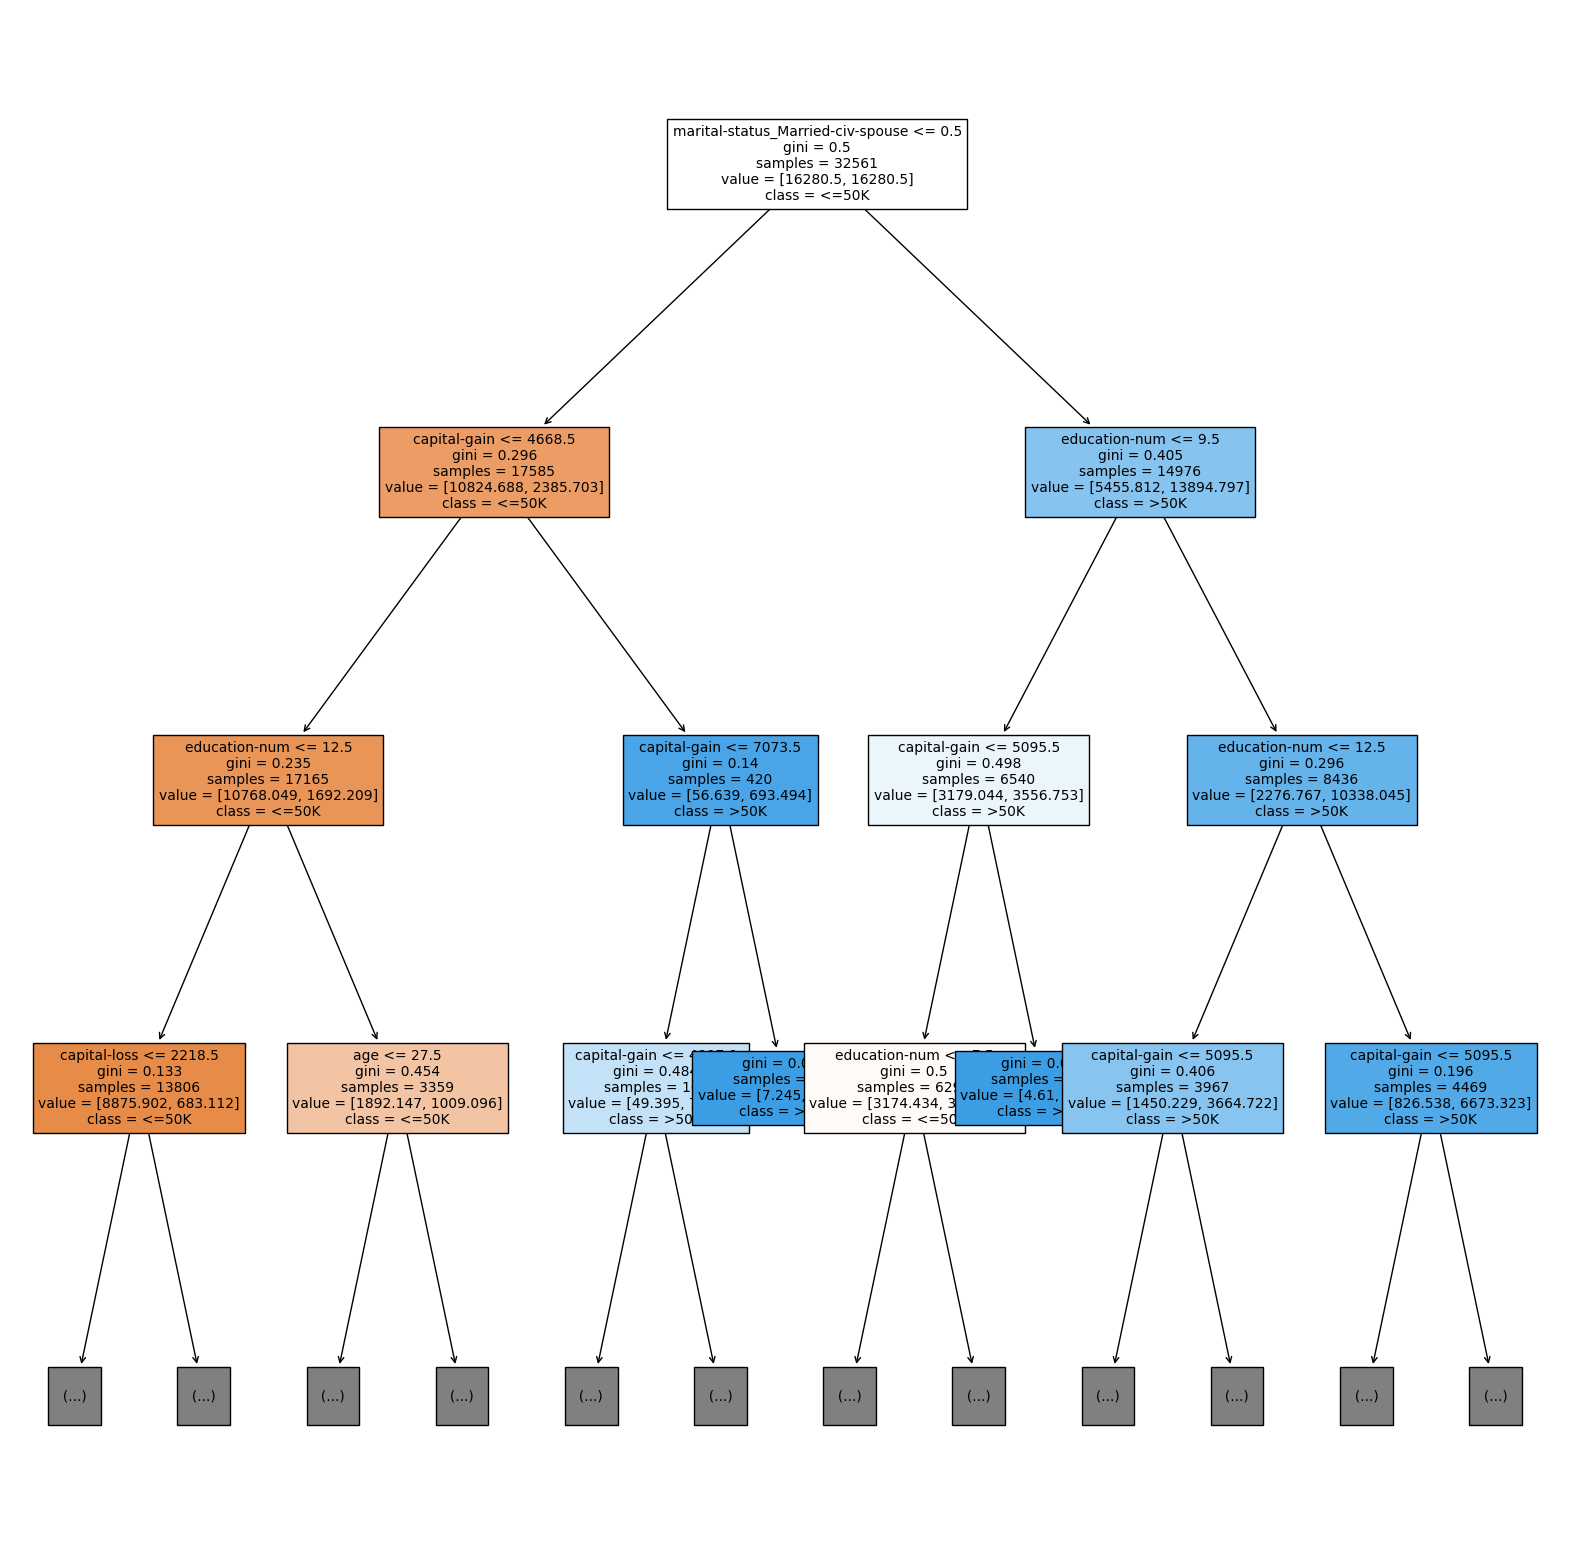

In [69]:
optuna_results = {'criterion': 'gini', 'max_depth': 25, 'class_weight': 'balanced', 'ccp_alpha': 0.00029094094429923636}
x_train_onehot_encoded = train_data_onehot_encoded.drop('income', axis=1)
x_test_onehot_encoded = test_data_onehot_encoded.drop('income', axis=1)
criterion = optuna_results['criterion']
max_depth = optuna_results['max_depth']
class_weight = optuna_results['class_weight']
ccp_alpha = optuna_results['ccp_alpha']


clf = tree.DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    class_weight=class_weight,
    ccp_alpha=ccp_alpha,
    random_state=42)

clf.fit(x_train_onehot_encoded, train_data_onehot_encoded['income'])
y_pred = clf.predict(x_test_onehot_encoded)
y_pred_proba = clf.predict_proba(x_test_onehot_encoded)
scoringCalculations(clf, x_train_onehot_encoded, train_data_onehot_encoded['income'], "Best Model", "train", n_splits=10)
scoringCalculations(clf, x_test_onehot_encoded, test_data_onehot_encoded['income'], "Best Model", "test", n_splits=10)
y_pred_conv = convertingPredictionResultToOneZero(test_data_onehot_encoded['income'])

# loss = log_loss(y_pred_conv, y_pred_proba)
# print(f"Log Loss: {loss}")


#draw top 4 level of the tree
plt.figure(figsize=(20,20))
print(f"Best params: {clf.get_params()}")
tree.plot_tree(clf, filled=True, feature_names=x_train_onehot_encoded.columns, class_names=['<=50K', '>50K'], max_depth=3, fontsize=10)